## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (145, 145)
Hypercube shape: (145, 145, 200)


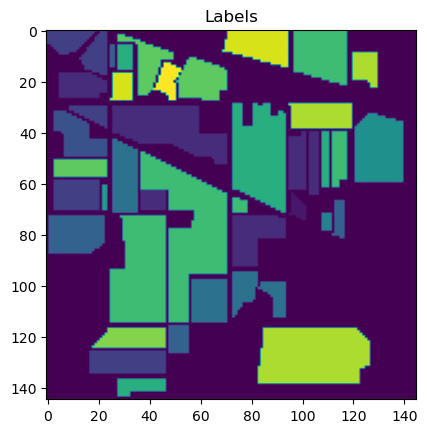

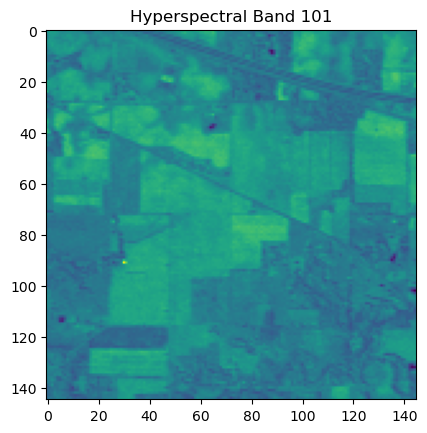

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Indian_pines_gt.mat'
data_files = 'Indian_pines_corrected.mat'
label_files = 'indian_pines_gt'
hypercube_files = 'indian_pines_corrected'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 10249
Extracted windows shape: (10249, 5, 5, 200)
Corresponding labels shape: (10249,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 40)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 46 samples
Shuffled class indices for class '1'
Selected 40 training samples and 5 validation samples for class '1'

Class: 2: Found 1428 samples
Shuffled class indices for class '2'
Selected 40 training samples and 5 validation samples for class '2'

Class: 3: Found 830 samples
Shuffled class indices for class '3'
Selected 40 training samples and 5 validation samples for class '3'

Class: 4: Found 237 samples
Shuffled class indices for class '4'
Selected 40 training samples and 5 validation samples for class '4'

Class: 5: Found 483 samples
Shuffled class indices for class '5'
Selected 40 training samples and 5 validation samples for class '5'

Class: 6: Found 730 samples
Shuffled class indices for class '6'
Selected 40 training samples and 5 validation samples for class '6'

Class: 7: Found 28 samples
Shuffled class indices for class 


All datasets saved to the 'indices' folder.
(608, 5, 5, 200)
(70, 5, 5, 200)
(9571, 5, 5, 200)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 320
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (8199, 5, 5, 200)
Validation data shape: (2050, 5, 5, 200)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

200


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/129], Loss: 0.0783, PSNR: 10.4300


Epoch [1/50] Training Loss: 0.0640, PSNR: 11.4819
	[Val]   Batch [1/33] Loss: 0.0489, PSNR: 12.7701
	[Val]   Batch [10/33] Loss: 0.0484, PSNR: 12.4144
	[Val]   Batch [20/33] Loss: 0.0480, PSNR: 12.0138
	[Val]   Batch [30/33] Loss: 0.0467, PSNR: 12.3843
Epoch [1/50] Validation Loss: 0.0487, PSNR: 12.5789

LOG: Epoch [2/50]
	 Training Batch [1/129], Loss: 0.0479, PSNR: 12.9702


Epoch [2/50] Training Loss: 0.0387, PSNR: 13.7259
	[Val]   Batch [1/33] Loss: 0.0280, PSNR: 15.1902
	[Val]   Batch [10/33] Loss: 0.0275, PSNR: 14.8671
	[Val]   Batch [20/33] Loss: 0.0273, PSNR: 14.4767
	[Val]   Batch [30/33] Loss: 0.0266, PSNR: 14.8221
Epoch [2/50] Validation Loss: 0.0279, PSNR: 14.9949

LOG: Epoch [3/50]
	 Training Batch [1/129], Loss: 0.0285, PSNR: 15.2268


Epoch [3/50] Training Loss: 0.0226, PSNR: 16.0259
	[Val]   Batch [1/33] Loss: 0.0172, PSNR: 17.3214
	[Val]   Batch [10/33] Loss: 0.0167, PSNR: 17.0385
	[Val]   Batch [20/33] Loss: 0.0164, PSNR: 16.6718
	[Val]   Batch [30/33] Loss: 0.0160, PSNR: 17.0435
Epoch [3/50] Validation Loss: 0.0171, PSNR: 17.1291

LOG: Epoch [4/50]
	 Training Batch [1/129], Loss: 0.0166, PSNR: 17.1824


Epoch [4/50] Training Loss: 0.0140, PSNR: 18.0978
	[Val]   Batch [1/33] Loss: 0.0114, PSNR: 19.0776
	[Val]   Batch [10/33] Loss: 0.0110, PSNR: 18.8547
	[Val]   Batch [20/33] Loss: 0.0107, PSNR: 18.5239
	[Val]   Batch [30/33] Loss: 0.0104, PSNR: 18.9039
Epoch [4/50] Validation Loss: 0.0114, PSNR: 18.8911

LOG: Epoch [5/50]
	 Training Batch [1/129], Loss: 0.0113, PSNR: 18.7528


Epoch [5/50] Training Loss: 0.0096, PSNR: 19.7616
	[Val]   Batch [1/33] Loss: 0.0084, PSNR: 20.4359
	[Val]   Batch [10/33] Loss: 0.0079, PSNR: 20.2737
	[Val]   Batch [20/33] Loss: 0.0077, PSNR: 19.9784
	[Val]   Batch [30/33] Loss: 0.0074, PSNR: 20.3578
Epoch [5/50] Validation Loss: 0.0083, PSNR: 20.2518

LOG: Epoch [6/50]
	 Training Batch [1/129], Loss: 0.0083, PSNR: 20.4460


Epoch [6/50] Training Loss: 0.0071, PSNR: 21.0273
	[Val]   Batch [1/33] Loss: 0.0065, PSNR: 21.5191
	[Val]   Batch [10/33] Loss: 0.0061, PSNR: 21.4163
	[Val]   Batch [20/33] Loss: 0.0058, PSNR: 21.1613
	[Val]   Batch [30/33] Loss: 0.0057, PSNR: 21.5404
Epoch [6/50] Validation Loss: 0.0065, PSNR: 21.3332

LOG: Epoch [7/50]
	 Training Batch [1/129], Loss: 0.0069, PSNR: 21.6353


Epoch [7/50] Training Loss: 0.0058, PSNR: 21.9673
	[Val]   Batch [1/33] Loss: 0.0054, PSNR: 22.3452
	[Val]   Batch [10/33] Loss: 0.0050, PSNR: 22.2979
	[Val]   Batch [20/33] Loss: 0.0047, PSNR: 22.0803
	[Val]   Batch [30/33] Loss: 0.0046, PSNR: 22.4892
Epoch [7/50] Validation Loss: 0.0054, PSNR: 22.1660

LOG: Epoch [8/50]
	 Training Batch [1/129], Loss: 0.0059, PSNR: 21.7882


Epoch [8/50] Training Loss: 0.0048, PSNR: 22.7698
	[Val]   Batch [1/33] Loss: 0.0044, PSNR: 23.2166
	[Val]   Batch [10/33] Loss: 0.0040, PSNR: 23.2496
	[Val]   Batch [20/33] Loss: 0.0038, PSNR: 23.0672
	[Val]   Batch [30/33] Loss: 0.0036, PSNR: 23.4667
Epoch [8/50] Validation Loss: 0.0044, PSNR: 23.0451

LOG: Epoch [9/50]
	 Training Batch [1/129], Loss: 0.0046, PSNR: 22.5654


Epoch [9/50] Training Loss: 0.0041, PSNR: 23.4375
	[Val]   Batch [1/33] Loss: 0.0038, PSNR: 23.8942
	[Val]   Batch [10/33] Loss: 0.0034, PSNR: 24.0111
	[Val]   Batch [20/33] Loss: 0.0032, PSNR: 23.8438
	[Val]   Batch [30/33] Loss: 0.0030, PSNR: 24.2529
Epoch [9/50] Validation Loss: 0.0038, PSNR: 23.7472

LOG: Epoch [10/50]
	 Training Batch [1/129], Loss: 0.0038, PSNR: 23.7033


Epoch [10/50] Training Loss: 0.0036, PSNR: 24.0126
	[Val]   Batch [1/33] Loss: 0.0035, PSNR: 24.2635
	[Val]   Batch [10/33] Loss: 0.0030, PSNR: 24.4445
	[Val]   Batch [20/33] Loss: 0.0028, PSNR: 24.3092
	[Val]   Batch [30/33] Loss: 0.0027, PSNR: 24.7809
Epoch [10/50] Validation Loss: 0.0034, PSNR: 24.1642

LOG: Epoch [11/50]
	 Training Batch [1/129], Loss: 0.0035, PSNR: 24.0574


Epoch [11/50] Training Loss: 0.0031, PSNR: 24.5833
	[Val]   Batch [1/33] Loss: 0.0029, PSNR: 24.9678
	[Val]   Batch [10/33] Loss: 0.0025, PSNR: 25.2391
	[Val]   Batch [20/33] Loss: 0.0023, PSNR: 25.1304
	[Val]   Batch [30/33] Loss: 0.0022, PSNR: 25.6328
Epoch [11/50] Validation Loss: 0.0029, PSNR: 24.9101

LOG: Epoch [12/50]
	 Training Batch [1/129], Loss: 0.0030, PSNR: 24.8800


Epoch [12/50] Training Loss: 0.0028, PSNR: 25.1400
	[Val]   Batch [1/33] Loss: 0.0026, PSNR: 25.5106
	[Val]   Batch [10/33] Loss: 0.0022, PSNR: 25.8807
	[Val]   Batch [20/33] Loss: 0.0020, PSNR: 25.8194
	[Val]   Batch [30/33] Loss: 0.0019, PSNR: 26.3551
Epoch [12/50] Validation Loss: 0.0025, PSNR: 25.5145

LOG: Epoch [13/50]
	 Training Batch [1/129], Loss: 0.0027, PSNR: 25.7188


Epoch [13/50] Training Loss: 0.0025, PSNR: 25.5947
	[Val]   Batch [1/33] Loss: 0.0023, PSNR: 25.9647
	[Val]   Batch [10/33] Loss: 0.0020, PSNR: 26.3402
	[Val]   Batch [20/33] Loss: 0.0018, PSNR: 26.2744
	[Val]   Batch [30/33] Loss: 0.0017, PSNR: 26.8458
Epoch [13/50] Validation Loss: 0.0023, PSNR: 25.9711

LOG: Epoch [14/50]
	 Training Batch [1/129], Loss: 0.0023, PSNR: 25.7339


Epoch [14/50] Training Loss: 0.0023, PSNR: 26.0635
	[Val]   Batch [1/33] Loss: 0.0021, PSNR: 26.3736
	[Val]   Batch [10/33] Loss: 0.0018, PSNR: 26.7750
	[Val]   Batch [20/33] Loss: 0.0016, PSNR: 26.7430
	[Val]   Batch [30/33] Loss: 0.0015, PSNR: 27.3169
Epoch [14/50] Validation Loss: 0.0021, PSNR: 26.4086

LOG: Epoch [15/50]
	 Training Batch [1/129], Loss: 0.0024, PSNR: 25.8991


Epoch [15/50] Training Loss: 0.0021, PSNR: 26.3846
	[Val]   Batch [1/33] Loss: 0.0020, PSNR: 26.7508
	[Val]   Batch [10/33] Loss: 0.0016, PSNR: 27.1302
	[Val]   Batch [20/33] Loss: 0.0015, PSNR: 27.1030
	[Val]   Batch [30/33] Loss: 0.0014, PSNR: 27.6918
Epoch [15/50] Validation Loss: 0.0019, PSNR: 26.7772

LOG: Epoch [16/50]
	 Training Batch [1/129], Loss: 0.0018, PSNR: 26.6096


Epoch [16/50] Training Loss: 0.0019, PSNR: 26.7622
	[Val]   Batch [1/33] Loss: 0.0018, PSNR: 27.2311
	[Val]   Batch [10/33] Loss: 0.0015, PSNR: 27.5593
	[Val]   Batch [20/33] Loss: 0.0013, PSNR: 27.5354
	[Val]   Batch [30/33] Loss: 0.0012, PSNR: 28.1483
Epoch [16/50] Validation Loss: 0.0017, PSNR: 27.2238

LOG: Epoch [17/50]
	 Training Batch [1/129], Loss: 0.0019, PSNR: 27.0191


Epoch [17/50] Training Loss: 0.0018, PSNR: 27.1283
	[Val]   Batch [1/33] Loss: 0.0016, PSNR: 27.7471
	[Val]   Batch [10/33] Loss: 0.0013, PSNR: 28.0605
	[Val]   Batch [20/33] Loss: 0.0012, PSNR: 28.0417
	[Val]   Batch [30/33] Loss: 0.0011, PSNR: 28.6444
Epoch [17/50] Validation Loss: 0.0015, PSNR: 27.7181

LOG: Epoch [18/50]
	 Training Batch [1/129], Loss: 0.0015, PSNR: 28.3597


Epoch [18/50] Training Loss: 0.0016, PSNR: 27.4683
	[Val]   Batch [1/33] Loss: 0.0014, PSNR: 28.0595
	[Val]   Batch [10/33] Loss: 0.0012, PSNR: 28.3175
	[Val]   Batch [20/33] Loss: 0.0011, PSNR: 28.3113
	[Val]   Batch [30/33] Loss: 0.0010, PSNR: 28.9676
Epoch [18/50] Validation Loss: 0.0014, PSNR: 28.0299

LOG: Epoch [19/50]
	 Training Batch [1/129], Loss: 0.0013, PSNR: 28.5079


Epoch [19/50] Training Loss: 0.0015, PSNR: 27.8751
	[Val]   Batch [1/33] Loss: 0.0013, PSNR: 28.5651
	[Val]   Batch [10/33] Loss: 0.0011, PSNR: 28.8072
	[Val]   Batch [20/33] Loss: 0.0010, PSNR: 28.8064
	[Val]   Batch [30/33] Loss: 0.0009, PSNR: 29.4687
Epoch [19/50] Validation Loss: 0.0013, PSNR: 28.5277

LOG: Epoch [20/50]
	 Training Batch [1/129], Loss: 0.0012, PSNR: 28.1789


Epoch [20/50] Training Loss: 0.0014, PSNR: 28.1371
	[Val]   Batch [1/33] Loss: 0.0012, PSNR: 28.7279
	[Val]   Batch [10/33] Loss: 0.0011, PSNR: 28.9185
	[Val]   Batch [20/33] Loss: 0.0010, PSNR: 28.9216
	[Val]   Batch [30/33] Loss: 0.0009, PSNR: 29.6219
Epoch [20/50] Validation Loss: 0.0012, PSNR: 28.6999

LOG: Epoch [21/50]
	 Training Batch [1/129], Loss: 0.0014, PSNR: 28.6201


Epoch [21/50] Training Loss: 0.0013, PSNR: 28.4618
	[Val]   Batch [1/33] Loss: 0.0011, PSNR: 29.3297
	[Val]   Batch [10/33] Loss: 0.0009, PSNR: 29.4938
	[Val]   Batch [20/33] Loss: 0.0008, PSNR: 29.5528
	[Val]   Batch [30/33] Loss: 0.0008, PSNR: 30.2890
Epoch [21/50] Validation Loss: 0.0011, PSNR: 29.2972

LOG: Epoch [22/50]
	 Training Batch [1/129], Loss: 0.0011, PSNR: 29.2471


Epoch [22/50] Training Loss: 0.0012, PSNR: 28.6858
	[Val]   Batch [1/33] Loss: 0.0010, PSNR: 29.5386
	[Val]   Batch [10/33] Loss: 0.0009, PSNR: 29.6975
	[Val]   Batch [20/33] Loss: 0.0008, PSNR: 29.7319
	[Val]   Batch [30/33] Loss: 0.0007, PSNR: 30.4549
Epoch [22/50] Validation Loss: 0.0010, PSNR: 29.5053

LOG: Epoch [23/50]
	 Training Batch [1/129], Loss: 0.0011, PSNR: 28.8239


Epoch [23/50] Training Loss: 0.0012, PSNR: 28.9177
	[Val]   Batch [1/33] Loss: 0.0009, PSNR: 30.0619
	[Val]   Batch [10/33] Loss: 0.0008, PSNR: 30.2363
	[Val]   Batch [20/33] Loss: 0.0007, PSNR: 30.3700
	[Val]   Batch [30/33] Loss: 0.0006, PSNR: 31.0874
Epoch [23/50] Validation Loss: 0.0009, PSNR: 30.0599

LOG: Epoch [24/50]
	 Training Batch [1/129], Loss: 0.0014, PSNR: 28.0004


Epoch [24/50] Training Loss: 0.0011, PSNR: 29.1474
	[Val]   Batch [1/33] Loss: 0.0009, PSNR: 30.1082
	[Val]   Batch [10/33] Loss: 0.0008, PSNR: 30.2750
	[Val]   Batch [20/33] Loss: 0.0007, PSNR: 30.3835
	[Val]   Batch [30/33] Loss: 0.0006, PSNR: 31.1424
Epoch [24/50] Validation Loss: 0.0009, PSNR: 30.1036

LOG: Epoch [25/50]
	 Training Batch [1/129], Loss: 0.0011, PSNR: 29.1554


Epoch [25/50] Training Loss: 0.0011, PSNR: 29.3161
	[Val]   Batch [1/33] Loss: 0.0009, PSNR: 30.3456
	[Val]   Batch [10/33] Loss: 0.0008, PSNR: 30.5109
	[Val]   Batch [20/33] Loss: 0.0007, PSNR: 30.6738
	[Val]   Batch [30/33] Loss: 0.0006, PSNR: 31.4021
Epoch [25/50] Validation Loss: 0.0008, PSNR: 30.3530

LOG: Epoch [26/50]
	 Training Batch [1/129], Loss: 0.0010, PSNR: 29.5320


Epoch [26/50] Training Loss: 0.0010, PSNR: 29.4738
	[Val]   Batch [1/33] Loss: 0.0008, PSNR: 30.6164
	[Val]   Batch [10/33] Loss: 0.0007, PSNR: 30.7796
	[Val]   Batch [20/33] Loss: 0.0006, PSNR: 30.9858
	[Val]   Batch [30/33] Loss: 0.0005, PSNR: 31.7487
Epoch [26/50] Validation Loss: 0.0008, PSNR: 30.6406

LOG: Epoch [27/50]
	 Training Batch [1/129], Loss: 0.0009, PSNR: 29.7480


Epoch [27/50] Training Loss: 0.0010, PSNR: 29.5916
	[Val]   Batch [1/33] Loss: 0.0008, PSNR: 30.5875
	[Val]   Batch [10/33] Loss: 0.0007, PSNR: 30.7056
	[Val]   Batch [20/33] Loss: 0.0006, PSNR: 30.9141
	[Val]   Batch [30/33] Loss: 0.0006, PSNR: 31.6613
Epoch [27/50] Validation Loss: 0.0008, PSNR: 30.5995

LOG: Epoch [28/50]
	 Training Batch [1/129], Loss: 0.0009, PSNR: 30.2690


Epoch [28/50] Training Loss: 0.0010, PSNR: 29.7162
	[Val]   Batch [1/33] Loss: 0.0008, PSNR: 30.6436
	[Val]   Batch [10/33] Loss: 0.0007, PSNR: 30.7640
	[Val]   Batch [20/33] Loss: 0.0006, PSNR: 30.9779
	[Val]   Batch [30/33] Loss: 0.0005, PSNR: 31.7813
Epoch [28/50] Validation Loss: 0.0008, PSNR: 30.6680

LOG: Epoch [29/50]
	 Training Batch [1/129], Loss: 0.0008, PSNR: 30.7387


Epoch [29/50] Training Loss: 0.0009, PSNR: 29.8220
	[Val]   Batch [1/33] Loss: 0.0007, PSNR: 31.0900
	[Val]   Batch [10/33] Loss: 0.0006, PSNR: 31.2294
	[Val]   Batch [20/33] Loss: 0.0005, PSNR: 31.4643
	[Val]   Batch [30/33] Loss: 0.0005, PSNR: 32.2980
Epoch [29/50] Validation Loss: 0.0007, PSNR: 31.1123
Early stopping triggered at epoch 29. No improvement for 3 epochs.


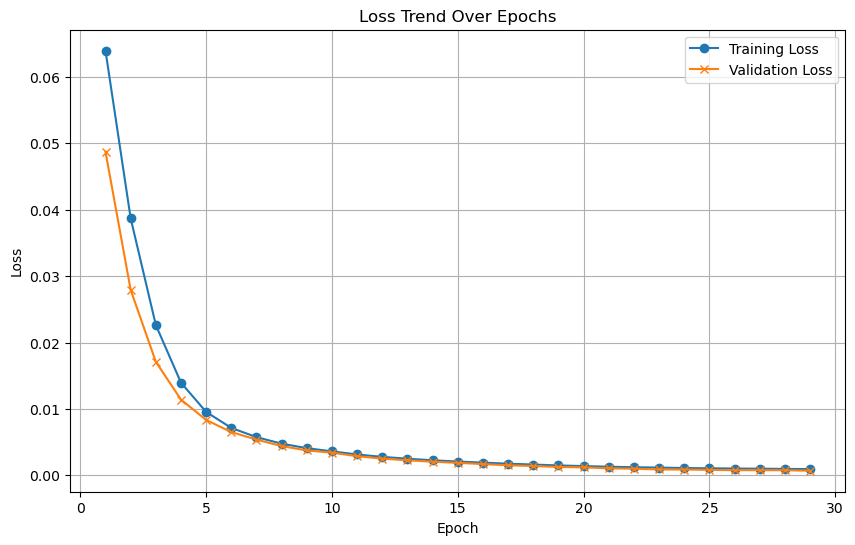

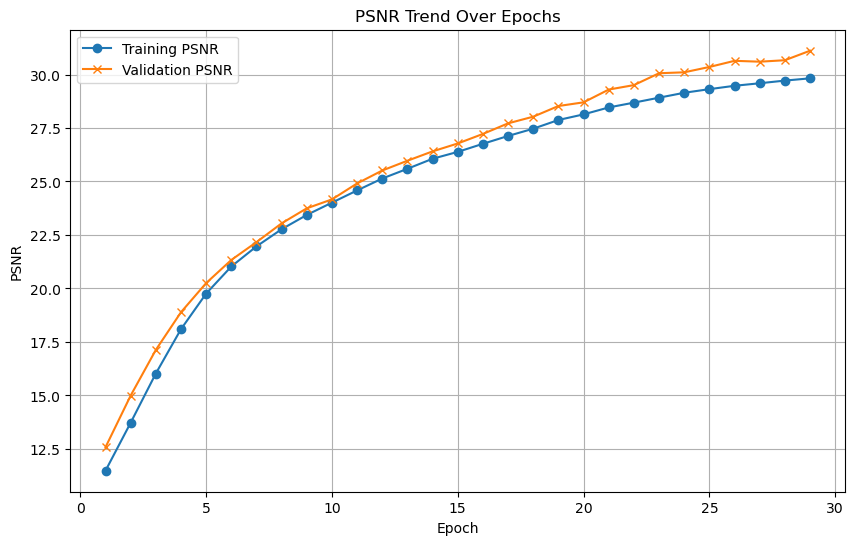

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/38 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.7986
    Validation Batch [1/1], Loss: 2.7645
Validation Loss: 2.7645, Validation Accuracy: 7.14%
Validation loss improved from inf to 2.7645. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.7692
    Validation Batch [1/1], Loss: 2.7642
Validation Loss: 2.7642, Validation Accuracy: 7.14%
Validation loss improved from 2.7645 to 2.7642. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.7401
    Validation Batch [1/1], Loss: 2.7639
Validation Loss: 2.7639, Validation Accuracy: 7.14%
Validation loss improved from 2.7642 to 2.7639. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.7258
    Validation Batch [1/1], Loss: 2.7635
Validation Loss: 2.7635, Validation Accuracy: 7.14%
Validation loss improved from 2.7639 to 2.7635. Saving model...

LOG: Epoch [5/1000] - 

    Validation Batch [1/1], Loss: 2.7625
Validation Loss: 2.7625, Validation Accuracy: 7.14%
Validation loss improved from 2.7629 to 2.7625. Saving model...

LOG: Epoch [8/1000] - Training
Epoch [8/1000] completed, Average Training Loss: 2.6766
    Validation Batch [1/1], Loss: 2.7623
Validation Loss: 2.7623, Validation Accuracy: 7.14%
Validation loss improved from 2.7625 to 2.7623. Saving model...

LOG: Epoch [9/1000] - Training
Epoch [9/1000] completed, Average Training Loss: 2.6745
    Validation Batch [1/1], Loss: 2.7621
Validation Loss: 2.7621, Validation Accuracy: 7.14%
Validation loss improved from 2.7623 to 2.7621. Saving model...

LOG: Epoch [10/1000] - Training
Epoch [10/1000] completed, Average Training Loss: 2.6483
    Validation Batch [1/1], Loss: 2.7619
Validation Loss: 2.7619, Validation Accuracy: 7.14%
Validation loss improved from 2.7621 to 2.7619. Saving model...

LOG: Epoch [11/1000] - Training
Epoch [11/1000] completed, Average Training Loss: 2.6413
    Validation B

Epoch [16/1000] completed, Average Training Loss: 2.6084
    Validation Batch [1/1], Loss: 2.7608
Validation Loss: 2.7608, Validation Accuracy: 7.14%
Validation loss improved from 2.7610 to 2.7608. Saving model...

LOG: Epoch [17/1000] - Training
Epoch [17/1000] completed, Average Training Loss: 2.5990
    Validation Batch [1/1], Loss: 2.7605
Validation Loss: 2.7605, Validation Accuracy: 7.14%
Validation loss improved from 2.7608 to 2.7605. Saving model...

LOG: Epoch [18/1000] - Training
Epoch [18/1000] completed, Average Training Loss: 2.5961
    Validation Batch [1/1], Loss: 2.7603
Validation Loss: 2.7603, Validation Accuracy: 7.14%
Validation loss improved from 2.7605 to 2.7603. Saving model...

LOG: Epoch [19/1000] - Training
Epoch [19/1000] completed, Average Training Loss: 2.5765
    Validation Batch [1/1], Loss: 2.7599
Validation Loss: 2.7599, Validation Accuracy: 7.14%
Validation loss improved from 2.7603 to 2.7599. Saving model...

LOG: Epoch [20/1000] - Training
Epoch [20/10

Epoch [31/1000] completed, Average Training Loss: 2.5020
    Validation Batch [1/1], Loss: 2.7437
Validation Loss: 2.7437, Validation Accuracy: 7.14%
Validation loss improved from 2.7468 to 2.7437. Saving model...

LOG: Epoch [32/1000] - Training
Epoch [32/1000] completed, Average Training Loss: 2.4904
    Validation Batch [1/1], Loss: 2.7404
Validation Loss: 2.7404, Validation Accuracy: 8.57%
Validation loss improved from 2.7437 to 2.7404. Saving model...

LOG: Epoch [33/1000] - Training
Epoch [33/1000] completed, Average Training Loss: 2.4912
    Validation Batch [1/1], Loss: 2.7365
Validation Loss: 2.7365, Validation Accuracy: 8.57%
Validation loss improved from 2.7404 to 2.7365. Saving model...

LOG: Epoch [34/1000] - Training
Epoch [34/1000] completed, Average Training Loss: 2.4831
    Validation Batch [1/1], Loss: 2.7327
Validation Loss: 2.7327, Validation Accuracy: 10.00%
Validation loss improved from 2.7365 to 2.7327. Saving model...

LOG: Epoch [35/1000] - Training
Epoch [35/1

    Validation Batch [1/1], Loss: 2.6888
Validation Loss: 2.6888, Validation Accuracy: 18.57%
Validation loss improved from 2.6985 to 2.6888. Saving model...

LOG: Epoch [40/1000] - Training
Epoch [40/1000] completed, Average Training Loss: 2.4292
    Validation Batch [1/1], Loss: 2.6781
Validation Loss: 2.6781, Validation Accuracy: 22.86%
Validation loss improved from 2.6888 to 2.6781. Saving model...

LOG: Epoch [41/1000] - Training
Epoch [41/1000] completed, Average Training Loss: 2.4295
    Validation Batch [1/1], Loss: 2.6668
Validation Loss: 2.6668, Validation Accuracy: 22.86%
Validation loss improved from 2.6781 to 2.6668. Saving model...

LOG: Epoch [42/1000] - Training
Epoch [42/1000] completed, Average Training Loss: 2.4299
    Validation Batch [1/1], Loss: 2.6558
Validation Loss: 2.6558, Validation Accuracy: 22.86%
Validation loss improved from 2.6668 to 2.6558. Saving model...

LOG: Epoch [43/1000] - Training
Epoch [43/1000] completed, Average Training Loss: 2.4131
    Vali

    Validation Batch [1/1], Loss: 2.4647
Validation Loss: 2.4647, Validation Accuracy: 34.29%
Validation loss improved from 2.4783 to 2.4647. Saving model...

LOG: Epoch [55/1000] - Training
Epoch [55/1000] completed, Average Training Loss: 2.3436
    Validation Batch [1/1], Loss: 2.4493
Validation Loss: 2.4493, Validation Accuracy: 35.71%
Validation loss improved from 2.4647 to 2.4493. Saving model...

LOG: Epoch [56/1000] - Training
Epoch [56/1000] completed, Average Training Loss: 2.3326
    Validation Batch [1/1], Loss: 2.4274
Validation Loss: 2.4274, Validation Accuracy: 38.57%
Validation loss improved from 2.4493 to 2.4274. Saving model...

LOG: Epoch [57/1000] - Training
Epoch [57/1000] completed, Average Training Loss: 2.3063
    Validation Batch [1/1], Loss: 2.4119
Validation Loss: 2.4119, Validation Accuracy: 40.00%
Validation loss improved from 2.4274 to 2.4119. Saving model...

LOG: Epoch [58/1000] - Training
Epoch [58/1000] completed, Average Training Loss: 2.2920
    Vali

Epoch [62/1000] completed, Average Training Loss: 2.2649
    Validation Batch [1/1], Loss: 2.3533
Validation Loss: 2.3533, Validation Accuracy: 38.57%
Validation loss improved from 2.3682 to 2.3533. Saving model...

LOG: Epoch [63/1000] - Training
Epoch [63/1000] completed, Average Training Loss: 2.2709
    Validation Batch [1/1], Loss: 2.3517
Validation Loss: 2.3517, Validation Accuracy: 42.86%
Validation loss improved from 2.3533 to 2.3517. Saving model...

LOG: Epoch [64/1000] - Training
Epoch [64/1000] completed, Average Training Loss: 2.2499
    Validation Batch [1/1], Loss: 2.3342
Validation Loss: 2.3342, Validation Accuracy: 42.86%
Validation loss improved from 2.3517 to 2.3342. Saving model...

LOG: Epoch [65/1000] - Training
Epoch [65/1000] completed, Average Training Loss: 2.2656
    Validation Batch [1/1], Loss: 2.2946
Validation Loss: 2.2946, Validation Accuracy: 42.86%
Validation loss improved from 2.3342 to 2.2946. Saving model...

LOG: Epoch [66/1000] - Training
Epoch [6

    Validation Batch [1/1], Loss: 2.2077
Validation Loss: 2.2077, Validation Accuracy: 44.29%
Validation loss improved from 2.2146 to 2.2077. Saving model...

LOG: Epoch [76/1000] - Training
Epoch [76/1000] completed, Average Training Loss: 2.1862
    Validation Batch [1/1], Loss: 2.1699
Validation Loss: 2.1699, Validation Accuracy: 44.29%
Validation loss improved from 2.2077 to 2.1699. Saving model...

LOG: Epoch [77/1000] - Training
Epoch [77/1000] completed, Average Training Loss: 2.1665
    Validation Batch [1/1], Loss: 2.1320
Validation Loss: 2.1320, Validation Accuracy: 41.43%
Validation loss improved from 2.1699 to 2.1320. Saving model...

LOG: Epoch [78/1000] - Training
Epoch [78/1000] completed, Average Training Loss: 2.1753
    Validation Batch [1/1], Loss: 2.1370
Validation Loss: 2.1370, Validation Accuracy: 40.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [79/1000] - Training
Epoch [79/1000] completed, Average Training Loss: 2.1578
    Validation Batch [1

Epoch [85/1000] completed, Average Training Loss: 2.1191
    Validation Batch [1/1], Loss: 2.0890
Validation Loss: 2.0890, Validation Accuracy: 48.57%
Validation loss improved from 2.1088 to 2.0890. Saving model...

LOG: Epoch [86/1000] - Training
Epoch [86/1000] completed, Average Training Loss: 2.1166
    Validation Batch [1/1], Loss: 2.0991
Validation Loss: 2.0991, Validation Accuracy: 44.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [87/1000] - Training
Epoch [87/1000] completed, Average Training Loss: 2.0925
    Validation Batch [1/1], Loss: 2.1003
Validation Loss: 2.1003, Validation Accuracy: 37.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [88/1000] - Training
Epoch [88/1000] completed, Average Training Loss: 2.1077
    Validation Batch [1/1], Loss: 2.1002
Validation Loss: 2.1002, Validation Accuracy: 34.29%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [89/1000] - Training
Epoch [89/1000] completed, Average Training Loss: 2.0

Epoch [97/1000] completed, Average Training Loss: 2.0372
    Validation Batch [1/1], Loss: 2.1905
Validation Loss: 2.1905, Validation Accuracy: 22.86%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [98/1000] - Training
Epoch [98/1000] completed, Average Training Loss: 1.9973
    Validation Batch [1/1], Loss: 2.1307
Validation Loss: 2.1307, Validation Accuracy: 28.57%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [99/1000] - Training
Epoch [99/1000] completed, Average Training Loss: 2.0171
    Validation Batch [1/1], Loss: 2.0306
Validation Loss: 2.0306, Validation Accuracy: 32.86%
Validation loss improved from 2.0581 to 2.0306. Saving model...

LOG: Epoch [100/1000] - Training
Epoch [100/1000] completed, Average Training Loss: 2.0067
    Validation Batch [1/1], Loss: 2.0074
Validation Loss: 2.0074, Validation Accuracy: 34.29%
Validation loss improved from 2.0306 to 2.0074. Saving model...

LOG: Epoch [101/1000] - Training
Epoch [101/1000] completed, Average

    Validation Batch [1/1], Loss: 1.9491
Validation Loss: 1.9491, Validation Accuracy: 45.71%
Validation loss improved from 1.9691 to 1.9491. Saving model...

LOG: Epoch [108/1000] - Training
Epoch [108/1000] completed, Average Training Loss: 1.9483
    Validation Batch [1/1], Loss: 1.9463
Validation Loss: 1.9463, Validation Accuracy: 41.43%
Validation loss improved from 1.9491 to 1.9463. Saving model...

LOG: Epoch [109/1000] - Training
Epoch [109/1000] completed, Average Training Loss: 1.9373
    Validation Batch [1/1], Loss: 2.0000
Validation Loss: 2.0000, Validation Accuracy: 28.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [110/1000] - Training
Epoch [110/1000] completed, Average Training Loss: 1.9107
    Validation Batch [1/1], Loss: 2.0309
Validation Loss: 2.0309, Validation Accuracy: 32.86%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [111/1000] - Training
Epoch [111/1000] completed, Average Training Loss: 1.8990
    Validation Batch [1/1], Lo

Epoch [120/1000] completed, Average Training Loss: 1.8158
    Validation Batch [1/1], Loss: 1.9253
Validation Loss: 1.9253, Validation Accuracy: 47.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [121/1000] - Training
Epoch [121/1000] completed, Average Training Loss: 1.8220
    Validation Batch [1/1], Loss: 2.0179
Validation Loss: 2.0179, Validation Accuracy: 35.71%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [122/1000] - Training
Epoch [122/1000] completed, Average Training Loss: 1.7865
    Validation Batch [1/1], Loss: 2.0377
Validation Loss: 2.0377, Validation Accuracy: 28.57%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [123/1000] - Training
Epoch [123/1000] completed, Average Training Loss: 1.7968
    Validation Batch [1/1], Loss: 1.9916
Validation Loss: 1.9916, Validation Accuracy: 27.14%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [124/1000] - Training
Epoch [124/1000] completed, Average Training Loss: 1.7796
  

Epoch [130/1000] completed, Average Training Loss: 1.7563
    Validation Batch [1/1], Loss: 1.8144
Validation Loss: 1.8144, Validation Accuracy: 54.29%
Validation loss improved from 1.8395 to 1.8144. Saving model...

LOG: Epoch [131/1000] - Training
Epoch [131/1000] completed, Average Training Loss: 1.7377
    Validation Batch [1/1], Loss: 1.7778
Validation Loss: 1.7778, Validation Accuracy: 52.86%
Validation loss improved from 1.8144 to 1.7778. Saving model...

LOG: Epoch [132/1000] - Training
Epoch [132/1000] completed, Average Training Loss: 1.7218
    Validation Batch [1/1], Loss: 1.7614
Validation Loss: 1.7614, Validation Accuracy: 55.71%
Validation loss improved from 1.7778 to 1.7614. Saving model...

LOG: Epoch [133/1000] - Training
Epoch [133/1000] completed, Average Training Loss: 1.7187
    Validation Batch [1/1], Loss: 1.7829
Validation Loss: 1.7829, Validation Accuracy: 52.86%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [134/1000] - Training
Epoch [134/1000

    Validation Batch [1/1], Loss: 1.7302
Validation Loss: 1.7302, Validation Accuracy: 48.57%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [144/1000] - Training
Epoch [144/1000] completed, Average Training Loss: 1.6247
    Validation Batch [1/1], Loss: 1.7008
Validation Loss: 1.7008, Validation Accuracy: 60.00%
Validation loss improved from 1.7134 to 1.7008. Saving model...

LOG: Epoch [145/1000] - Training
Epoch [145/1000] completed, Average Training Loss: 1.6210
    Validation Batch [1/1], Loss: 1.6864
Validation Loss: 1.6864, Validation Accuracy: 65.71%
Validation loss improved from 1.7008 to 1.6864. Saving model...

LOG: Epoch [146/1000] - Training
Epoch [146/1000] completed, Average Training Loss: 1.6166
    Validation Batch [1/1], Loss: 1.6520
Validation Loss: 1.6520, Validation Accuracy: 68.57%
Validation loss improved from 1.6864 to 1.6520. Saving model...

LOG: Epoch [147/1000] - Training
Epoch [147/1000] completed, Average Training Loss: 1.6076
    Validation 

Epoch [154/1000] completed, Average Training Loss: 1.5396
    Validation Batch [1/1], Loss: 1.5891
Validation Loss: 1.5891, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [155/1000] - Training
Epoch [155/1000] completed, Average Training Loss: 1.5408
    Validation Batch [1/1], Loss: 1.5922
Validation Loss: 1.5922, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [156/1000] - Training
Epoch [156/1000] completed, Average Training Loss: 1.5156
    Validation Batch [1/1], Loss: 1.5843
Validation Loss: 1.5843, Validation Accuracy: 65.71%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [157/1000] - Training
Epoch [157/1000] completed, Average Training Loss: 1.4804
    Validation Batch [1/1], Loss: 1.5918
Validation Loss: 1.5918, Validation Accuracy: 58.57%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [158/1000] - Training
Epoch [158/1000] completed, Average Training Loss: 1.5240
  

Epoch [164/1000] completed, Average Training Loss: 1.4534
    Validation Batch [1/1], Loss: 1.5410
Validation Loss: 1.5410, Validation Accuracy: 72.86%
Validation loss improved from 1.5526 to 1.5410. Saving model...

LOG: Epoch [165/1000] - Training
Epoch [165/1000] completed, Average Training Loss: 1.4398
    Validation Batch [1/1], Loss: 1.6075
Validation Loss: 1.6075, Validation Accuracy: 65.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [166/1000] - Training
Epoch [166/1000] completed, Average Training Loss: 1.4370
    Validation Batch [1/1], Loss: 1.5482
Validation Loss: 1.5482, Validation Accuracy: 58.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [167/1000] - Training
Epoch [167/1000] completed, Average Training Loss: 1.4228
    Validation Batch [1/1], Loss: 1.5477
Validation Loss: 1.5477, Validation Accuracy: 64.29%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [168/1000] - Training
Epoch [168/1000] completed, Average Training 

Epoch [177/1000] completed, Average Training Loss: 1.3618
    Validation Batch [1/1], Loss: 1.4347
Validation Loss: 1.4347, Validation Accuracy: 68.57%
Validation loss improved from 1.5041 to 1.4347. Saving model...

LOG: Epoch [178/1000] - Training
Epoch [178/1000] completed, Average Training Loss: 1.3174
    Validation Batch [1/1], Loss: 1.4981
Validation Loss: 1.4981, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [179/1000] - Training
Epoch [179/1000] completed, Average Training Loss: 1.3123
    Validation Batch [1/1], Loss: 1.4683
Validation Loss: 1.4683, Validation Accuracy: 65.71%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [180/1000] - Training
Epoch [180/1000] completed, Average Training Loss: 1.3042
    Validation Batch [1/1], Loss: 1.4539
Validation Loss: 1.4539, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [181/1000] - Training
Epoch [181/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 1.5075
Validation Loss: 1.5075, Validation Accuracy: 62.86%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [187/1000] - Training
Epoch [187/1000] completed, Average Training Loss: 1.2712
    Validation Batch [1/1], Loss: 1.5407
Validation Loss: 1.5407, Validation Accuracy: 65.71%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [188/1000] - Training
Epoch [188/1000] completed, Average Training Loss: 1.2660
    Validation Batch [1/1], Loss: 1.5414
Validation Loss: 1.5414, Validation Accuracy: 68.57%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [189/1000] - Training
Epoch [189/1000] completed, Average Training Loss: 1.2416
    Validation Batch [1/1], Loss: 1.5262
Validation Loss: 1.5262, Validation Accuracy: 64.29%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [190/1000] - Training
Epoch [190/1000] completed, Average Training Loss: 1.2418
    Validation Batch [1/1], Loss: 1.4164
Validation Loss: 1.

    Validation Batch [1/1], Loss: 1.3533
Validation Loss: 1.3533, Validation Accuracy: 72.86%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [200/1000] - Training
Epoch [200/1000] completed, Average Training Loss: 1.1485
    Validation Batch [1/1], Loss: 1.3270
Validation Loss: 1.3270, Validation Accuracy: 75.71%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [201/1000] - Training
Epoch [201/1000] completed, Average Training Loss: 1.1004
    Validation Batch [1/1], Loss: 1.3607
Validation Loss: 1.3607, Validation Accuracy: 68.57%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [202/1000] - Training
Epoch [202/1000] completed, Average Training Loss: 1.1336
    Validation Batch [1/1], Loss: 1.3364
Validation Loss: 1.3364, Validation Accuracy: 68.57%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [203/1000] - Training
Epoch [203/1000] completed, Average Training Loss: 1.0854
    Validation Batch [1/1], Loss: 1.2892
Validation Loss: 1.

    Validation Batch [1/1], Loss: 1.2820
Validation Loss: 1.2820, Validation Accuracy: 75.71%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [208/1000] - Training
Epoch [208/1000] completed, Average Training Loss: 1.0851
    Validation Batch [1/1], Loss: 1.2630
Validation Loss: 1.2630, Validation Accuracy: 77.14%
Validation loss improved from 1.2698 to 1.2630. Saving model...

LOG: Epoch [209/1000] - Training
Epoch [209/1000] completed, Average Training Loss: 1.0694
    Validation Batch [1/1], Loss: 1.2594
Validation Loss: 1.2594, Validation Accuracy: 77.14%
Validation loss improved from 1.2630 to 1.2594. Saving model...

LOG: Epoch [210/1000] - Training
Epoch [210/1000] completed, Average Training Loss: 1.0926
    Validation Batch [1/1], Loss: 1.2585
Validation Loss: 1.2585, Validation Accuracy: 78.57%
Validation loss improved from 1.2594 to 1.2585. Saving model...

LOG: Epoch [211/1000] - Training
Epoch [211/1000] completed, Average Training Loss: 1.0690
    Validation 

    Validation Batch [1/1], Loss: 1.2095
Validation Loss: 1.2095, Validation Accuracy: 75.71%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [223/1000] - Training
Epoch [223/1000] completed, Average Training Loss: 0.9621
    Validation Batch [1/1], Loss: 1.2028
Validation Loss: 1.2028, Validation Accuracy: 75.71%
Validation loss improved from 1.2043 to 1.2028. Saving model...

LOG: Epoch [224/1000] - Training
Epoch [224/1000] completed, Average Training Loss: 0.9567
    Validation Batch [1/1], Loss: 1.3216
Validation Loss: 1.3216, Validation Accuracy: 65.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [225/1000] - Training
Epoch [225/1000] completed, Average Training Loss: 0.9758
    Validation Batch [1/1], Loss: 1.2238
Validation Loss: 1.2238, Validation Accuracy: 71.43%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [226/1000] - Training
Epoch [226/1000] completed, Average Training Loss: 0.9151
    Validation Batch [1/1], Loss: 1.3061
Val

    Validation Batch [1/1], Loss: 1.3713
Validation Loss: 1.3713, Validation Accuracy: 68.57%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [231/1000] - Training
Epoch [231/1000] completed, Average Training Loss: 0.9069
    Validation Batch [1/1], Loss: 1.3567
Validation Loss: 1.3567, Validation Accuracy: 72.86%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [232/1000] - Training
Epoch [232/1000] completed, Average Training Loss: 0.8799
    Validation Batch [1/1], Loss: 1.1607
Validation Loss: 1.1607, Validation Accuracy: 77.14%
Validation loss improved from 1.2028 to 1.1607. Saving model...

LOG: Epoch [233/1000] - Training
Epoch [233/1000] completed, Average Training Loss: 0.9149
    Validation Batch [1/1], Loss: 1.1050
Validation Loss: 1.1050, Validation Accuracy: 78.57%
Validation loss improved from 1.1607 to 1.1050. Saving model...

LOG: Epoch [234/1000] - Training
Epoch [234/1000] completed, Average Training Loss: 0.8590
    Validation Batch [1/1], Lo

Epoch [246/1000] completed, Average Training Loss: 0.8061
    Validation Batch [1/1], Loss: 1.0924
Validation Loss: 1.0924, Validation Accuracy: 75.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [247/1000] - Training
Epoch [247/1000] completed, Average Training Loss: 0.7992
    Validation Batch [1/1], Loss: 1.1054
Validation Loss: 1.1054, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [248/1000] - Training
Epoch [248/1000] completed, Average Training Loss: 0.8070
    Validation Batch [1/1], Loss: 1.2822
Validation Loss: 1.2822, Validation Accuracy: 65.71%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [249/1000] - Training
Epoch [249/1000] completed, Average Training Loss: 0.7724
    Validation Batch [1/1], Loss: 1.1558
Validation Loss: 1.1558, Validation Accuracy: 71.43%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [250/1000] - Training
Epoch [250/1000] completed, Average Training Loss: 0.7883
  

    Validation Batch [1/1], Loss: 1.0448
Validation Loss: 1.0448, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [257/1000] - Training
Epoch [257/1000] completed, Average Training Loss: 0.7044
    Validation Batch [1/1], Loss: 1.0205
Validation Loss: 1.0205, Validation Accuracy: 77.14%
Validation loss improved from 1.0274 to 1.0205. Saving model...

LOG: Epoch [258/1000] - Training
Epoch [258/1000] completed, Average Training Loss: 0.7191
    Validation Batch [1/1], Loss: 1.1145
Validation Loss: 1.1145, Validation Accuracy: 72.86%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [259/1000] - Training
Epoch [259/1000] completed, Average Training Loss: 0.7245
    Validation Batch [1/1], Loss: 1.0422
Validation Loss: 1.0422, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [260/1000] - Training
Epoch [260/1000] completed, Average Training Loss: 0.7167
    Validation Batch [1/1], Loss: 1.0297
Val

    Validation Batch [1/1], Loss: 0.9660
Validation Loss: 0.9660, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [270/1000] - Training
Epoch [270/1000] completed, Average Training Loss: 0.6457
    Validation Batch [1/1], Loss: 1.1190
Validation Loss: 1.1190, Validation Accuracy: 68.57%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [271/1000] - Training
Epoch [271/1000] completed, Average Training Loss: 0.6490
    Validation Batch [1/1], Loss: 1.2617
Validation Loss: 1.2617, Validation Accuracy: 62.86%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [272/1000] - Training
Epoch [272/1000] completed, Average Training Loss: 0.6523
    Validation Batch [1/1], Loss: 1.0090
Validation Loss: 1.0090, Validation Accuracy: 74.29%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [273/1000] - Training
Epoch [273/1000] completed, Average Training Loss: 0.6436
    Validation Batch [1/1], Loss: 0.9557
Validation Loss: 0.

    Validation Batch [1/1], Loss: 0.9267
Validation Loss: 0.9267, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [278/1000] - Training
Epoch [278/1000] completed, Average Training Loss: 0.6046
    Validation Batch [1/1], Loss: 0.9145
Validation Loss: 0.9145, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [279/1000] - Training
Epoch [279/1000] completed, Average Training Loss: 0.6095
    Validation Batch [1/1], Loss: 1.0673
Validation Loss: 1.0673, Validation Accuracy: 75.71%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [280/1000] - Training
Epoch [280/1000] completed, Average Training Loss: 0.5766
    Validation Batch [1/1], Loss: 1.0880
Validation Loss: 1.0880, Validation Accuracy: 72.86%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [281/1000] - Training
Epoch [281/1000] completed, Average Training Loss: 0.5716
    Validation Batch [1/1], Loss: 1.3848
Validation Loss: 1.

Epoch [293/1000] completed, Average Training Loss: 0.5222
    Validation Batch [1/1], Loss: 0.9450
Validation Loss: 0.9450, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [294/1000] - Training
Epoch [294/1000] completed, Average Training Loss: 0.5208
    Validation Batch [1/1], Loss: 1.0094
Validation Loss: 1.0094, Validation Accuracy: 71.43%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [295/1000] - Training
Epoch [295/1000] completed, Average Training Loss: 0.5056
    Validation Batch [1/1], Loss: 1.0718
Validation Loss: 1.0718, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [296/1000] - Training
Epoch [296/1000] completed, Average Training Loss: 0.5003
    Validation Batch [1/1], Loss: 0.7875
Validation Loss: 0.7875, Validation Accuracy: 85.71%
Validation loss improved from 0.8424 to 0.7875. Saving model...

LOG: Epoch [297/1000] - Training
Epoch [297/1000] completed, Average Training 

Epoch [301/1000] completed, Average Training Loss: 0.5128
    Validation Batch [1/1], Loss: 1.0188
Validation Loss: 1.0188, Validation Accuracy: 75.71%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [302/1000] - Training
Epoch [302/1000] completed, Average Training Loss: 0.4693
    Validation Batch [1/1], Loss: 0.9591
Validation Loss: 0.9591, Validation Accuracy: 78.57%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [303/1000] - Training
Epoch [303/1000] completed, Average Training Loss: 0.4669
    Validation Batch [1/1], Loss: 0.9581
Validation Loss: 0.9581, Validation Accuracy: 78.57%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [304/1000] - Training
Epoch [304/1000] completed, Average Training Loss: 0.5028
    Validation Batch [1/1], Loss: 0.9650
Validation Loss: 0.9650, Validation Accuracy: 72.86%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [305/1000] - Training
Epoch [305/1000] completed, Average Training Loss: 0.4738
  

Epoch [307/1000] completed, Average Training Loss: 0.4858
    Validation Batch [1/1], Loss: 0.9361
Validation Loss: 0.9361, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [308/1000] - Training
Epoch [308/1000] completed, Average Training Loss: 0.4982
    Validation Batch [1/1], Loss: 0.8287
Validation Loss: 0.8287, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [309/1000] - Training
Epoch [309/1000] completed, Average Training Loss: 0.4549
    Validation Batch [1/1], Loss: 0.9583
Validation Loss: 0.9583, Validation Accuracy: 72.86%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [310/1000] - Training
Epoch [310/1000] completed, Average Training Loss: 0.4692
    Validation Batch [1/1], Loss: 0.7226
Validation Loss: 0.7226, Validation Accuracy: 87.14%
Validation loss improved from 0.7701 to 0.7226. Saving model...

LOG: Epoch [311/1000] - Training
Epoch [311/1000] completed, Average Traini

Epoch [313/1000] completed, Average Training Loss: 0.4371
    Validation Batch [1/1], Loss: 1.0253
Validation Loss: 1.0253, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [314/1000] - Training
Epoch [314/1000] completed, Average Training Loss: 0.4243
    Validation Batch [1/1], Loss: 0.7985
Validation Loss: 0.7985, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [315/1000] - Training
Epoch [315/1000] completed, Average Training Loss: 0.4412
    Validation Batch [1/1], Loss: 0.8205
Validation Loss: 0.8205, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [316/1000] - Training
Epoch [316/1000] completed, Average Training Loss: 0.4513
    Validation Batch [1/1], Loss: 0.8648
Validation Loss: 0.8648, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [317/1000] - Training
Epoch [317/1000] completed, Average Training Loss: 0.4219
  

Epoch [331/1000] completed, Average Training Loss: 0.4037
    Validation Batch [1/1], Loss: 0.6660
Validation Loss: 0.6660, Validation Accuracy: 88.57%
Validation loss improved from 0.6818 to 0.6660. Saving model...

LOG: Epoch [332/1000] - Training
Epoch [332/1000] completed, Average Training Loss: 0.3755
    Validation Batch [1/1], Loss: 1.0361
Validation Loss: 1.0361, Validation Accuracy: 74.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [333/1000] - Training
Epoch [333/1000] completed, Average Training Loss: 0.3672
    Validation Batch [1/1], Loss: 0.8014
Validation Loss: 0.8014, Validation Accuracy: 78.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [334/1000] - Training
Epoch [334/1000] completed, Average Training Loss: 0.3533
    Validation Batch [1/1], Loss: 1.3538
Validation Loss: 1.3538, Validation Accuracy: 65.71%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [335/1000] - Training
Epoch [335/1000] completed, Average Training 

Epoch [336/1000] completed, Average Training Loss: 0.3841
    Validation Batch [1/1], Loss: 1.1143
Validation Loss: 1.1143, Validation Accuracy: 67.14%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [337/1000] - Training
Epoch [337/1000] completed, Average Training Loss: 0.3464
    Validation Batch [1/1], Loss: 1.0498
Validation Loss: 1.0498, Validation Accuracy: 71.43%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [338/1000] - Training
Epoch [338/1000] completed, Average Training Loss: 0.3519
    Validation Batch [1/1], Loss: 1.0877
Validation Loss: 1.0877, Validation Accuracy: 74.29%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [339/1000] - Training
Epoch [339/1000] completed, Average Training Loss: 0.3507
    Validation Batch [1/1], Loss: 0.8564
Validation Loss: 0.8564, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [340/1000] - Training
Epoch [340/1000] completed, Average Training Loss: 0.3813
  

Epoch [355/1000] completed, Average Training Loss: 0.3287
    Validation Batch [1/1], Loss: 0.7728
Validation Loss: 0.7728, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [356/1000] - Training
Epoch [356/1000] completed, Average Training Loss: 0.2765
    Validation Batch [1/1], Loss: 1.2134
Validation Loss: 1.2134, Validation Accuracy: 62.86%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [357/1000] - Training
Epoch [357/1000] completed, Average Training Loss: 0.3227
    Validation Batch [1/1], Loss: 0.7813
Validation Loss: 0.7813, Validation Accuracy: 74.29%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [358/1000] - Training
Epoch [358/1000] completed, Average Training Loss: 0.3094
    Validation Batch [1/1], Loss: 0.6554
Validation Loss: 0.6554, Validation Accuracy: 81.43%
Validation loss improved from 0.6660 to 0.6554. Saving model...

LOG: Epoch [359/1000] - Training
Epoch [359/1000] completed, Average Traini

Epoch [360/1000] completed, Average Training Loss: 0.3024
    Validation Batch [1/1], Loss: 0.6451
Validation Loss: 0.6451, Validation Accuracy: 90.00%
Validation loss improved from 0.6554 to 0.6451. Saving model...

LOG: Epoch [361/1000] - Training
Epoch [361/1000] completed, Average Training Loss: 0.3075
    Validation Batch [1/1], Loss: 0.6641
Validation Loss: 0.6641, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [362/1000] - Training
Epoch [362/1000] completed, Average Training Loss: 0.2904
    Validation Batch [1/1], Loss: 0.7085
Validation Loss: 0.7085, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [363/1000] - Training
Epoch [363/1000] completed, Average Training Loss: 0.2875
    Validation Batch [1/1], Loss: 0.6615
Validation Loss: 0.6615, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [364/1000] - Training
Epoch [364/1000] completed, Average Training 

Epoch [379/1000] completed, Average Training Loss: 0.2431
    Validation Batch [1/1], Loss: 0.6298
Validation Loss: 0.6298, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [380/1000] - Training
Epoch [380/1000] completed, Average Training Loss: 0.2470
    Validation Batch [1/1], Loss: 0.6391
Validation Loss: 0.6391, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [381/1000] - Training
Epoch [381/1000] completed, Average Training Loss: 0.2343
    Validation Batch [1/1], Loss: 0.8052
Validation Loss: 0.8052, Validation Accuracy: 78.57%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [382/1000] - Training
Epoch [382/1000] completed, Average Training Loss: 0.2531
    Validation Batch [1/1], Loss: 0.8400
Validation Loss: 0.8400, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [383/1000] - Training
Epoch [383/1000] completed, Average Training Loss: 0.2388


    Validation Batch [1/1], Loss: 0.8253
Validation Loss: 0.8253, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [384/1000] - Training
Epoch [384/1000] completed, Average Training Loss: 0.2389
    Validation Batch [1/1], Loss: 0.8694
Validation Loss: 0.8694, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [385/1000] - Training
Epoch [385/1000] completed, Average Training Loss: 0.2493
    Validation Batch [1/1], Loss: 0.6572
Validation Loss: 0.6572, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [386/1000] - Training
Epoch [386/1000] completed, Average Training Loss: 0.2168
    Validation Batch [1/1], Loss: 0.8335
Validation Loss: 0.8335, Validation Accuracy: 72.86%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [387/1000] - Training
Epoch [387/1000] completed, Average Training Loss: 0.2370
    Validation Batch [1/1], Loss: 0.8172
Validation Loss:

Epoch [404/1000] completed, Average Training Loss: 0.1900
    Validation Batch [1/1], Loss: 0.6921
Validation Loss: 0.6921, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [405/1000] - Training
Epoch [405/1000] completed, Average Training Loss: 0.1892
    Validation Batch [1/1], Loss: 1.0281
Validation Loss: 1.0281, Validation Accuracy: 71.43%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [406/1000] - Training
Epoch [406/1000] completed, Average Training Loss: 0.1986
    Validation Batch [1/1], Loss: 1.0734
Validation Loss: 1.0734, Validation Accuracy: 71.43%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [407/1000] - Training
Epoch [407/1000] completed, Average Training Loss: 0.1962
    Validation Batch [1/1], Loss: 0.7525
Validation Loss: 0.7525, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [408/1000] - Training
Epoch [408/1000] completed, Average Training Loss: 0.1870
  

Epoch [428/1000] completed, Average Training Loss: 0.1674
    Validation Batch [1/1], Loss: 0.5371
Validation Loss: 0.5371, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [429/1000] - Training
Epoch [429/1000] completed, Average Training Loss: 0.1622
    Validation Batch [1/1], Loss: 0.5377
Validation Loss: 0.5377, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [430/1000] - Training
Epoch [430/1000] completed, Average Training Loss: 0.1680
    Validation Batch [1/1], Loss: 0.5226
Validation Loss: 0.5226, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [431/1000] - Training
Epoch [431/1000] completed, Average Training Loss: 0.1607
    Validation Batch [1/1], Loss: 0.5495
Validation Loss: 0.5495, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [432/1000] - Training
Epoch [432/1000] completed, Average Training Loss: 0.150

Epoch [450/1000] completed, Average Training Loss: 0.1499
    Validation Batch [1/1], Loss: 0.6172
Validation Loss: 0.6172, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [451/1000] - Training
Epoch [451/1000] completed, Average Training Loss: 0.1409
    Validation Batch [1/1], Loss: 0.5736
Validation Loss: 0.5736, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 48/100

LOG: Epoch [452/1000] - Training
Epoch [452/1000] completed, Average Training Loss: 0.1572
    Validation Batch [1/1], Loss: 0.5712
Validation Loss: 0.5712, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 49/100

LOG: Epoch [453/1000] - Training
Epoch [453/1000] completed, Average Training Loss: 0.1408
    Validation Batch [1/1], Loss: 0.7335
Validation Loss: 0.7335, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 50/100

LOG: Epoch [454/1000] - Training
Epoch [454/1000] completed, Average Training Loss: 0.148

    Validation Batch [1/1], Loss: 0.5690
Validation Loss: 0.5690, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [474/1000] - Training
Epoch [474/1000] completed, Average Training Loss: 0.1198
    Validation Batch [1/1], Loss: 0.5416
Validation Loss: 0.5416, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [475/1000] - Training
Epoch [475/1000] completed, Average Training Loss: 0.1187
    Validation Batch [1/1], Loss: 0.6564
Validation Loss: 0.6564, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [476/1000] - Training
Epoch [476/1000] completed, Average Training Loss: 0.1359
    Validation Batch [1/1], Loss: 0.7238
Validation Loss: 0.7238, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [477/1000] - Training
Epoch [477/1000] completed, Average Training Loss: 0.1463
    Validation Batch [1/1], Loss: 0.7648
Validation Loss: 0.

Epoch [496/1000] completed, Average Training Loss: 0.1247
    Validation Batch [1/1], Loss: 0.7240
Validation Loss: 0.7240, Validation Accuracy: 75.71%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [497/1000] - Training
Epoch [497/1000] completed, Average Training Loss: 0.1107
    Validation Batch [1/1], Loss: 0.7910
Validation Loss: 0.7910, Validation Accuracy: 75.71%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [498/1000] - Training
Epoch [498/1000] completed, Average Training Loss: 0.1010
    Validation Batch [1/1], Loss: 0.7231
Validation Loss: 0.7231, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [499/1000] - Training
Epoch [499/1000] completed, Average Training Loss: 0.1172
    Validation Batch [1/1], Loss: 0.5710
Validation Loss: 0.5710, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [500/1000] - Training
Epoch [500/1000] completed, Average Training Loss: 0.111

Epoch [521/1000] completed, Average Training Loss: 0.1075
    Validation Batch [1/1], Loss: 0.6370
Validation Loss: 0.6370, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 52/100

LOG: Epoch [522/1000] - Training
Epoch [522/1000] completed, Average Training Loss: 0.0910
    Validation Batch [1/1], Loss: 0.5671
Validation Loss: 0.5671, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 53/100

LOG: Epoch [523/1000] - Training
Epoch [523/1000] completed, Average Training Loss: 0.1028
    Validation Batch [1/1], Loss: 0.4862
Validation Loss: 0.4862, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 54/100

LOG: Epoch [524/1000] - Training
Epoch [524/1000] completed, Average Training Loss: 0.0965
    Validation Batch [1/1], Loss: 0.5640
Validation Loss: 0.5640, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 55/100

LOG: Epoch [525/1000] - Training
Epoch [525/1000] completed, Average Training Loss: 0.093

Epoch [545/1000] completed, Average Training Loss: 0.0881
    Validation Batch [1/1], Loss: 0.5821
Validation Loss: 0.5821, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [546/1000] - Training
Epoch [546/1000] completed, Average Training Loss: 0.0943
    Validation Batch [1/1], Loss: 0.4476
Validation Loss: 0.4476, Validation Accuracy: 90.00%
Validation loss improved from 0.4560 to 0.4476. Saving model...

LOG: Epoch [547/1000] - Training
Epoch [547/1000] completed, Average Training Loss: 0.0838
    Validation Batch [1/1], Loss: 0.4949
Validation Loss: 0.4949, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [548/1000] - Training
Epoch [548/1000] completed, Average Training Loss: 0.0928
    Validation Batch [1/1], Loss: 0.5347
Validation Loss: 0.5347, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [549/1000] - Training
Epoch [549/1000] completed, Average Training

Epoch [568/1000] completed, Average Training Loss: 0.0689
    Validation Batch [1/1], Loss: 0.6317
Validation Loss: 0.6317, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [569/1000] - Training
Epoch [569/1000] completed, Average Training Loss: 0.0846
    Validation Batch [1/1], Loss: 0.5976
Validation Loss: 0.5976, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [570/1000] - Training
Epoch [570/1000] completed, Average Training Loss: 0.0809
    Validation Batch [1/1], Loss: 0.8535
Validation Loss: 0.8535, Validation Accuracy: 74.29%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [571/1000] - Training
Epoch [571/1000] completed, Average Training Loss: 0.0811
    Validation Batch [1/1], Loss: 0.8361
Validation Loss: 0.8361, Validation Accuracy: 75.71%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [572/1000] - Training
Epoch [572/1000] completed, Average Training Loss: 0.085

Epoch [592/1000] completed, Average Training Loss: 0.0708
    Validation Batch [1/1], Loss: 0.5299
Validation Loss: 0.5299, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [593/1000] - Training
Epoch [593/1000] completed, Average Training Loss: 0.0717
    Validation Batch [1/1], Loss: 0.5296
Validation Loss: 0.5296, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 40/100

LOG: Epoch [594/1000] - Training
Epoch [594/1000] completed, Average Training Loss: 0.0669
    Validation Batch [1/1], Loss: 0.5878
Validation Loss: 0.5878, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 41/100

LOG: Epoch [595/1000] - Training
Epoch [595/1000] completed, Average Training Loss: 0.0775
    Validation Batch [1/1], Loss: 0.6230
Validation Loss: 0.6230, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 42/100

LOG: Epoch [596/1000] - Training
Epoch [596/1000] completed, Average Training Loss: 0.071

    Validation Batch [1/1], Loss: 0.5099
Validation Loss: 0.5099, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 61/100

LOG: Epoch [615/1000] - Training
Epoch [615/1000] completed, Average Training Loss: 0.0655
    Validation Batch [1/1], Loss: 0.4576
Validation Loss: 0.4576, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 62/100

LOG: Epoch [616/1000] - Training
Epoch [616/1000] completed, Average Training Loss: 0.0510
    Validation Batch [1/1], Loss: 0.4700
Validation Loss: 0.4700, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 63/100

LOG: Epoch [617/1000] - Training
Epoch [617/1000] completed, Average Training Loss: 0.0619
    Validation Batch [1/1], Loss: 0.4925
Validation Loss: 0.4925, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 64/100

LOG: Epoch [618/1000] - Training
Epoch [618/1000] completed, Average Training Loss: 0.0599
    Validation Batch [1/1], Loss: 0.4839
Validation Loss

Epoch [638/1000] completed, Average Training Loss: 0.0500
    Validation Batch [1/1], Loss: 0.6493
Validation Loss: 0.6493, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 85/100

LOG: Epoch [639/1000] - Training
Epoch [639/1000] completed, Average Training Loss: 0.0638
    Validation Batch [1/1], Loss: 0.9471
Validation Loss: 0.9471, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 86/100

LOG: Epoch [640/1000] - Training
Epoch [640/1000] completed, Average Training Loss: 0.0577
    Validation Batch [1/1], Loss: 0.5625
Validation Loss: 0.5625, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 87/100

LOG: Epoch [641/1000] - Training
Epoch [641/1000] completed, Average Training Loss: 0.0500
    Validation Batch [1/1], Loss: 0.4532
Validation Loss: 0.4532, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 88/100

LOG: Epoch [642/1000] - Training
Epoch [642/1000] completed, Average Training Loss: 0.061

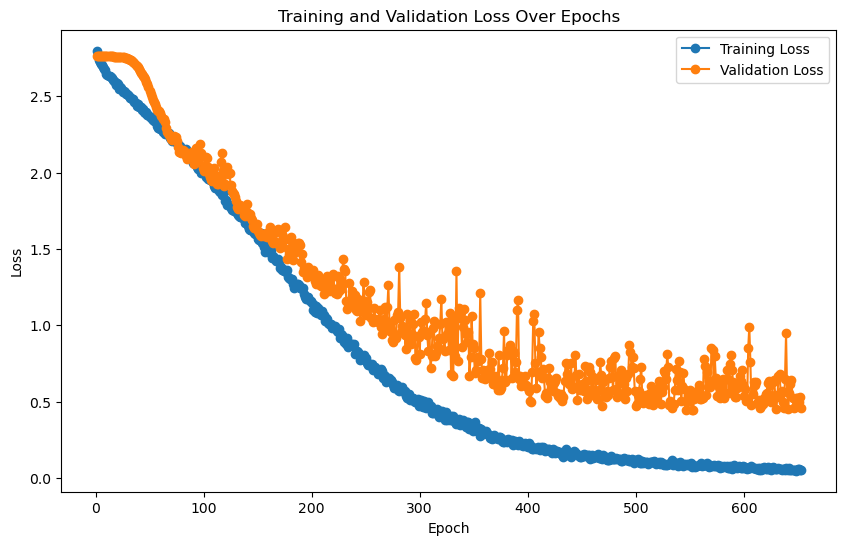

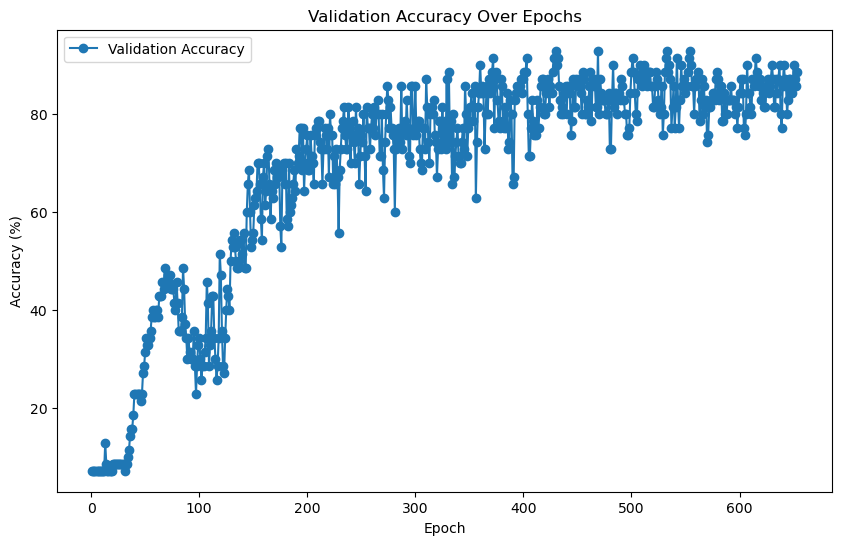


Evaluating on the test set...
    Test Batch [1/38], Loss: 2.0566

Final Test Loss: 0.8015, Test Accuracy: 78.52%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/38 for test dataset.


  Processed batch 20/38 for test dataset.
  Processed batch 30/38 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 9571 samples with 64 features each
LOG: Labels shape: (9571,)

LOG: Training features shape: (320, 64), Training labels shape: (320,)
LOG: Validation features shape: (70, 64), Validation labels shape: (70,)
LOG: Test features shape: (9571, 64), Test labels shape: (9571,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 60.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       1.00      0.60      0.75         5
           2       0.50      0.40      0.44         5
           3       0.75      0.60      0.67         5
           4       0.40      0.40      0.40         5
           5       0.67      0.80      0.73         5
           7       0.50      0.40      0.44         5
           8       0.00      0.00      0.00         0
           9       0.40      0.40  

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_clas

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 9571 samples with 64 features each
LOG: Labels shape: (9571,)
Train reps shape: (320, 64)
Train labels shape: (320,)
Val reps shape: (70, 64)
Val labels shape: (70,)
Test reps shape: (9571, 64)
Test labels shape: (9571,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.9447  |  Val Loss: 2.7325
Validation loss improved from inf to 2.7325.
[Epoch 2/1000] Train Loss: 2.7173  |  Val Loss: 2.6653
Validation loss improved from 2.7325 to 2.6653.
[Epoch 3/1000] Train Loss: 2.6578  |  Val Loss: 2.6109
Validation loss improved from 2.6653 to 2.6109.
[Epoch 4/1000] Train Loss: 2.5934  |  Val Loss: 2.5592
Validation loss improved from 2.6109 to 2.5592.
[Epoch 5/1000] Train Loss: 2.5323  |  Val Loss: 2.4991
Validation loss improved from 2.5592 to 2.4991.
[Epoch 6/1000] Train Loss: 2.4716  |  Val Loss: 2.4369
Validation loss improved from 2.4991 to 2.4369.
[Epoch 7/1000] Train Loss: 2.4176  |  Val Loss: 2.3827
Validation loss improved from 2.4369 to 2.3827.
[Epoch 8/1000] Train Loss: 2.3615  |  Val Loss: 2.3285
Validation loss improved from 2.3827 to 2.3285.
[Epoch 9/1000] Train Loss: 2.3017  |  Val Loss: 2.2596
Validation loss improved from 2.3285 to 2.2596.
[Epoch 10/1000] Train Loss: 2.2402  |  Val Loss: 2.2178
Validation loss impr

[Epoch 14/1000] Train Loss: 1.9792  |  Val Loss: 1.9824
Validation loss improved from 2.0534 to 1.9824.
[Epoch 15/1000] Train Loss: 1.9141  |  Val Loss: 1.9311
Validation loss improved from 1.9824 to 1.9311.
[Epoch 16/1000] Train Loss: 1.8422  |  Val Loss: 1.9001
Validation loss improved from 1.9311 to 1.9001.
[Epoch 17/1000] Train Loss: 1.7746  |  Val Loss: 1.8515
Validation loss improved from 1.9001 to 1.8515.
[Epoch 18/1000] Train Loss: 1.7147  |  Val Loss: 1.8014
Validation loss improved from 1.8515 to 1.8014.
[Epoch 19/1000] Train Loss: 1.6608  |  Val Loss: 1.7751
Validation loss improved from 1.8014 to 1.7751.


[Epoch 20/1000] Train Loss: 1.6073  |  Val Loss: 1.7425
Validation loss improved from 1.7751 to 1.7425.
[Epoch 21/1000] Train Loss: 1.5530  |  Val Loss: 1.6933
Validation loss improved from 1.7425 to 1.6933.
[Epoch 22/1000] Train Loss: 1.5103  |  Val Loss: 1.6939
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 23/1000] Train Loss: 1.4742  |  Val Loss: 1.6639
Validation loss improved from 1.6933 to 1.6639.
[Epoch 24/1000] Train Loss: 1.4323  |  Val Loss: 1.6396
Validation loss improved from 1.6639 to 1.6396.
[Epoch 25/1000] Train Loss: 1.4044  |  Val Loss: 1.6242
Validation loss improved from 1.6396 to 1.6242.
[Epoch 26/1000] Train Loss: 1.3775  |  Val Loss: 1.5818
Validation loss improved from 1.6242 to 1.5818.
[Epoch 27/1000] Train Loss: 1.3478  |  Val Loss: 1.6104
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 28/1000] Train Loss: 1.3141  |  Val Loss: 1.5802
Validation loss improved from 1.5818 to 1.5802.
[Epoch 29/1000] Train Loss: 1.3043  |  Val Loss: 1.5

[Epoch 34/1000] Train Loss: 1.1951  |  Val Loss: 1.5011
Validation loss improved from 1.5012 to 1.5011.
[Epoch 35/1000] Train Loss: 1.1648  |  Val Loss: 1.4552
Validation loss improved from 1.5011 to 1.4552.
[Epoch 36/1000] Train Loss: 1.1403  |  Val Loss: 1.4470
Validation loss improved from 1.4552 to 1.4470.
[Epoch 37/1000] Train Loss: 1.1292  |  Val Loss: 1.4688
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 38/1000] Train Loss: 1.1049  |  Val Loss: 1.4046
Validation loss improved from 1.4470 to 1.4046.


[Epoch 39/1000] Train Loss: 1.0950  |  Val Loss: 1.4350
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 40/1000] Train Loss: 1.0739  |  Val Loss: 1.3981
Validation loss improved from 1.4046 to 1.3981.
[Epoch 41/1000] Train Loss: 1.0715  |  Val Loss: 1.4033
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 42/1000] Train Loss: 1.0732  |  Val Loss: 1.4123
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 43/1000] Train Loss: 1.0224  |  Val Loss: 1.3657
Validation loss improved from 1.3981 to 1.3657.
[Epoch 44/1000] Train Loss: 1.0208  |  Val Loss: 1.3704
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 45/1000] Train Loss: 0.9977  |  Val Loss: 1.3395
Validation loss improved from 1.3657 to 1.3395.
[Epoch 46/1000] Train Loss: 0.9887  |  Val Loss: 1.3398
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 47/1000] Train Loss: 0.9798  |  Val Loss: 1.3121
Validation loss improved from 1.3395 to 1.3121.
[Epoch 48/1000] Train Loss: 0.9621

[Epoch 53/1000] Train Loss: 0.9003  |  Val Loss: 1.2729
Validation loss improved from 1.2842 to 1.2729.
[Epoch 54/1000] Train Loss: 0.8884  |  Val Loss: 1.2783
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 55/1000] Train Loss: 0.8855  |  Val Loss: 1.2686
Validation loss improved from 1.2729 to 1.2686.
[Epoch 56/1000] Train Loss: 0.8735  |  Val Loss: 1.2773
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 57/1000] Train Loss: 0.8647  |  Val Loss: 1.2469
Validation loss improved from 1.2686 to 1.2469.
[Epoch 58/1000] Train Loss: 0.8586  |  Val Loss: 1.2529
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 59/1000] Train Loss: 0.8544  |  Val Loss: 1.2299
Validation loss improved from 1.2469 to 1.2299.
[Epoch 60/1000] Train Loss: 0.8432  |  Val Loss: 1.2700
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 61/1000] Train Loss: 0.8228  |  Val Loss: 1.2142
Validation loss improved from 1.2299 to 1.2142.
[Epoch 62/1000] Train Loss: 0.8178  |  Val Loss: 1.2492
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 63/1000] Train Loss: 0.8088  |  Val Loss: 1.2250
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 64/1000] Train Loss: 0.7951  |  Val Loss: 1.2161
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 65/1000] Train Loss: 0.7847  |  Val Loss: 1.2239
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 66/1000] Train Loss: 

[Epoch 72/1000] Train Loss: 0.7502  |  Val Loss: 1.1860
Validation loss improved from 1.2011 to 1.1860.
[Epoch 73/1000] Train Loss: 0.7399  |  Val Loss: 1.2340
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 74/1000] Train Loss: 0.7220  |  Val Loss: 1.1784
Validation loss improved from 1.1860 to 1.1784.
[Epoch 75/1000] Train Loss: 0.7248  |  Val Loss: 1.1800
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 76/1000] Train Loss: 0.7204  |  Val Loss: 1.1958
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 77/1000] Train Loss: 0.7091  |  Val Loss: 1.1932
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 78/1000] Train Loss: 0.7256  |  Val Loss: 1.2025
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 79/1000] Train Loss: 0.7322  |  Val Loss: 1.2054
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 80/1000] Train Loss: 0.7136  |  Val Loss: 1.2101
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 81/1000] Train Loss: 0.7206  |  Val Loss: 1.2122
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 82/1000] Train Loss: 0.6939  |  Val Loss: 1.1784
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 83/1000] Train Loss: 0.6830  |  Val Loss: 1.1866
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 84/1000] Train Loss: 0.6735  |  Val Loss: 1.2046
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 85

[Epoch 90/1000] Train Loss: 0.6401  |  Val Loss: 1.1794
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 91/1000] Train Loss: 0.6402  |  Val Loss: 1.1748
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 92/1000] Train Loss: 0.6331  |  Val Loss: 1.1734
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 93/1000] Train Loss: 0.6356  |  Val Loss: 1.1865
!! Validation loss did NOT improve !! Patience: 5/100


[Epoch 94/1000] Train Loss: 0.6218  |  Val Loss: 1.1709
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 95/1000] Train Loss: 0.6201  |  Val Loss: 1.1704
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 96/1000] Train Loss: 0.6117  |  Val Loss: 1.1943
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 97/1000] Train Loss: 0.6136  |  Val Loss: 1.1742
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 98/1000] Train Loss: 0.6067  |  Val Loss: 1.1587
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 99/1000] Train Loss: 0.6008  |  Val Loss: 1.1822
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 100/1000] Train Loss: 0.5995  |  Val Loss: 1.1624
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 101/1000] Train Loss: 0.5873  |  Val Loss: 1.1899
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 102/1000] Train Loss: 0.5779  |  Val Loss: 1.1548
Validation loss improved from 1.1584 to 1.1548.
[Epoch 10

[Epoch 109/1000] Train Loss: 0.5631  |  Val Loss: 1.1866
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 110/1000] Train Loss: 0.5500  |  Val Loss: 1.1649
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 111/1000] Train Loss: 0.5590  |  Val Loss: 1.1789
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 112/1000] Train Loss: 0.5479  |  Val Loss: 1.1747
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 113/1000] Train Loss: 0.5401  |  Val Loss: 1.1794
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 114/1000] Train Loss: 0.5334  |  Val Loss: 1.1530
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 115/1000] Train Loss: 0.5296  |  Val Loss: 1.1830
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 116/1000] Train Loss: 0.5250  |  Val Loss: 1.1815
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 117/1000] Train Loss: 0.5254  |  Val Loss: 1.1715
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 118/1000] Train Loss: 0.5214  |  Val Loss: 1.1880
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 119/1000] Train Loss: 0.5134  |  Val Loss: 1.1809
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 120/1000] Train Loss: 0.5150  |  Val Loss: 1.1714
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 126/1000] Train Loss: 0.4910  |  Val Loss: 1.1640
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 127/1000] Train Loss: 0.4895  |  Val Loss: 1.1633
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 128/1000] Train Loss: 0.4961  |  Val Loss: 1.2181
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 129/1000] Train Loss: 0.4953  |  Val Loss: 1.1908
!! Validation loss did NOT improve !! Patience: 21/100


[Epoch 130/1000] Train Loss: 0.4788  |  Val Loss: 1.2016
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 131/1000] Train Loss: 0.4888  |  Val Loss: 1.2087
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 132/1000] Train Loss: 0.4695  |  Val Loss: 1.2033
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 133/1000] Train Loss: 0.4675  |  Val Loss: 1.2187
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 134/1000] Train Loss: 0.4848  |  Val Loss: 1.1937
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 135/1000] Train Loss: 0.4736  |  Val Loss: 1.2166
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 136/1000] Train Loss: 0.4750  |  Val Loss: 1.1958
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 137/1000] Train Loss: 0.4626  |  Val Loss: 1.2007
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 138/1000] Train Loss: 0.4565  |  Val Loss: 1.1869
!! Validation loss did NOT improve !! Patience:

[Epoch 145/1000] Train Loss: 0.4283  |  Val Loss: 1.2131
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 146/1000] Train Loss: 0.4202  |  Val Loss: 1.1811
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 147/1000] Train Loss: 0.4279  |  Val Loss: 1.2558
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 148/1000] Train Loss: 0.4176  |  Val Loss: 1.2056
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 149/1000] Train Loss: 0.4220  |  Val Loss: 1.2307
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 150/1000] Train Loss: 0.4148  |  Val Loss: 1.2038
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 151/1000] Train Loss: 0.4102  |  Val Loss: 1.2304
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 152/1000] Train Loss: 0.4081  |  Val Loss: 1.2312
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 153/1000] Train Loss: 0.4062  |  Val Loss: 1.2161
!! Validation loss did NOT improve !! Patience:

[Epoch 164/1000] Train Loss: 0.3711  |  Val Loss: 1.2251
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 165/1000] Train Loss: 0.3696  |  Val Loss: 1.2968
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 166/1000] Train Loss: 0.3657  |  Val Loss: 1.2493
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 167/1000] Train Loss: 0.3565  |  Val Loss: 1.2831
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 168/1000] Train Loss: 0.3564  |  Val Loss: 1.2928
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 169/1000] Train Loss: 0.3529  |  Val Loss: 1.2372
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 170/1000] Train Loss: 0.3539  |  Val Loss: 1.2988
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 171/1000] Train Loss: 0.3436  |  Val Loss: 1.2678
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 172/1000] Train Loss: 0.3448  |  Val Loss: 1.2828
!! Validation loss did NOT improve !! Patience:

[Epoch 183/1000] Train Loss: 0.3168  |  Val Loss: 1.3503
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 184/1000] Train Loss: 0.3186  |  Val Loss: 1.3359
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 185/1000] Train Loss: 0.3096  |  Val Loss: 1.3144
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 186/1000] Train Loss: 0.3096  |  Val Loss: 1.3570
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 187/1000] Train Loss: 0.3121  |  Val Loss: 1.3540
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 188/1000] Train Loss: 0.3128  |  Val Loss: 1.3515
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 189/1000] Train Loss: 0.3215  |  Val Loss: 1.3506
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 190/1000] Train Loss: 0.3082  |  Val Loss: 1.3603
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 191/1000] Train Loss: 0.3022  |  Val Loss: 1.3651
!! Validation loss did NOT improve !! Patience:

[Epoch 201/1000] Train Loss: 0.2762  |  Val Loss: 1.4319
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 202/1000] Train Loss: 0.2838  |  Val Loss: 1.4423
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 203/1000] Train Loss: 0.2873  |  Val Loss: 1.4077
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 204/1000] Train Loss: 0.2768  |  Val Loss: 1.4567
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 205/1000] Train Loss: 0.2785  |  Val Loss: 1.4297
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 206/1000] Train Loss: 0.2781  |  Val Loss: 1.4472
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 207/1000] Train Loss: 0.2724  |  Val Loss: 1.3897
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 208/1000] Train Loss: 0.2789  |  Val Loss: 1.4862
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 208 !!
No improvement for 100 epochs.


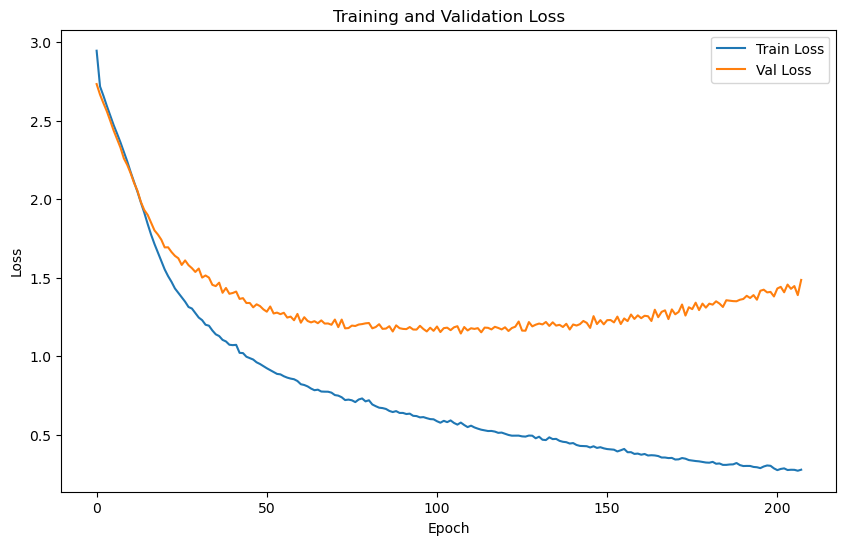

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 2.1825 | Test Accuracy: 52.16%


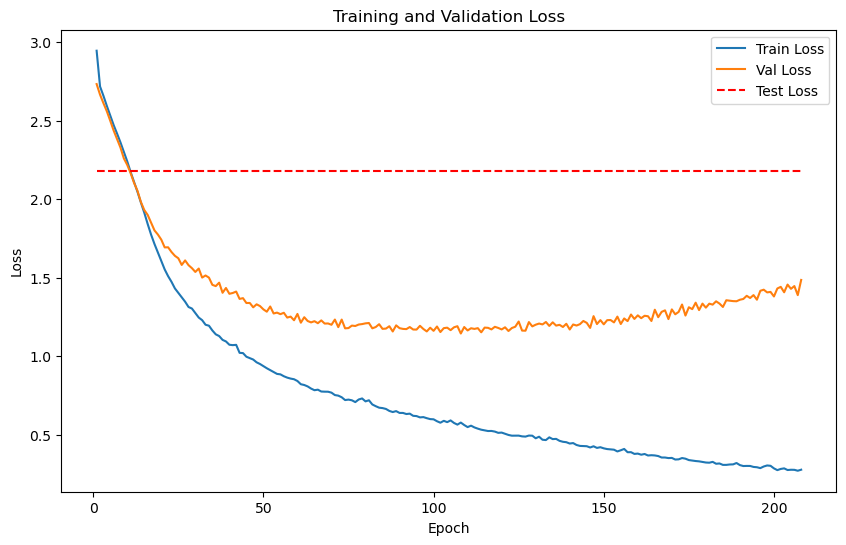

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 9571 samples with 64 features each
LOG: Labels shape: (9571,)


Train embeddings shape: (320, 64), 
Train labels shape: (320,)


Val embeddings shape: (70, 64), 
Val labels shape: (70,)


Test embeddings shape: (9571, 64), 
Test labels shape: (9571,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}
Training batch size: 320


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 8.8461
Epoch [1/2000], Avg Train Loss: 8.8461
Epoch [1/2000], Avg Val Loss: 5.1420
Validation loss improved from inf to 5.1420. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 8.8268
Epoch [2/2000], Avg Train Loss: 8.8268
Epoch [2/2000], Avg Val Loss: 5.0882
Validation loss improved from 5.1420 to 5.0882. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.6810
Epoch [3/2000], Avg Train Loss: 8.6810
Epoch [3/2000], Avg Val Loss: 5.0360
Validation loss improved from 5.0882 to 5.0360. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 8.7175
Epoch [4/2000], Avg Train Loss: 8.7175
Epoch [4/2000], Avg Val Loss: 4.9852
Validation loss improved from 5.0360 to 4.9852. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 8.6204
Epoch [5/2000], Avg Train Loss: 8.6204
Epoch [5/2000], Avg Val Loss: 4.9359
Validation loss improved from 4.9852 to 4.9359. Saving mode

    Batch [1/1], Train Loss: 8.1010
Epoch [11/2000], Avg Train Loss: 8.1010
Epoch [11/2000], Avg Val Loss: 4.6640
Validation loss improved from 4.7063 to 4.6640. Saving model...

LOG: Epoch [12/2000] - Training
    Batch [1/1], Train Loss: 8.0087
Epoch [12/2000], Avg Train Loss: 8.0087
Epoch [12/2000], Avg Val Loss: 4.6226
Validation loss improved from 4.6640 to 4.6226. Saving model...

LOG: Epoch [13/2000] - Training
    Batch [1/1], Train Loss: 7.9809
Epoch [13/2000], Avg Train Loss: 7.9809
Epoch [13/2000], Avg Val Loss: 4.5824
Validation loss improved from 4.6226 to 4.5824. Saving model...

LOG: Epoch [14/2000] - Training
    Batch [1/1], Train Loss: 7.9195
Epoch [14/2000], Avg Train Loss: 7.9195
Epoch [14/2000], Avg Val Loss: 4.5432
Validation loss improved from 4.5824 to 4.5432. Saving model...

LOG: Epoch [15/2000] - Training
    Batch [1/1], Train Loss: 7.7532
Epoch [15/2000], Avg Train Loss: 7.7532
Epoch [15/2000], Avg Val Loss: 4.5053
Validation loss improved from 4.5432 to 4.

    Batch [1/1], Train Loss: 7.7361
Epoch [16/2000], Avg Train Loss: 7.7361
Epoch [16/2000], Avg Val Loss: 4.4684
Validation loss improved from 4.5053 to 4.4684. Saving model...

LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 7.6908
Epoch [17/2000], Avg Train Loss: 7.6908
Epoch [17/2000], Avg Val Loss: 4.4324
Validation loss improved from 4.4684 to 4.4324. Saving model...

LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 7.6825
Epoch [18/2000], Avg Train Loss: 7.6825
Epoch [18/2000], Avg Val Loss: 4.3974
Validation loss improved from 4.4324 to 4.3974. Saving model...

LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 7.6617
Epoch [19/2000], Avg Train Loss: 7.6617
Epoch [19/2000], Avg Val Loss: 4.3635
Validation loss improved from 4.3974 to 4.3635. Saving model...

LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 7.4705
Epoch [20/2000], Avg Train Loss: 7.4705
Epoch [20/2000], Avg Val Loss: 4.3307
Validation loss improved from 4.3635 to 4.

    Batch [1/1], Train Loss: 7.4048
Epoch [23/2000], Avg Train Loss: 7.4048
Epoch [23/2000], Avg Val Loss: 4.2382
Validation loss improved from 4.2680 to 4.2382. Saving model...

LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 7.2635
Epoch [24/2000], Avg Train Loss: 7.2635
Epoch [24/2000], Avg Val Loss: 4.2095
Validation loss improved from 4.2382 to 4.2095. Saving model...

LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 7.2243
Epoch [25/2000], Avg Train Loss: 7.2243
Epoch [25/2000], Avg Val Loss: 4.1817
Validation loss improved from 4.2095 to 4.1817. Saving model...

LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 7.1584
Epoch [26/2000], Avg Train Loss: 7.1584
Epoch [26/2000], Avg Val Loss: 4.1549
Validation loss improved from 4.1817 to 4.1549. Saving model...

LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 7.0812
Epoch [27/2000], Avg Train Loss: 7.0812
Epoch [27/2000], Avg Val Loss: 4.1291
Validation loss improved from 4.1549 to 4.

    Batch [1/1], Train Loss: 6.7237
Epoch [36/2000], Avg Train Loss: 6.7237
Epoch [36/2000], Avg Val Loss: 3.9338
Validation loss improved from 3.9525 to 3.9338. Saving model...

LOG: Epoch [37/2000] - Training
    Batch [1/1], Train Loss: 6.5715
Epoch [37/2000], Avg Train Loss: 6.5715
Epoch [37/2000], Avg Val Loss: 3.9157
Validation loss improved from 3.9338 to 3.9157. Saving model...

LOG: Epoch [38/2000] - Training
    Batch [1/1], Train Loss: 6.6045
Epoch [38/2000], Avg Train Loss: 6.6045
Epoch [38/2000], Avg Val Loss: 3.8984
Validation loss improved from 3.9157 to 3.8984. Saving model...

LOG: Epoch [39/2000] - Training
    Batch [1/1], Train Loss: 6.5642
Epoch [39/2000], Avg Train Loss: 6.5642
Epoch [39/2000], Avg Val Loss: 3.8817
Validation loss improved from 3.8984 to 3.8817. Saving model...

LOG: Epoch [40/2000] - Training
    Batch [1/1], Train Loss: 6.4529
Epoch [40/2000], Avg Train Loss: 6.4529
Epoch [40/2000], Avg Val Loss: 3.8657
Validation loss improved from 3.8817 to 3.

    Batch [1/1], Train Loss: 6.3052
Epoch [46/2000], Avg Train Loss: 6.3052
Epoch [46/2000], Avg Val Loss: 3.7814
Validation loss improved from 3.7940 to 3.7814. Saving model...

LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 6.3577
Epoch [47/2000], Avg Train Loss: 6.3577
Epoch [47/2000], Avg Val Loss: 3.7692
Validation loss improved from 3.7814 to 3.7692. Saving model...

LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 6.2195
Epoch [48/2000], Avg Train Loss: 6.2195
Epoch [48/2000], Avg Val Loss: 3.7575
Validation loss improved from 3.7692 to 3.7575. Saving model...

LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 6.1989
Epoch [49/2000], Avg Train Loss: 6.1989
Epoch [49/2000], Avg Val Loss: 3.7463
Validation loss improved from 3.7575 to 3.7463. Saving model...

LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 6.2593
Epoch [50/2000], Avg Train Loss: 6.2593
Epoch [50/2000], Avg Val Loss: 3.7355
Validation loss improved from 3.7463 to 3.

    Batch [1/1], Train Loss: 5.9674
Epoch [59/2000], Avg Train Loss: 5.9674
Epoch [59/2000], Avg Val Loss: 3.6560
Validation loss improved from 3.6635 to 3.6560. Saving model...

LOG: Epoch [60/2000] - Training
    Batch [1/1], Train Loss: 5.9475
Epoch [60/2000], Avg Train Loss: 5.9475
Epoch [60/2000], Avg Val Loss: 3.6488
Validation loss improved from 3.6560 to 3.6488. Saving model...

LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 5.9625
Epoch [61/2000], Avg Train Loss: 5.9625
Epoch [61/2000], Avg Val Loss: 3.6420
Validation loss improved from 3.6488 to 3.6420. Saving model...

LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 5.9067
Epoch [62/2000], Avg Train Loss: 5.9067
Epoch [62/2000], Avg Val Loss: 3.6354
Validation loss improved from 3.6420 to 3.6354. Saving model...

LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 5.8496
Epoch [63/2000], Avg Train Loss: 5.8496
Epoch [63/2000], Avg Val Loss: 3.6291
Validation loss improved from 3.6354 to 3.

Epoch [70/2000], Avg Val Loss: 3.5908
Validation loss improved from 3.5957 to 3.5908. Saving model...

LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 5.7525
Epoch [71/2000], Avg Train Loss: 5.7525
Epoch [71/2000], Avg Val Loss: 3.5861
Validation loss improved from 3.5908 to 3.5861. Saving model...

LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 5.7941
Epoch [72/2000], Avg Train Loss: 5.7941
Epoch [72/2000], Avg Val Loss: 3.5815
Validation loss improved from 3.5861 to 3.5815. Saving model...

LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 5.7416
Epoch [73/2000], Avg Train Loss: 5.7416
Epoch [73/2000], Avg Val Loss: 3.5771
Validation loss improved from 3.5815 to 3.5771. Saving model...

LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 5.7353
Epoch [74/2000], Avg Train Loss: 5.7353
Epoch [74/2000], Avg Val Loss: 3.5730
Validation loss improved from 3.5771 to 3.5730. Saving model...

LOG: Epoch [75/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 5.6512
Epoch [80/2000], Avg Train Loss: 5.6512
Epoch [80/2000], Avg Val Loss: 3.5510
Validation loss improved from 3.5543 to 3.5510. Saving model...

LOG: Epoch [81/2000] - Training
    Batch [1/1], Train Loss: 5.6072
Epoch [81/2000], Avg Train Loss: 5.6072
Epoch [81/2000], Avg Val Loss: 3.5477
Validation loss improved from 3.5510 to 3.5477. Saving model...

LOG: Epoch [82/2000] - Training
    Batch [1/1], Train Loss: 5.6426
Epoch [82/2000], Avg Train Loss: 5.6426
Epoch [82/2000], Avg Val Loss: 3.5446
Validation loss improved from 3.5477 to 3.5446. Saving model...

LOG: Epoch [83/2000] - Training
    Batch [1/1], Train Loss: 5.6602
Epoch [83/2000], Avg Train Loss: 5.6602
Epoch [83/2000], Avg Val Loss: 3.5415
Validation loss improved from 3.5446 to 3.5415. Saving model...

LOG: Epoch [84/2000] - Training
    Batch [1/1], Train Loss: 5.6537
Epoch [84/2000], Avg Train Loss: 5.6537
Epoch [84/2000], Avg Val Loss: 3.5386
Validation loss improved from 3.5415 to 3.

    Batch [1/1], Train Loss: 5.5672
Epoch [90/2000], Avg Train Loss: 5.5672
Epoch [90/2000], Avg Val Loss: 3.5224
Validation loss improved from 3.5249 to 3.5224. Saving model...

LOG: Epoch [91/2000] - Training
    Batch [1/1], Train Loss: 5.5096
Epoch [91/2000], Avg Train Loss: 5.5096
Epoch [91/2000], Avg Val Loss: 3.5199
Validation loss improved from 3.5224 to 3.5199. Saving model...

LOG: Epoch [92/2000] - Training
    Batch [1/1], Train Loss: 5.5409
Epoch [92/2000], Avg Train Loss: 5.5409
Epoch [92/2000], Avg Val Loss: 3.5175
Validation loss improved from 3.5199 to 3.5175. Saving model...

LOG: Epoch [93/2000] - Training
    Batch [1/1], Train Loss: 5.4919
Epoch [93/2000], Avg Train Loss: 5.4919
Epoch [93/2000], Avg Val Loss: 3.5152
Validation loss improved from 3.5175 to 3.5152. Saving model...

LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 5.5052
Epoch [94/2000], Avg Train Loss: 5.5052
Epoch [94/2000], Avg Val Loss: 3.5129
Validation loss improved from 3.5152 to 3.

    Batch [1/1], Train Loss: 5.4730
Epoch [105/2000], Avg Train Loss: 5.4730
Epoch [105/2000], Avg Val Loss: 3.4905
Validation loss improved from 3.4924 to 3.4905. Saving model...

LOG: Epoch [106/2000] - Training
    Batch [1/1], Train Loss: 5.4523
Epoch [106/2000], Avg Train Loss: 5.4523
Epoch [106/2000], Avg Val Loss: 3.4887
Validation loss improved from 3.4905 to 3.4887. Saving model...

LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 5.4237
Epoch [107/2000], Avg Train Loss: 5.4237
Epoch [107/2000], Avg Val Loss: 3.4869
Validation loss improved from 3.4887 to 3.4869. Saving model...

LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 5.4032
Epoch [108/2000], Avg Train Loss: 5.4032
Epoch [108/2000], Avg Val Loss: 3.4851
Validation loss improved from 3.4869 to 3.4851. Saving model...

LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 5.4143
Epoch [109/2000], Avg Train Loss: 5.4143
Epoch [109/2000], Avg Val Loss: 3.4834
Validation loss improved fro

    Batch [1/1], Train Loss: 5.3726
Epoch [115/2000], Avg Train Loss: 5.3726
Epoch [115/2000], Avg Val Loss: 3.4734
Validation loss improved from 3.4750 to 3.4734. Saving model...

LOG: Epoch [116/2000] - Training
    Batch [1/1], Train Loss: 5.3576
Epoch [116/2000], Avg Train Loss: 5.3576
Epoch [116/2000], Avg Val Loss: 3.4718
Validation loss improved from 3.4734 to 3.4718. Saving model...

LOG: Epoch [117/2000] - Training
    Batch [1/1], Train Loss: 5.3485
Epoch [117/2000], Avg Train Loss: 5.3485
Epoch [117/2000], Avg Val Loss: 3.4702
Validation loss improved from 3.4718 to 3.4702. Saving model...

LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 5.4024
Epoch [118/2000], Avg Train Loss: 5.4024
Epoch [118/2000], Avg Val Loss: 3.4686
Validation loss improved from 3.4702 to 3.4686. Saving model...

LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 5.3469
Epoch [119/2000], Avg Train Loss: 5.3469
Epoch [119/2000], Avg Val Loss: 3.4671
Validation loss improved fro

Epoch [123/2000], Avg Val Loss: 3.4613
Validation loss improved from 3.4627 to 3.4613. Saving model...

LOG: Epoch [124/2000] - Training
    Batch [1/1], Train Loss: 5.3637
Epoch [124/2000], Avg Train Loss: 5.3637
Epoch [124/2000], Avg Val Loss: 3.4598
Validation loss improved from 3.4613 to 3.4598. Saving model...

LOG: Epoch [125/2000] - Training
    Batch [1/1], Train Loss: 5.3071
Epoch [125/2000], Avg Train Loss: 5.3071
Epoch [125/2000], Avg Val Loss: 3.4584
Validation loss improved from 3.4598 to 3.4584. Saving model...

LOG: Epoch [126/2000] - Training
    Batch [1/1], Train Loss: 5.3191
Epoch [126/2000], Avg Train Loss: 5.3191
Epoch [126/2000], Avg Val Loss: 3.4570
Validation loss improved from 3.4584 to 3.4570. Saving model...

LOG: Epoch [127/2000] - Training
    Batch [1/1], Train Loss: 5.3074
Epoch [127/2000], Avg Train Loss: 5.3074
Epoch [127/2000], Avg Val Loss: 3.4557
Validation loss improved from 3.4570 to 3.4557. Saving model...

LOG: Epoch [128/2000] - Training
    Bat

    Batch [1/1], Train Loss: 5.2227
Epoch [144/2000], Avg Train Loss: 5.2227
Epoch [144/2000], Avg Val Loss: 3.4350
Validation loss improved from 3.4361 to 3.4350. Saving model...

LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 5.2314
Epoch [145/2000], Avg Train Loss: 5.2314
Epoch [145/2000], Avg Val Loss: 3.4339
Validation loss improved from 3.4350 to 3.4339. Saving model...

LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 5.2281
Epoch [146/2000], Avg Train Loss: 5.2281
Epoch [146/2000], Avg Val Loss: 3.4328
Validation loss improved from 3.4339 to 3.4328. Saving model...

LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 5.2390
Epoch [147/2000], Avg Train Loss: 5.2390
Epoch [147/2000], Avg Val Loss: 3.4317
Validation loss improved from 3.4328 to 3.4317. Saving model...

LOG: Epoch [148/2000] - Training
    Batch [1/1], Train Loss: 5.2520
Epoch [148/2000], Avg Train Loss: 5.2520
Epoch [148/2000], Avg Val Loss: 3.4306
Validation loss improved fro

    Batch [1/1], Train Loss: 5.1839
Epoch [149/2000], Avg Train Loss: 5.1839
Epoch [149/2000], Avg Val Loss: 3.4295
Validation loss improved from 3.4306 to 3.4295. Saving model...

LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 5.1964
Epoch [150/2000], Avg Train Loss: 5.1964
Epoch [150/2000], Avg Val Loss: 3.4284
Validation loss improved from 3.4295 to 3.4284. Saving model...

LOG: Epoch [151/2000] - Training
    Batch [1/1], Train Loss: 5.2281
Epoch [151/2000], Avg Train Loss: 5.2281
Epoch [151/2000], Avg Val Loss: 3.4274
Validation loss improved from 3.4284 to 3.4274. Saving model...

LOG: Epoch [152/2000] - Training
    Batch [1/1], Train Loss: 5.2509
Epoch [152/2000], Avg Train Loss: 5.2509
Epoch [152/2000], Avg Val Loss: 3.4263
Validation loss improved from 3.4274 to 3.4263. Saving model...

LOG: Epoch [153/2000] - Training
    Batch [1/1], Train Loss: 5.1990
Epoch [153/2000], Avg Train Loss: 5.1990
Epoch [153/2000], Avg Val Loss: 3.4253
Validation loss improved fro

Epoch [159/2000], Avg Val Loss: 3.4195
Validation loss improved from 3.4204 to 3.4195. Saving model...

LOG: Epoch [160/2000] - Training
    Batch [1/1], Train Loss: 5.1798
Epoch [160/2000], Avg Train Loss: 5.1798
Epoch [160/2000], Avg Val Loss: 3.4185
Validation loss improved from 3.4195 to 3.4185. Saving model...

LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 5.2467
Epoch [161/2000], Avg Train Loss: 5.2467
Epoch [161/2000], Avg Val Loss: 3.4176
Validation loss improved from 3.4185 to 3.4176. Saving model...

LOG: Epoch [162/2000] - Training
    Batch [1/1], Train Loss: 5.1748
Epoch [162/2000], Avg Train Loss: 5.1748
Epoch [162/2000], Avg Val Loss: 3.4167
Validation loss improved from 3.4176 to 3.4167. Saving model...

LOG: Epoch [163/2000] - Training
    Batch [1/1], Train Loss: 5.1668
Epoch [163/2000], Avg Train Loss: 5.1668
Epoch [163/2000], Avg Val Loss: 3.4157
Validation loss improved from 3.4167 to 3.4157. Saving model...

LOG: Epoch [164/2000] - Training
    Bat

    Batch [1/1], Train Loss: 5.1199
Epoch [180/2000], Avg Train Loss: 5.1199
Epoch [180/2000], Avg Val Loss: 3.4019
Validation loss improved from 3.4027 to 3.4019. Saving model...

LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 5.1023
Epoch [181/2000], Avg Train Loss: 5.1023
Epoch [181/2000], Avg Val Loss: 3.4012
Validation loss improved from 3.4019 to 3.4012. Saving model...

LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 5.1279
Epoch [182/2000], Avg Train Loss: 5.1279
Epoch [182/2000], Avg Val Loss: 3.4005
Validation loss improved from 3.4012 to 3.4005. Saving model...

LOG: Epoch [183/2000] - Training
    Batch [1/1], Train Loss: 5.1355
Epoch [183/2000], Avg Train Loss: 5.1355
Epoch [183/2000], Avg Val Loss: 3.3998
Validation loss improved from 3.4005 to 3.3998. Saving model...

LOG: Epoch [184/2000] - Training
    Batch [1/1], Train Loss: 5.1310
Epoch [184/2000], Avg Train Loss: 5.1310
Epoch [184/2000], Avg Val Loss: 3.3990
Validation loss improved fro

    Batch [1/1], Train Loss: 5.1219
Epoch [194/2000], Avg Train Loss: 5.1219
Epoch [194/2000], Avg Val Loss: 3.3924
Validation loss improved from 3.3931 to 3.3924. Saving model...

LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 5.0929
Epoch [195/2000], Avg Train Loss: 5.0929
Epoch [195/2000], Avg Val Loss: 3.3918
Validation loss improved from 3.3924 to 3.3918. Saving model...

LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 5.0927
Epoch [196/2000], Avg Train Loss: 5.0927
Epoch [196/2000], Avg Val Loss: 3.3911
Validation loss improved from 3.3918 to 3.3911. Saving model...

LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 5.0636
Epoch [197/2000], Avg Train Loss: 5.0636
Epoch [197/2000], Avg Val Loss: 3.3904
Validation loss improved from 3.3911 to 3.3904. Saving model...

LOG: Epoch [198/2000] - Training
    Batch [1/1], Train Loss: 5.0510
Epoch [198/2000], Avg Train Loss: 5.0510
Epoch [198/2000], Avg Val Loss: 3.3898
Validation loss improved fro

    Batch [1/1], Train Loss: 5.0187
Epoch [213/2000], Avg Train Loss: 5.0187
Epoch [213/2000], Avg Val Loss: 3.3801
Validation loss improved from 3.3807 to 3.3801. Saving model...

LOG: Epoch [214/2000] - Training
    Batch [1/1], Train Loss: 5.0719
Epoch [214/2000], Avg Train Loss: 5.0719
Epoch [214/2000], Avg Val Loss: 3.3795
Validation loss improved from 3.3801 to 3.3795. Saving model...

LOG: Epoch [215/2000] - Training
    Batch [1/1], Train Loss: 5.0357
Epoch [215/2000], Avg Train Loss: 5.0357
Epoch [215/2000], Avg Val Loss: 3.3789
Validation loss improved from 3.3795 to 3.3789. Saving model...

LOG: Epoch [216/2000] - Training
    Batch [1/1], Train Loss: 5.0442
Epoch [216/2000], Avg Train Loss: 5.0442
Epoch [216/2000], Avg Val Loss: 3.3783
Validation loss improved from 3.3789 to 3.3783. Saving model...

LOG: Epoch [217/2000] - Training
    Batch [1/1], Train Loss: 5.0357
Epoch [217/2000], Avg Train Loss: 5.0357
Epoch [217/2000], Avg Val Loss: 3.3777
Validation loss improved fro

    Batch [1/1], Train Loss: 5.0154
Epoch [227/2000], Avg Train Loss: 5.0154
Epoch [227/2000], Avg Val Loss: 3.3726
Validation loss improved from 3.3731 to 3.3726. Saving model...

LOG: Epoch [228/2000] - Training
    Batch [1/1], Train Loss: 5.0268
Epoch [228/2000], Avg Train Loss: 5.0268
Epoch [228/2000], Avg Val Loss: 3.3722
Validation loss improved from 3.3726 to 3.3722. Saving model...

LOG: Epoch [229/2000] - Training
    Batch [1/1], Train Loss: 5.0098
Epoch [229/2000], Avg Train Loss: 5.0098
Epoch [229/2000], Avg Val Loss: 3.3718
Validation loss improved from 3.3722 to 3.3718. Saving model...

LOG: Epoch [230/2000] - Training
    Batch [1/1], Train Loss: 4.9934
Epoch [230/2000], Avg Train Loss: 4.9934
Epoch [230/2000], Avg Val Loss: 3.3714
Validation loss improved from 3.3718 to 3.3714. Saving model...

LOG: Epoch [231/2000] - Training
    Batch [1/1], Train Loss: 4.9872
Epoch [231/2000], Avg Train Loss: 4.9872
Epoch [231/2000], Avg Val Loss: 3.3710
Validation loss improved fro

Epoch [245/2000], Avg Val Loss: 3.3663
Validation loss improved from 3.3666 to 3.3663. Saving model...

LOG: Epoch [246/2000] - Training
    Batch [1/1], Train Loss: 4.9697
Epoch [246/2000], Avg Train Loss: 4.9697
Epoch [246/2000], Avg Val Loss: 3.3660
Validation loss improved from 3.3663 to 3.3660. Saving model...

LOG: Epoch [247/2000] - Training
    Batch [1/1], Train Loss: 4.9506
Epoch [247/2000], Avg Train Loss: 4.9506
Epoch [247/2000], Avg Val Loss: 3.3657
Validation loss improved from 3.3660 to 3.3657. Saving model...

LOG: Epoch [248/2000] - Training
    Batch [1/1], Train Loss: 4.9504
Epoch [248/2000], Avg Train Loss: 4.9504
Epoch [248/2000], Avg Val Loss: 3.3654
Validation loss improved from 3.3657 to 3.3654. Saving model...

LOG: Epoch [249/2000] - Training
    Batch [1/1], Train Loss: 4.9844
Epoch [249/2000], Avg Train Loss: 4.9844
Epoch [249/2000], Avg Val Loss: 3.3651
Validation loss improved from 3.3654 to 3.3651. Saving model...

LOG: Epoch [250/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.9792
Epoch [262/2000], Avg Train Loss: 4.9792
Epoch [262/2000], Avg Val Loss: 3.3615
Validation loss improved from 3.3617 to 3.3615. Saving model...

LOG: Epoch [263/2000] - Training
    Batch [1/1], Train Loss: 4.9300
Epoch [263/2000], Avg Train Loss: 4.9300
Epoch [263/2000], Avg Val Loss: 3.3612
Validation loss improved from 3.3615 to 3.3612. Saving model...

LOG: Epoch [264/2000] - Training
    Batch [1/1], Train Loss: 4.9290
Epoch [264/2000], Avg Train Loss: 4.9290
Epoch [264/2000], Avg Val Loss: 3.3609
Validation loss improved from 3.3612 to 3.3609. Saving model...

LOG: Epoch [265/2000] - Training
    Batch [1/1], Train Loss: 4.9332
Epoch [265/2000], Avg Train Loss: 4.9332
Epoch [265/2000], Avg Val Loss: 3.3607
Validation loss improved from 3.3609 to 3.3607. Saving model...

LOG: Epoch [266/2000] - Training
    Batch [1/1], Train Loss: 4.9169
Epoch [266/2000], Avg Train Loss: 4.9169
Epoch [266/2000], Avg Val Loss: 3.3604
Validation loss improved fro

    Batch [1/1], Train Loss: 4.9204
Epoch [285/2000], Avg Train Loss: 4.9204
Epoch [285/2000], Avg Val Loss: 3.3560
Validation loss improved from 3.3562 to 3.3560. Saving model...

LOG: Epoch [286/2000] - Training
    Batch [1/1], Train Loss: 4.9208
Epoch [286/2000], Avg Train Loss: 4.9208
Epoch [286/2000], Avg Val Loss: 3.3558
Validation loss improved from 3.3560 to 3.3558. Saving model...

LOG: Epoch [287/2000] - Training
    Batch [1/1], Train Loss: 4.9189
Epoch [287/2000], Avg Train Loss: 4.9189
Epoch [287/2000], Avg Val Loss: 3.3555
Validation loss improved from 3.3558 to 3.3555. Saving model...

LOG: Epoch [288/2000] - Training
    Batch [1/1], Train Loss: 4.9141
Epoch [288/2000], Avg Train Loss: 4.9141
Epoch [288/2000], Avg Val Loss: 3.3553
Validation loss improved from 3.3555 to 3.3553. Saving model...

LOG: Epoch [289/2000] - Training
    Batch [1/1], Train Loss: 4.9138
Epoch [289/2000], Avg Train Loss: 4.9138
Epoch [289/2000], Avg Val Loss: 3.3551
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8824
Epoch [298/2000], Avg Train Loss: 4.8824
Epoch [298/2000], Avg Val Loss: 3.3537
Validation loss improved from 3.3538 to 3.3537. Saving model...

LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 4.9166
Epoch [299/2000], Avg Train Loss: 4.9166
Epoch [299/2000], Avg Val Loss: 3.3536
Validation loss improved from 3.3537 to 3.3536. Saving model...

LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 4.8657
Epoch [300/2000], Avg Train Loss: 4.8657
Epoch [300/2000], Avg Val Loss: 3.3534
Validation loss improved from 3.3536 to 3.3534. Saving model...

LOG: Epoch [301/2000] - Training
    Batch [1/1], Train Loss: 4.8679
Epoch [301/2000], Avg Train Loss: 4.8679
Epoch [301/2000], Avg Val Loss: 3.3533
Validation loss improved from 3.3534 to 3.3533. Saving model...

LOG: Epoch [302/2000] - Training
    Batch [1/1], Train Loss: 4.9172
Epoch [302/2000], Avg Train Loss: 4.9172
Epoch [302/2000], Avg Val Loss: 3.3532
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8420
Epoch [323/2000], Avg Train Loss: 4.8420
Epoch [323/2000], Avg Val Loss: 3.3502
Validation loss improved from 3.3503 to 3.3502. Saving model...

LOG: Epoch [324/2000] - Training
    Batch [1/1], Train Loss: 4.8736
Epoch [324/2000], Avg Train Loss: 4.8736
Epoch [324/2000], Avg Val Loss: 3.3501
Validation loss improved from 3.3502 to 3.3501. Saving model...

LOG: Epoch [325/2000] - Training
    Batch [1/1], Train Loss: 4.8321
Epoch [325/2000], Avg Train Loss: 4.8321
Epoch [325/2000], Avg Val Loss: 3.3499
Validation loss improved from 3.3501 to 3.3499. Saving model...

LOG: Epoch [326/2000] - Training
    Batch [1/1], Train Loss: 4.8664
Epoch [326/2000], Avg Train Loss: 4.8664
Epoch [326/2000], Avg Val Loss: 3.3498
Validation loss improved from 3.3499 to 3.3498. Saving model...

LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 4.8699
Epoch [327/2000], Avg Train Loss: 4.8699
Epoch [327/2000], Avg Val Loss: 3.3497
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8387
Epoch [334/2000], Avg Train Loss: 4.8387
Epoch [334/2000], Avg Val Loss: 3.3486
Validation loss improved from 3.3487 to 3.3486. Saving model...

LOG: Epoch [335/2000] - Training
    Batch [1/1], Train Loss: 4.8637
Epoch [335/2000], Avg Train Loss: 4.8637
Epoch [335/2000], Avg Val Loss: 3.3485
Validation loss improved from 3.3486 to 3.3485. Saving model...

LOG: Epoch [336/2000] - Training
    Batch [1/1], Train Loss: 4.8550
Epoch [336/2000], Avg Train Loss: 4.8550
Epoch [336/2000], Avg Val Loss: 3.3483
Validation loss improved from 3.3485 to 3.3483. Saving model...

LOG: Epoch [337/2000] - Training
    Batch [1/1], Train Loss: 4.8578
Epoch [337/2000], Avg Train Loss: 4.8578
Epoch [337/2000], Avg Val Loss: 3.3482
Validation loss improved from 3.3483 to 3.3482. Saving model...

LOG: Epoch [338/2000] - Training
    Batch [1/1], Train Loss: 4.8139
Epoch [338/2000], Avg Train Loss: 4.8139
Epoch [338/2000], Avg Val Loss: 3.3481
Validation loss improved fro

Epoch [360/2000], Avg Val Loss: 3.3446
Validation loss improved from 3.3447 to 3.3446. Saving model...

LOG: Epoch [361/2000] - Training
    Batch [1/1], Train Loss: 4.8218
Epoch [361/2000], Avg Train Loss: 4.8218
Epoch [361/2000], Avg Val Loss: 3.3445
Validation loss improved from 3.3446 to 3.3445. Saving model...

LOG: Epoch [362/2000] - Training
    Batch [1/1], Train Loss: 4.7762
Epoch [362/2000], Avg Train Loss: 4.7762
Epoch [362/2000], Avg Val Loss: 3.3444
Validation loss improved from 3.3445 to 3.3444. Saving model...

LOG: Epoch [363/2000] - Training
    Batch [1/1], Train Loss: 4.7873
Epoch [363/2000], Avg Train Loss: 4.7873
Epoch [363/2000], Avg Val Loss: 3.3443
Validation loss improved from 3.3444 to 3.3443. Saving model...

LOG: Epoch [364/2000] - Training
    Batch [1/1], Train Loss: 4.7853
Epoch [364/2000], Avg Train Loss: 4.7853
Epoch [364/2000], Avg Val Loss: 3.3442
Validation loss improved from 3.3443 to 3.3442. Saving model...

LOG: Epoch [365/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.8029
Epoch [371/2000], Avg Train Loss: 4.8029
Epoch [371/2000], Avg Val Loss: 3.3438
Validation loss improved from 3.3439 to 3.3438. Saving model...

LOG: Epoch [372/2000] - Training
    Batch [1/1], Train Loss: 4.7807
Epoch [372/2000], Avg Train Loss: 4.7807
Epoch [372/2000], Avg Val Loss: 3.3437
Validation loss improved from 3.3438 to 3.3437. Saving model...

LOG: Epoch [373/2000] - Training
    Batch [1/1], Train Loss: 4.8137
Epoch [373/2000], Avg Train Loss: 4.8137
Epoch [373/2000], Avg Val Loss: 3.3436
Validation loss improved from 3.3437 to 3.3436. Saving model...

LOG: Epoch [374/2000] - Training
    Batch [1/1], Train Loss: 4.7981
Epoch [374/2000], Avg Train Loss: 4.7981
Epoch [374/2000], Avg Val Loss: 3.3435
Validation loss improved from 3.3436 to 3.3435. Saving model...

LOG: Epoch [375/2000] - Training
    Batch [1/1], Train Loss: 4.8068
Epoch [375/2000], Avg Train Loss: 4.8068
Epoch [375/2000], Avg Val Loss: 3.3434
Validation loss improved fro

Epoch [396/2000], Avg Val Loss: 3.3414
Validation loss improved from 3.3414 to 3.3414. Saving model...

LOG: Epoch [397/2000] - Training
    Batch [1/1], Train Loss: 4.8089
Epoch [397/2000], Avg Train Loss: 4.8089
Epoch [397/2000], Avg Val Loss: 3.3414
Validation loss improved from 3.3414 to 3.3414. Saving model...

LOG: Epoch [398/2000] - Training
    Batch [1/1], Train Loss: 4.7522
Epoch [398/2000], Avg Train Loss: 4.7522
Epoch [398/2000], Avg Val Loss: 3.3413
Validation loss improved from 3.3414 to 3.3413. Saving model...

LOG: Epoch [399/2000] - Training
    Batch [1/1], Train Loss: 4.7591
Epoch [399/2000], Avg Train Loss: 4.7591
Epoch [399/2000], Avg Val Loss: 3.3413
Validation loss improved from 3.3413 to 3.3413. Saving model...

LOG: Epoch [400/2000] - Training
    Batch [1/1], Train Loss: 4.7723
Epoch [400/2000], Avg Train Loss: 4.7723
Epoch [400/2000], Avg Val Loss: 3.3412
Validation loss improved from 3.3413 to 3.3412. Saving model...

LOG: Epoch [401/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.7645
Epoch [407/2000], Avg Train Loss: 4.7645
Epoch [407/2000], Avg Val Loss: 3.3408
Validation loss improved from 3.3408 to 3.3408. Saving model...

LOG: Epoch [408/2000] - Training
    Batch [1/1], Train Loss: 4.7230
Epoch [408/2000], Avg Train Loss: 4.7230
Epoch [408/2000], Avg Val Loss: 3.3407
Validation loss improved from 3.3408 to 3.3407. Saving model...

LOG: Epoch [409/2000] - Training
    Batch [1/1], Train Loss: 4.7282
Epoch [409/2000], Avg Train Loss: 4.7282
Epoch [409/2000], Avg Val Loss: 3.3406
Validation loss improved from 3.3407 to 3.3406. Saving model...

LOG: Epoch [410/2000] - Training
    Batch [1/1], Train Loss: 4.7608
Epoch [410/2000], Avg Train Loss: 4.7608
Epoch [410/2000], Avg Val Loss: 3.3405
Validation loss improved from 3.3406 to 3.3405. Saving model...

LOG: Epoch [411/2000] - Training
    Batch [1/1], Train Loss: 4.7522
Epoch [411/2000], Avg Train Loss: 4.7522
Epoch [411/2000], Avg Val Loss: 3.3404
Validation loss improved fro

Epoch [434/2000], Avg Val Loss: 3.3393
Validation loss improved from 3.3393 to 3.3393. Saving model...

LOG: Epoch [435/2000] - Training
    Batch [1/1], Train Loss: 4.7260
Epoch [435/2000], Avg Train Loss: 4.7260
Epoch [435/2000], Avg Val Loss: 3.3393
Validation loss did not improve. Patience: 1/100

LOG: Epoch [436/2000] - Training
    Batch [1/1], Train Loss: 4.7451
Epoch [436/2000], Avg Train Loss: 4.7451
Epoch [436/2000], Avg Val Loss: 3.3393
Validation loss did not improve. Patience: 2/100

LOG: Epoch [437/2000] - Training
    Batch [1/1], Train Loss: 4.7340
Epoch [437/2000], Avg Train Loss: 4.7340
Epoch [437/2000], Avg Val Loss: 3.3393
Validation loss did not improve. Patience: 3/100

LOG: Epoch [438/2000] - Training
    Batch [1/1], Train Loss: 4.7209
Epoch [438/2000], Avg Train Loss: 4.7209
Epoch [438/2000], Avg Val Loss: 3.3393
Validation loss did not improve. Patience: 4/100

LOG: Epoch [439/2000] - Training
    Batch [1/1], Train Loss: 4.7320
Epoch [439/2000], Avg Train Los

    Batch [1/1], Train Loss: 4.6999
Epoch [445/2000], Avg Train Loss: 4.6999
Epoch [445/2000], Avg Val Loss: 3.3390
Validation loss improved from 3.3391 to 3.3390. Saving model...

LOG: Epoch [446/2000] - Training
    Batch [1/1], Train Loss: 4.7184
Epoch [446/2000], Avg Train Loss: 4.7184
Epoch [446/2000], Avg Val Loss: 3.3389
Validation loss improved from 3.3390 to 3.3389. Saving model...

LOG: Epoch [447/2000] - Training
    Batch [1/1], Train Loss: 4.6960
Epoch [447/2000], Avg Train Loss: 4.6960
Epoch [447/2000], Avg Val Loss: 3.3388
Validation loss improved from 3.3389 to 3.3388. Saving model...

LOG: Epoch [448/2000] - Training
    Batch [1/1], Train Loss: 4.7315
Epoch [448/2000], Avg Train Loss: 4.7315
Epoch [448/2000], Avg Val Loss: 3.3387
Validation loss improved from 3.3388 to 3.3387. Saving model...

LOG: Epoch [449/2000] - Training
    Batch [1/1], Train Loss: 4.7143
Epoch [449/2000], Avg Train Loss: 4.7143
Epoch [449/2000], Avg Val Loss: 3.3385
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6936
Epoch [473/2000], Avg Train Loss: 4.6936
Epoch [473/2000], Avg Val Loss: 3.3347
Validation loss improved from 3.3349 to 3.3347. Saving model...

LOG: Epoch [474/2000] - Training
    Batch [1/1], Train Loss: 4.7008
Epoch [474/2000], Avg Train Loss: 4.7008
Epoch [474/2000], Avg Val Loss: 3.3345
Validation loss improved from 3.3347 to 3.3345. Saving model...

LOG: Epoch [475/2000] - Training
    Batch [1/1], Train Loss: 4.7304
Epoch [475/2000], Avg Train Loss: 4.7304
Epoch [475/2000], Avg Val Loss: 3.3344
Validation loss improved from 3.3345 to 3.3344. Saving model...

LOG: Epoch [476/2000] - Training
    Batch [1/1], Train Loss: 4.7044
Epoch [476/2000], Avg Train Loss: 4.7044
Epoch [476/2000], Avg Val Loss: 3.3342
Validation loss improved from 3.3344 to 3.3342. Saving model...

LOG: Epoch [477/2000] - Training
    Batch [1/1], Train Loss: 4.6738
Epoch [477/2000], Avg Train Loss: 4.6738
Epoch [477/2000], Avg Val Loss: 3.3340
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6864
Epoch [486/2000], Avg Train Loss: 4.6864
Epoch [486/2000], Avg Val Loss: 3.3328
Validation loss improved from 3.3329 to 3.3328. Saving model...

LOG: Epoch [487/2000] - Training
    Batch [1/1], Train Loss: 4.6667
Epoch [487/2000], Avg Train Loss: 4.6667
Epoch [487/2000], Avg Val Loss: 3.3328
Validation loss improved from 3.3328 to 3.3328. Saving model...

LOG: Epoch [488/2000] - Training
    Batch [1/1], Train Loss: 4.6643
Epoch [488/2000], Avg Train Loss: 4.6643
Epoch [488/2000], Avg Val Loss: 3.3327
Validation loss improved from 3.3328 to 3.3327. Saving model...

LOG: Epoch [489/2000] - Training
    Batch [1/1], Train Loss: 4.6860
Epoch [489/2000], Avg Train Loss: 4.6860
Epoch [489/2000], Avg Val Loss: 3.3327
Validation loss improved from 3.3327 to 3.3327. Saving model...

LOG: Epoch [490/2000] - Training
    Batch [1/1], Train Loss: 4.6592
Epoch [490/2000], Avg Train Loss: 4.6592
Epoch [490/2000], Avg Val Loss: 3.3327
Validation loss did not impr

    Batch [1/1], Train Loss: 4.6886
Epoch [508/2000], Avg Train Loss: 4.6886
Epoch [508/2000], Avg Val Loss: 3.3343
Validation loss did not improve. Patience: 16/100

LOG: Epoch [509/2000] - Training
    Batch [1/1], Train Loss: 4.6419
Epoch [509/2000], Avg Train Loss: 4.6419
Epoch [509/2000], Avg Val Loss: 3.3344
Validation loss did not improve. Patience: 17/100

LOG: Epoch [510/2000] - Training
    Batch [1/1], Train Loss: 4.6495
Epoch [510/2000], Avg Train Loss: 4.6495
Epoch [510/2000], Avg Val Loss: 3.3344
Validation loss did not improve. Patience: 18/100

LOG: Epoch [511/2000] - Training
    Batch [1/1], Train Loss: 4.6527
Epoch [511/2000], Avg Train Loss: 4.6527
Epoch [511/2000], Avg Val Loss: 3.3344
Validation loss did not improve. Patience: 19/100

LOG: Epoch [512/2000] - Training
    Batch [1/1], Train Loss: 4.6262
Epoch [512/2000], Avg Train Loss: 4.6262
Epoch [512/2000], Avg Val Loss: 3.3343
Validation loss did not improve. Patience: 20/100

LOG: Epoch [513/2000] - Training


    Batch [1/1], Train Loss: 4.6365
Epoch [523/2000], Avg Train Loss: 4.6365
Epoch [523/2000], Avg Val Loss: 3.3331
Validation loss did not improve. Patience: 31/100

LOG: Epoch [524/2000] - Training
    Batch [1/1], Train Loss: 4.6598
Epoch [524/2000], Avg Train Loss: 4.6598
Epoch [524/2000], Avg Val Loss: 3.3330
Validation loss did not improve. Patience: 32/100

LOG: Epoch [525/2000] - Training
    Batch [1/1], Train Loss: 4.6542
Epoch [525/2000], Avg Train Loss: 4.6542
Epoch [525/2000], Avg Val Loss: 3.3330
Validation loss did not improve. Patience: 33/100

LOG: Epoch [526/2000] - Training
    Batch [1/1], Train Loss: 4.6572
Epoch [526/2000], Avg Train Loss: 4.6572
Epoch [526/2000], Avg Val Loss: 3.3329
Validation loss did not improve. Patience: 34/100

LOG: Epoch [527/2000] - Training
    Batch [1/1], Train Loss: 4.6959
Epoch [527/2000], Avg Train Loss: 4.6959
Epoch [527/2000], Avg Val Loss: 3.3328
Validation loss did not improve. Patience: 35/100

LOG: Epoch [528/2000] - Training


    Batch [1/1], Train Loss: 4.6085
Epoch [545/2000], Avg Train Loss: 4.6085
Epoch [545/2000], Avg Val Loss: 3.3306
Validation loss improved from 3.3308 to 3.3306. Saving model...

LOG: Epoch [546/2000] - Training
    Batch [1/1], Train Loss: 4.6213
Epoch [546/2000], Avg Train Loss: 4.6213
Epoch [546/2000], Avg Val Loss: 3.3304
Validation loss improved from 3.3306 to 3.3304. Saving model...

LOG: Epoch [547/2000] - Training
    Batch [1/1], Train Loss: 4.6289
Epoch [547/2000], Avg Train Loss: 4.6289
Epoch [547/2000], Avg Val Loss: 3.3301
Validation loss improved from 3.3304 to 3.3301. Saving model...

LOG: Epoch [548/2000] - Training
    Batch [1/1], Train Loss: 4.6521
Epoch [548/2000], Avg Train Loss: 4.6521
Epoch [548/2000], Avg Val Loss: 3.3300
Validation loss improved from 3.3301 to 3.3300. Saving model...

LOG: Epoch [549/2000] - Training
    Batch [1/1], Train Loss: 4.6339
Epoch [549/2000], Avg Train Loss: 4.6339
Epoch [549/2000], Avg Val Loss: 3.3299
Validation loss improved fro

Epoch [559/2000], Avg Val Loss: 3.3291
Validation loss improved from 3.3292 to 3.3291. Saving model...

LOG: Epoch [560/2000] - Training
    Batch [1/1], Train Loss: 4.6254
Epoch [560/2000], Avg Train Loss: 4.6254
Epoch [560/2000], Avg Val Loss: 3.3290
Validation loss improved from 3.3291 to 3.3290. Saving model...

LOG: Epoch [561/2000] - Training
    Batch [1/1], Train Loss: 4.6292
Epoch [561/2000], Avg Train Loss: 4.6292
Epoch [561/2000], Avg Val Loss: 3.3290
Validation loss improved from 3.3290 to 3.3290. Saving model...

LOG: Epoch [562/2000] - Training
    Batch [1/1], Train Loss: 4.6293
Epoch [562/2000], Avg Train Loss: 4.6293
Epoch [562/2000], Avg Val Loss: 3.3289
Validation loss improved from 3.3290 to 3.3289. Saving model...

LOG: Epoch [563/2000] - Training
    Batch [1/1], Train Loss: 4.6114
Epoch [563/2000], Avg Train Loss: 4.6114
Epoch [563/2000], Avg Val Loss: 3.3289
Validation loss improved from 3.3289 to 3.3289. Saving model...

LOG: Epoch [564/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.6315
Epoch [580/2000], Avg Train Loss: 4.6315
Epoch [580/2000], Avg Val Loss: 3.3279
Validation loss did not improve. Patience: 6/100

LOG: Epoch [581/2000] - Training
    Batch [1/1], Train Loss: 4.6449
Epoch [581/2000], Avg Train Loss: 4.6449
Epoch [581/2000], Avg Val Loss: 3.3279
Validation loss did not improve. Patience: 7/100

LOG: Epoch [582/2000] - Training
    Batch [1/1], Train Loss: 4.6033
Epoch [582/2000], Avg Train Loss: 4.6033
Epoch [582/2000], Avg Val Loss: 3.3279
Validation loss did not improve. Patience: 8/100

LOG: Epoch [583/2000] - Training
    Batch [1/1], Train Loss: 4.6046
Epoch [583/2000], Avg Train Loss: 4.6046
Epoch [583/2000], Avg Val Loss: 3.3279
Validation loss did not improve. Patience: 9/100

LOG: Epoch [584/2000] - Training
    Batch [1/1], Train Loss: 4.6105
Epoch [584/2000], Avg Train Loss: 4.6105
Epoch [584/2000], Avg Val Loss: 3.3280
Validation loss did not improve. Patience: 10/100

LOG: Epoch [585/2000] - Training
    

Epoch [596/2000], Avg Val Loss: 3.3298
Validation loss did not improve. Patience: 22/100

LOG: Epoch [597/2000] - Training
    Batch [1/1], Train Loss: 4.5989
Epoch [597/2000], Avg Train Loss: 4.5989
Epoch [597/2000], Avg Val Loss: 3.3297
Validation loss did not improve. Patience: 23/100

LOG: Epoch [598/2000] - Training
    Batch [1/1], Train Loss: 4.5831
Epoch [598/2000], Avg Train Loss: 4.5831
Epoch [598/2000], Avg Val Loss: 3.3298
Validation loss did not improve. Patience: 24/100

LOG: Epoch [599/2000] - Training
    Batch [1/1], Train Loss: 4.5943
Epoch [599/2000], Avg Train Loss: 4.5943
Epoch [599/2000], Avg Val Loss: 3.3298
Validation loss did not improve. Patience: 25/100

LOG: Epoch [600/2000] - Training
    Batch [1/1], Train Loss: 4.6030
Epoch [600/2000], Avg Train Loss: 4.6030
Epoch [600/2000], Avg Val Loss: 3.3298
Validation loss did not improve. Patience: 26/100

LOG: Epoch [601/2000] - Training
    Batch [1/1], Train Loss: 4.5624
Epoch [601/2000], Avg Train Loss: 4.5624


    Batch [1/1], Train Loss: 4.6033
Epoch [617/2000], Avg Train Loss: 4.6033
Epoch [617/2000], Avg Val Loss: 3.3289
Validation loss did not improve. Patience: 43/100

LOG: Epoch [618/2000] - Training
    Batch [1/1], Train Loss: 4.6062
Epoch [618/2000], Avg Train Loss: 4.6062
Epoch [618/2000], Avg Val Loss: 3.3287
Validation loss did not improve. Patience: 44/100

LOG: Epoch [619/2000] - Training
    Batch [1/1], Train Loss: 4.6362
Epoch [619/2000], Avg Train Loss: 4.6362
Epoch [619/2000], Avg Val Loss: 3.3284
Validation loss did not improve. Patience: 45/100

LOG: Epoch [620/2000] - Training
    Batch [1/1], Train Loss: 4.5726
Epoch [620/2000], Avg Train Loss: 4.5726
Epoch [620/2000], Avg Val Loss: 3.3281
Validation loss did not improve. Patience: 46/100

LOG: Epoch [621/2000] - Training
    Batch [1/1], Train Loss: 4.5644
Epoch [621/2000], Avg Train Loss: 4.5644
Epoch [621/2000], Avg Val Loss: 3.3278
Validation loss did not improve. Patience: 47/100

LOG: Epoch [622/2000] - Training


Epoch [632/2000], Avg Val Loss: 3.3250
Validation loss improved from 3.3252 to 3.3250. Saving model...

LOG: Epoch [633/2000] - Training
    Batch [1/1], Train Loss: 4.5566
Epoch [633/2000], Avg Train Loss: 4.5566
Epoch [633/2000], Avg Val Loss: 3.3248
Validation loss improved from 3.3250 to 3.3248. Saving model...

LOG: Epoch [634/2000] - Training
    Batch [1/1], Train Loss: 4.5626
Epoch [634/2000], Avg Train Loss: 4.5626
Epoch [634/2000], Avg Val Loss: 3.3247
Validation loss improved from 3.3248 to 3.3247. Saving model...

LOG: Epoch [635/2000] - Training
    Batch [1/1], Train Loss: 4.5597
Epoch [635/2000], Avg Train Loss: 4.5597
Epoch [635/2000], Avg Val Loss: 3.3246
Validation loss improved from 3.3247 to 3.3246. Saving model...

LOG: Epoch [636/2000] - Training
    Batch [1/1], Train Loss: 4.5430
Epoch [636/2000], Avg Train Loss: 4.5430
Epoch [636/2000], Avg Val Loss: 3.3245
Validation loss improved from 3.3246 to 3.3245. Saving model...

LOG: Epoch [637/2000] - Training
    Bat

Epoch [653/2000], Avg Val Loss: 3.3249
Validation loss did not improve. Patience: 10/100

LOG: Epoch [654/2000] - Training
    Batch [1/1], Train Loss: 4.5713
Epoch [654/2000], Avg Train Loss: 4.5713
Epoch [654/2000], Avg Val Loss: 3.3250
Validation loss did not improve. Patience: 11/100

LOG: Epoch [655/2000] - Training
    Batch [1/1], Train Loss: 4.5470
Epoch [655/2000], Avg Train Loss: 4.5470
Epoch [655/2000], Avg Val Loss: 3.3250
Validation loss did not improve. Patience: 12/100

LOG: Epoch [656/2000] - Training
    Batch [1/1], Train Loss: 4.5692
Epoch [656/2000], Avg Train Loss: 4.5692
Epoch [656/2000], Avg Val Loss: 3.3250
Validation loss did not improve. Patience: 13/100

LOG: Epoch [657/2000] - Training
    Batch [1/1], Train Loss: 4.5667
Epoch [657/2000], Avg Train Loss: 4.5667
Epoch [657/2000], Avg Val Loss: 3.3251
Validation loss did not improve. Patience: 14/100

LOG: Epoch [658/2000] - Training
    Batch [1/1], Train Loss: 4.5452
Epoch [658/2000], Avg Train Loss: 4.5452


    Batch [1/1], Train Loss: 4.5664
Epoch [670/2000], Avg Train Loss: 4.5664
Epoch [670/2000], Avg Val Loss: 3.3263
Validation loss did not improve. Patience: 27/100

LOG: Epoch [671/2000] - Training
    Batch [1/1], Train Loss: 4.5248
Epoch [671/2000], Avg Train Loss: 4.5248
Epoch [671/2000], Avg Val Loss: 3.3265
Validation loss did not improve. Patience: 28/100

LOG: Epoch [672/2000] - Training
    Batch [1/1], Train Loss: 4.5813
Epoch [672/2000], Avg Train Loss: 4.5813
Epoch [672/2000], Avg Val Loss: 3.3266
Validation loss did not improve. Patience: 29/100

LOG: Epoch [673/2000] - Training
    Batch [1/1], Train Loss: 4.5239
Epoch [673/2000], Avg Train Loss: 4.5239
Epoch [673/2000], Avg Val Loss: 3.3268
Validation loss did not improve. Patience: 30/100

LOG: Epoch [674/2000] - Training
    Batch [1/1], Train Loss: 4.5278
Epoch [674/2000], Avg Train Loss: 4.5278
Epoch [674/2000], Avg Val Loss: 3.3270
Validation loss did not improve. Patience: 31/100

LOG: Epoch [675/2000] - Training


    Batch [1/1], Train Loss: 4.5804
Epoch [692/2000], Avg Train Loss: 4.5804
Epoch [692/2000], Avg Val Loss: 3.3298
Validation loss did not improve. Patience: 49/100

LOG: Epoch [693/2000] - Training
    Batch [1/1], Train Loss: 4.5578
Epoch [693/2000], Avg Train Loss: 4.5578
Epoch [693/2000], Avg Val Loss: 3.3299
Validation loss did not improve. Patience: 50/100

LOG: Epoch [694/2000] - Training
    Batch [1/1], Train Loss: 4.5346
Epoch [694/2000], Avg Train Loss: 4.5346
Epoch [694/2000], Avg Val Loss: 3.3300
Validation loss did not improve. Patience: 51/100

LOG: Epoch [695/2000] - Training
    Batch [1/1], Train Loss: 4.5189
Epoch [695/2000], Avg Train Loss: 4.5189
Epoch [695/2000], Avg Val Loss: 3.3301
Validation loss did not improve. Patience: 52/100

LOG: Epoch [696/2000] - Training
    Batch [1/1], Train Loss: 4.5016
Epoch [696/2000], Avg Train Loss: 4.5016
Epoch [696/2000], Avg Val Loss: 3.3302
Validation loss did not improve. Patience: 53/100

LOG: Epoch [697/2000] - Training


    Batch [1/1], Train Loss: 4.5485
Epoch [706/2000], Avg Train Loss: 4.5485
Epoch [706/2000], Avg Val Loss: 3.3307
Validation loss did not improve. Patience: 63/100

LOG: Epoch [707/2000] - Training
    Batch [1/1], Train Loss: 4.5086
Epoch [707/2000], Avg Train Loss: 4.5086
Epoch [707/2000], Avg Val Loss: 3.3306
Validation loss did not improve. Patience: 64/100

LOG: Epoch [708/2000] - Training
    Batch [1/1], Train Loss: 4.5076
Epoch [708/2000], Avg Train Loss: 4.5076
Epoch [708/2000], Avg Val Loss: 3.3305
Validation loss did not improve. Patience: 65/100

LOG: Epoch [709/2000] - Training
    Batch [1/1], Train Loss: 4.5481
Epoch [709/2000], Avg Train Loss: 4.5481
Epoch [709/2000], Avg Val Loss: 3.3304
Validation loss did not improve. Patience: 66/100

LOG: Epoch [710/2000] - Training
    Batch [1/1], Train Loss: 4.5213
Epoch [710/2000], Avg Train Loss: 4.5213
Epoch [710/2000], Avg Val Loss: 3.3303
Validation loss did not improve. Patience: 67/100

LOG: Epoch [711/2000] - Training


    Batch [1/1], Train Loss: 4.4903
Epoch [729/2000], Avg Train Loss: 4.4903
Epoch [729/2000], Avg Val Loss: 3.3302
Validation loss did not improve. Patience: 86/100

LOG: Epoch [730/2000] - Training
    Batch [1/1], Train Loss: 4.5024
Epoch [730/2000], Avg Train Loss: 4.5024
Epoch [730/2000], Avg Val Loss: 3.3304
Validation loss did not improve. Patience: 87/100

LOG: Epoch [731/2000] - Training
    Batch [1/1], Train Loss: 4.5088
Epoch [731/2000], Avg Train Loss: 4.5088
Epoch [731/2000], Avg Val Loss: 3.3304
Validation loss did not improve. Patience: 88/100

LOG: Epoch [732/2000] - Training
    Batch [1/1], Train Loss: 4.5046
Epoch [732/2000], Avg Train Loss: 4.5046
Epoch [732/2000], Avg Val Loss: 3.3305
Validation loss did not improve. Patience: 89/100

LOG: Epoch [733/2000] - Training
    Batch [1/1], Train Loss: 4.5266
Epoch [733/2000], Avg Train Loss: 4.5266
Epoch [733/2000], Avg Val Loss: 3.3305
Validation loss did not improve. Patience: 90/100

LOG: Epoch [734/2000] - Training


    Batch [1/1], Train Loss: 4.5234
Epoch [742/2000], Avg Train Loss: 4.5234
Epoch [742/2000], Avg Val Loss: 3.3311
Validation loss did not improve. Patience: 99/100

LOG: Epoch [743/2000] - Training
    Batch [1/1], Train Loss: 4.4381
Epoch [743/2000], Avg Train Loss: 4.4381
Epoch [743/2000], Avg Val Loss: 3.3312
Validation loss did not improve. Patience: 100/100
Early stopping triggered at epoch 743. No improvement for 100 epochs.


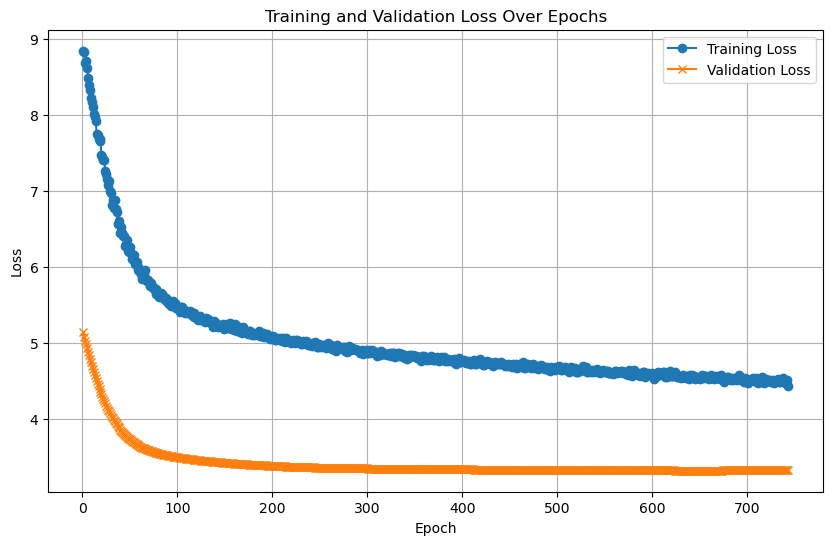

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/38], Loss: 4.8693
Test Batch [20/38], Loss: 4.3750
Test Batch [30/38], Loss: 4.7243

Test Loss: 4.7220


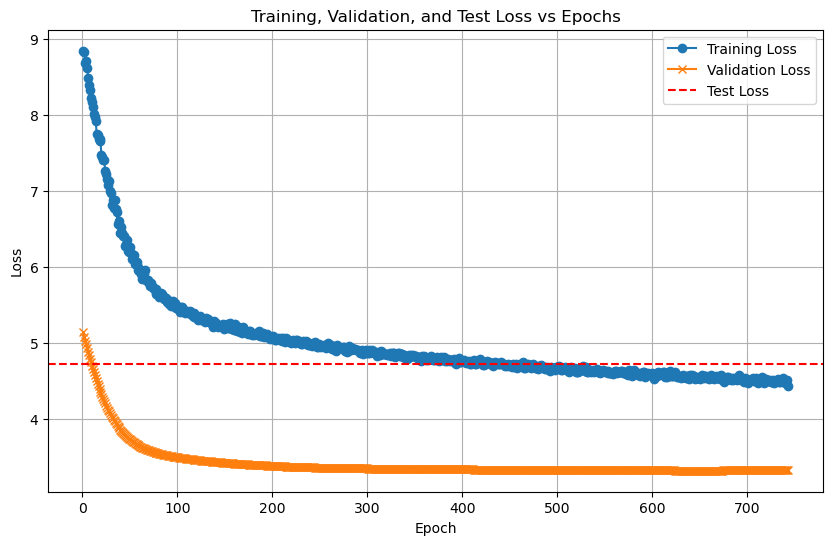

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/38 for test dataset.
  Processed batch 20/38 for test dataset.
  Processed batch 30/38 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (9571, 128)
Test labels shape: (9571,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 65.71%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.80      0.73         5
           1       0.75      0.60      0.67         5
           2       0.50      0.40      0.44         5
           3       0.80      0.80      0.80         5
           4       0.57      0.80      0.67         5
           5       0.67      0.80      0.73         5
           7       0.67      0.40      0.50         5
           8       0.00      0.00      0.00         0
           9       0.60      0.60      0.60         5
          10       0.38      0.60      0.46         5
          11       1.00      0.60      0.75         5
          12       0.71      1.00      0.83         5
          13       1.00      0.60      0.75         5
          14       1.0

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_clas

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (9571, 128)
Test labels shape: (9571,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.8510  |  Val Loss: 2.8533
Validation loss improved from inf to 2.8533.
[Epoch 2/1000] Train Loss: 2.8194  |  Val Loss: 2.8203
Validation loss improved from 2.8533 to 2.8203.
[Epoch 3/1000] Train Loss: 2.7894  |  Val Loss: 2.7902
Validation loss improved from 2.8203 to 2.7902.
[Epoch 4/1000] Train Loss: 2.7623  |  Val Loss: 2.7620
Validation loss improved from 2.7902 to 2.7620.
[Epoch 5/1000] Train Loss: 2.7379  |  Val Loss: 2.7352
Validation loss improved from 2.7620 to 2.7352.
[Epoch 6/1000] Train Loss: 2.7135  |  Val Loss: 2.7092
Validation loss improved from 2.7352 to 2.7092.
[Epoch 7/1000] Train Loss: 2.6908  |  Val Loss: 2.6846
Validation loss improved from 2.7092 to 2.6846.
[Epoch 8/1000] Train Loss: 2.6697  |  Val Loss: 2.6615
Validation loss improved from 2.6846 to 2.6615.
[Epoch 9/1000] Train Loss: 2.6503  |  Val Loss: 2.6403
Validation loss improved from 2.6615 to 2.6403.
[Epoch 10/1000] Train Loss: 2.6308  |  Val Loss: 2.6203
Validation loss impr

[Epoch 15/1000] Train Loss: 2.5452  |  Val Loss: 2.5248
Validation loss improved from 2.5426 to 2.5248.
[Epoch 16/1000] Train Loss: 2.5305  |  Val Loss: 2.5068
Validation loss improved from 2.5248 to 2.5068.
[Epoch 17/1000] Train Loss: 2.5155  |  Val Loss: 2.4892
Validation loss improved from 2.5068 to 2.4892.
[Epoch 18/1000] Train Loss: 2.5004  |  Val Loss: 2.4727
Validation loss improved from 2.4892 to 2.4727.
[Epoch 19/1000] Train Loss: 2.4865  |  Val Loss: 2.4571
Validation loss improved from 2.4727 to 2.4571.


[Epoch 20/1000] Train Loss: 2.4730  |  Val Loss: 2.4421
Validation loss improved from 2.4571 to 2.4421.
[Epoch 21/1000] Train Loss: 2.4583  |  Val Loss: 2.4277
Validation loss improved from 2.4421 to 2.4277.
[Epoch 22/1000] Train Loss: 2.4444  |  Val Loss: 2.4133
Validation loss improved from 2.4277 to 2.4133.
[Epoch 23/1000] Train Loss: 2.4298  |  Val Loss: 2.3993
Validation loss improved from 2.4133 to 2.3993.
[Epoch 24/1000] Train Loss: 2.4162  |  Val Loss: 2.3857
Validation loss improved from 2.3993 to 2.3857.
[Epoch 25/1000] Train Loss: 2.4023  |  Val Loss: 2.3725
Validation loss improved from 2.3857 to 2.3725.
[Epoch 26/1000] Train Loss: 2.3893  |  Val Loss: 2.3598
Validation loss improved from 2.3725 to 2.3598.
[Epoch 27/1000] Train Loss: 2.3755  |  Val Loss: 2.3472
Validation loss improved from 2.3598 to 2.3472.
[Epoch 28/1000] Train Loss: 2.3627  |  Val Loss: 2.3349
Validation loss improved from 2.3472 to 2.3349.
[Epoch 29/1000] Train Loss: 2.3501  |  Val Loss: 2.3229
Validati

[Epoch 35/1000] Train Loss: 2.2752  |  Val Loss: 2.2507
Validation loss improved from 2.2625 to 2.2507.
[Epoch 36/1000] Train Loss: 2.2630  |  Val Loss: 2.2388
Validation loss improved from 2.2507 to 2.2388.
[Epoch 37/1000] Train Loss: 2.2512  |  Val Loss: 2.2282
Validation loss improved from 2.2388 to 2.2282.
[Epoch 38/1000] Train Loss: 2.2393  |  Val Loss: 2.2169
Validation loss improved from 2.2282 to 2.2169.
[Epoch 39/1000] Train Loss: 2.2279  |  Val Loss: 2.2064
Validation loss improved from 2.2169 to 2.2064.
[Epoch 40/1000] Train Loss: 2.2161  |  Val Loss: 2.1948
Validation loss improved from 2.2064 to 2.1948.


[Epoch 41/1000] Train Loss: 2.2043  |  Val Loss: 2.1835
Validation loss improved from 2.1948 to 2.1835.
[Epoch 42/1000] Train Loss: 2.1932  |  Val Loss: 2.1719
Validation loss improved from 2.1835 to 2.1719.
[Epoch 43/1000] Train Loss: 2.1818  |  Val Loss: 2.1607
Validation loss improved from 2.1719 to 2.1607.
[Epoch 44/1000] Train Loss: 2.1708  |  Val Loss: 2.1496
Validation loss improved from 2.1607 to 2.1496.
[Epoch 45/1000] Train Loss: 2.1593  |  Val Loss: 2.1389
Validation loss improved from 2.1496 to 2.1389.
[Epoch 46/1000] Train Loss: 2.1480  |  Val Loss: 2.1274
Validation loss improved from 2.1389 to 2.1274.
[Epoch 47/1000] Train Loss: 2.1371  |  Val Loss: 2.1166
Validation loss improved from 2.1274 to 2.1166.
[Epoch 48/1000] Train Loss: 2.1262  |  Val Loss: 2.1063
Validation loss improved from 2.1166 to 2.1063.
[Epoch 49/1000] Train Loss: 2.1153  |  Val Loss: 2.0955
Validation loss improved from 2.1063 to 2.0955.
[Epoch 50/1000] Train Loss: 2.1047  |  Val Loss: 2.0852
Validati

[Epoch 55/1000] Train Loss: 2.0528  |  Val Loss: 2.0347
Validation loss improved from 2.0441 to 2.0347.
[Epoch 56/1000] Train Loss: 2.0426  |  Val Loss: 2.0252
Validation loss improved from 2.0347 to 2.0252.
[Epoch 57/1000] Train Loss: 2.0325  |  Val Loss: 2.0158
Validation loss improved from 2.0252 to 2.0158.
[Epoch 58/1000] Train Loss: 2.0222  |  Val Loss: 2.0064
Validation loss improved from 2.0158 to 2.0064.
[Epoch 59/1000] Train Loss: 2.0123  |  Val Loss: 1.9971
Validation loss improved from 2.0064 to 1.9971.


[Epoch 60/1000] Train Loss: 2.0023  |  Val Loss: 1.9873
Validation loss improved from 1.9971 to 1.9873.
[Epoch 61/1000] Train Loss: 1.9924  |  Val Loss: 1.9778
Validation loss improved from 1.9873 to 1.9778.
[Epoch 62/1000] Train Loss: 1.9819  |  Val Loss: 1.9682
Validation loss improved from 1.9778 to 1.9682.
[Epoch 63/1000] Train Loss: 1.9716  |  Val Loss: 1.9588
Validation loss improved from 1.9682 to 1.9588.
[Epoch 64/1000] Train Loss: 1.9617  |  Val Loss: 1.9492
Validation loss improved from 1.9588 to 1.9492.
[Epoch 65/1000] Train Loss: 1.9512  |  Val Loss: 1.9390
Validation loss improved from 1.9492 to 1.9390.
[Epoch 66/1000] Train Loss: 1.9407  |  Val Loss: 1.9295
Validation loss improved from 1.9390 to 1.9295.
[Epoch 67/1000] Train Loss: 1.9300  |  Val Loss: 1.9207
Validation loss improved from 1.9295 to 1.9207.
[Epoch 68/1000] Train Loss: 1.9191  |  Val Loss: 1.9106
Validation loss improved from 1.9207 to 1.9106.
[Epoch 69/1000] Train Loss: 1.9078  |  Val Loss: 1.9002
Validati

[Epoch 73/1000] Train Loss: 1.8620  |  Val Loss: 1.8597
Validation loss improved from 1.8699 to 1.8597.
[Epoch 74/1000] Train Loss: 1.8507  |  Val Loss: 1.8507
Validation loss improved from 1.8597 to 1.8507.
[Epoch 75/1000] Train Loss: 1.8399  |  Val Loss: 1.8418
Validation loss improved from 1.8507 to 1.8418.
[Epoch 76/1000] Train Loss: 1.8288  |  Val Loss: 1.8317
Validation loss improved from 1.8418 to 1.8317.
[Epoch 77/1000] Train Loss: 1.8180  |  Val Loss: 1.8225
Validation loss improved from 1.8317 to 1.8225.
[Epoch 78/1000] Train Loss: 1.8067  |  Val Loss: 1.8142
Validation loss improved from 1.8225 to 1.8142.
[Epoch 79/1000] Train Loss: 1.7961  |  Val Loss: 1.8052
Validation loss improved from 1.8142 to 1.8052.


[Epoch 80/1000] Train Loss: 1.7851  |  Val Loss: 1.7973
Validation loss improved from 1.8052 to 1.7973.
[Epoch 81/1000] Train Loss: 1.7745  |  Val Loss: 1.7881
Validation loss improved from 1.7973 to 1.7881.
[Epoch 82/1000] Train Loss: 1.7640  |  Val Loss: 1.7790
Validation loss improved from 1.7881 to 1.7790.
[Epoch 83/1000] Train Loss: 1.7538  |  Val Loss: 1.7697
Validation loss improved from 1.7790 to 1.7697.
[Epoch 84/1000] Train Loss: 1.7427  |  Val Loss: 1.7622
Validation loss improved from 1.7697 to 1.7622.
[Epoch 85/1000] Train Loss: 1.7326  |  Val Loss: 1.7534
Validation loss improved from 1.7622 to 1.7534.
[Epoch 86/1000] Train Loss: 1.7218  |  Val Loss: 1.7448
Validation loss improved from 1.7534 to 1.7448.
[Epoch 87/1000] Train Loss: 1.7112  |  Val Loss: 1.7362
Validation loss improved from 1.7448 to 1.7362.
[Epoch 88/1000] Train Loss: 1.7004  |  Val Loss: 1.7275
Validation loss improved from 1.7362 to 1.7275.
[Epoch 89/1000] Train Loss: 1.6898  |  Val Loss: 1.7188
Validati

[Epoch 92/1000] Train Loss: 1.6574  |  Val Loss: 1.6926
Validation loss improved from 1.7023 to 1.6926.
[Epoch 93/1000] Train Loss: 1.6461  |  Val Loss: 1.6830
Validation loss improved from 1.6926 to 1.6830.
[Epoch 94/1000] Train Loss: 1.6351  |  Val Loss: 1.6719
Validation loss improved from 1.6830 to 1.6719.
[Epoch 95/1000] Train Loss: 1.6241  |  Val Loss: 1.6610
Validation loss improved from 1.6719 to 1.6610.
[Epoch 96/1000] Train Loss: 1.6129  |  Val Loss: 1.6504
Validation loss improved from 1.6610 to 1.6504.
[Epoch 97/1000] Train Loss: 1.6016  |  Val Loss: 1.6395
Validation loss improved from 1.6504 to 1.6395.
[Epoch 98/1000] Train Loss: 1.5906  |  Val Loss: 1.6303
Validation loss improved from 1.6395 to 1.6303.


[Epoch 99/1000] Train Loss: 1.5797  |  Val Loss: 1.6213
Validation loss improved from 1.6303 to 1.6213.
[Epoch 100/1000] Train Loss: 1.5688  |  Val Loss: 1.6124
Validation loss improved from 1.6213 to 1.6124.
[Epoch 101/1000] Train Loss: 1.5582  |  Val Loss: 1.6017
Validation loss improved from 1.6124 to 1.6017.
[Epoch 102/1000] Train Loss: 1.5472  |  Val Loss: 1.5924
Validation loss improved from 1.6017 to 1.5924.
[Epoch 103/1000] Train Loss: 1.5365  |  Val Loss: 1.5825
Validation loss improved from 1.5924 to 1.5825.
[Epoch 104/1000] Train Loss: 1.5256  |  Val Loss: 1.5736
Validation loss improved from 1.5825 to 1.5736.
[Epoch 105/1000] Train Loss: 1.5145  |  Val Loss: 1.5648
Validation loss improved from 1.5736 to 1.5648.
[Epoch 106/1000] Train Loss: 1.5039  |  Val Loss: 1.5566
Validation loss improved from 1.5648 to 1.5566.
[Epoch 107/1000] Train Loss: 1.4932  |  Val Loss: 1.5473
Validation loss improved from 1.5566 to 1.5473.
[Epoch 108/1000] Train Loss: 1.4825  |  Val Loss: 1.5385

[Epoch 110/1000] Train Loss: 1.4627  |  Val Loss: 1.5197
Validation loss improved from 1.5294 to 1.5197.
[Epoch 111/1000] Train Loss: 1.4511  |  Val Loss: 1.5100
Validation loss improved from 1.5197 to 1.5100.
[Epoch 112/1000] Train Loss: 1.4410  |  Val Loss: 1.5010
Validation loss improved from 1.5100 to 1.5010.
[Epoch 113/1000] Train Loss: 1.4312  |  Val Loss: 1.4915
Validation loss improved from 1.5010 to 1.4915.
[Epoch 114/1000] Train Loss: 1.4204  |  Val Loss: 1.4834
Validation loss improved from 1.4915 to 1.4834.
[Epoch 115/1000] Train Loss: 1.4099  |  Val Loss: 1.4760
Validation loss improved from 1.4834 to 1.4760.
[Epoch 116/1000] Train Loss: 1.3999  |  Val Loss: 1.4665
Validation loss improved from 1.4760 to 1.4665.


[Epoch 117/1000] Train Loss: 1.3898  |  Val Loss: 1.4577
Validation loss improved from 1.4665 to 1.4577.
[Epoch 118/1000] Train Loss: 1.3802  |  Val Loss: 1.4496
Validation loss improved from 1.4577 to 1.4496.
[Epoch 119/1000] Train Loss: 1.3701  |  Val Loss: 1.4423
Validation loss improved from 1.4496 to 1.4423.
[Epoch 120/1000] Train Loss: 1.3602  |  Val Loss: 1.4332
Validation loss improved from 1.4423 to 1.4332.
[Epoch 121/1000] Train Loss: 1.3503  |  Val Loss: 1.4256
Validation loss improved from 1.4332 to 1.4256.
[Epoch 122/1000] Train Loss: 1.3402  |  Val Loss: 1.4175
Validation loss improved from 1.4256 to 1.4175.
[Epoch 123/1000] Train Loss: 1.3308  |  Val Loss: 1.4101
Validation loss improved from 1.4175 to 1.4101.
[Epoch 124/1000] Train Loss: 1.3221  |  Val Loss: 1.4029
Validation loss improved from 1.4101 to 1.4029.
[Epoch 125/1000] Train Loss: 1.3123  |  Val Loss: 1.3949
Validation loss improved from 1.4029 to 1.3949.
[Epoch 126/1000] Train Loss: 1.3033  |  Val Loss: 1.388

[Epoch 130/1000] Train Loss: 1.2684  |  Val Loss: 1.3614
Validation loss improved from 1.3686 to 1.3614.
[Epoch 131/1000] Train Loss: 1.2598  |  Val Loss: 1.3542
Validation loss improved from 1.3614 to 1.3542.
[Epoch 132/1000] Train Loss: 1.2522  |  Val Loss: 1.3490
Validation loss improved from 1.3542 to 1.3490.
[Epoch 133/1000] Train Loss: 1.2441  |  Val Loss: 1.3426
Validation loss improved from 1.3490 to 1.3426.
[Epoch 134/1000] Train Loss: 1.2352  |  Val Loss: 1.3361
Validation loss improved from 1.3426 to 1.3361.
[Epoch 135/1000] Train Loss: 1.2278  |  Val Loss: 1.3298
Validation loss improved from 1.3361 to 1.3298.
[Epoch 136/1000] Train Loss: 1.2192  |  Val Loss: 1.3242
Validation loss improved from 1.3298 to 1.3242.


[Epoch 137/1000] Train Loss: 1.2116  |  Val Loss: 1.3187
Validation loss improved from 1.3242 to 1.3187.
[Epoch 138/1000] Train Loss: 1.2045  |  Val Loss: 1.3140
Validation loss improved from 1.3187 to 1.3140.
[Epoch 139/1000] Train Loss: 1.1971  |  Val Loss: 1.3076
Validation loss improved from 1.3140 to 1.3076.
[Epoch 140/1000] Train Loss: 1.1890  |  Val Loss: 1.3029
Validation loss improved from 1.3076 to 1.3029.
[Epoch 141/1000] Train Loss: 1.1819  |  Val Loss: 1.2986
Validation loss improved from 1.3029 to 1.2986.
[Epoch 142/1000] Train Loss: 1.1750  |  Val Loss: 1.2931
Validation loss improved from 1.2986 to 1.2931.
[Epoch 143/1000] Train Loss: 1.1678  |  Val Loss: 1.2887
Validation loss improved from 1.2931 to 1.2887.
[Epoch 144/1000] Train Loss: 1.1612  |  Val Loss: 1.2853
Validation loss improved from 1.2887 to 1.2853.
[Epoch 145/1000] Train Loss: 1.1544  |  Val Loss: 1.2801
Validation loss improved from 1.2853 to 1.2801.
[Epoch 146/1000] Train Loss: 1.1476  |  Val Loss: 1.275

[Epoch 150/1000] Train Loss: 1.1220  |  Val Loss: 1.2593
Validation loss improved from 1.2622 to 1.2593.
[Epoch 151/1000] Train Loss: 1.1163  |  Val Loss: 1.2574
Validation loss improved from 1.2593 to 1.2574.
[Epoch 152/1000] Train Loss: 1.1104  |  Val Loss: 1.2541
Validation loss improved from 1.2574 to 1.2541.
[Epoch 153/1000] Train Loss: 1.1046  |  Val Loss: 1.2506
Validation loss improved from 1.2541 to 1.2506.
[Epoch 154/1000] Train Loss: 1.0989  |  Val Loss: 1.2467
Validation loss improved from 1.2506 to 1.2467.
[Epoch 155/1000] Train Loss: 1.0932  |  Val Loss: 1.2435
Validation loss improved from 1.2467 to 1.2435.


[Epoch 156/1000] Train Loss: 1.0876  |  Val Loss: 1.2416
Validation loss improved from 1.2435 to 1.2416.
[Epoch 157/1000] Train Loss: 1.0820  |  Val Loss: 1.2387
Validation loss improved from 1.2416 to 1.2387.
[Epoch 158/1000] Train Loss: 1.0770  |  Val Loss: 1.2346
Validation loss improved from 1.2387 to 1.2346.
[Epoch 159/1000] Train Loss: 1.0714  |  Val Loss: 1.2315
Validation loss improved from 1.2346 to 1.2315.
[Epoch 160/1000] Train Loss: 1.0663  |  Val Loss: 1.2293
Validation loss improved from 1.2315 to 1.2293.
[Epoch 161/1000] Train Loss: 1.0615  |  Val Loss: 1.2275
Validation loss improved from 1.2293 to 1.2275.
[Epoch 162/1000] Train Loss: 1.0560  |  Val Loss: 1.2248
Validation loss improved from 1.2275 to 1.2248.
[Epoch 163/1000] Train Loss: 1.0508  |  Val Loss: 1.2212
Validation loss improved from 1.2248 to 1.2212.
[Epoch 164/1000] Train Loss: 1.0462  |  Val Loss: 1.2189
Validation loss improved from 1.2212 to 1.2189.
[Epoch 165/1000] Train Loss: 1.0415  |  Val Loss: 1.216

[Epoch 167/1000] Train Loss: 1.0318  |  Val Loss: 1.2104
Validation loss improved from 1.2136 to 1.2104.
[Epoch 168/1000] Train Loss: 1.0264  |  Val Loss: 1.2079
Validation loss improved from 1.2104 to 1.2079.
[Epoch 169/1000] Train Loss: 1.0226  |  Val Loss: 1.2051
Validation loss improved from 1.2079 to 1.2051.
[Epoch 170/1000] Train Loss: 1.0184  |  Val Loss: 1.2042
Validation loss improved from 1.2051 to 1.2042.
[Epoch 171/1000] Train Loss: 1.0139  |  Val Loss: 1.2027
Validation loss improved from 1.2042 to 1.2027.
[Epoch 172/1000] Train Loss: 1.0094  |  Val Loss: 1.1992
Validation loss improved from 1.2027 to 1.1992.
[Epoch 173/1000] Train Loss: 1.0054  |  Val Loss: 1.1967
Validation loss improved from 1.1992 to 1.1967.


[Epoch 174/1000] Train Loss: 1.0006  |  Val Loss: 1.1954
Validation loss improved from 1.1967 to 1.1954.
[Epoch 175/1000] Train Loss: 0.9973  |  Val Loss: 1.1927
Validation loss improved from 1.1954 to 1.1927.
[Epoch 176/1000] Train Loss: 0.9932  |  Val Loss: 1.1890
Validation loss improved from 1.1927 to 1.1890.
[Epoch 177/1000] Train Loss: 0.9896  |  Val Loss: 1.1890
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 178/1000] Train Loss: 0.9852  |  Val Loss: 1.1876
Validation loss improved from 1.1890 to 1.1876.
[Epoch 179/1000] Train Loss: 0.9820  |  Val Loss: 1.1857
Validation loss improved from 1.1876 to 1.1857.
[Epoch 180/1000] Train Loss: 0.9775  |  Val Loss: 1.1827
Validation loss improved from 1.1857 to 1.1827.
[Epoch 181/1000] Train Loss: 0.9737  |  Val Loss: 1.1808
Validation loss improved from 1.1827 to 1.1808.
[Epoch 182/1000] Train Loss: 0.9705  |  Val Loss: 1.1790
Validation loss improved from 1.1808 to 1.1790.
[Epoch 183/1000] Train Loss: 0.9664  |  Val Loss:

[Epoch 186/1000] Train Loss: 0.9571  |  Val Loss: 1.1724
Validation loss improved from 1.1745 to 1.1724.
[Epoch 187/1000] Train Loss: 0.9535  |  Val Loss: 1.1693
Validation loss improved from 1.1724 to 1.1693.
[Epoch 188/1000] Train Loss: 0.9504  |  Val Loss: 1.1689
Validation loss improved from 1.1693 to 1.1689.
[Epoch 189/1000] Train Loss: 0.9468  |  Val Loss: 1.1672
Validation loss improved from 1.1689 to 1.1672.
[Epoch 190/1000] Train Loss: 0.9441  |  Val Loss: 1.1671
Validation loss improved from 1.1672 to 1.1671.
[Epoch 191/1000] Train Loss: 0.9416  |  Val Loss: 1.1652
Validation loss improved from 1.1671 to 1.1652.
[Epoch 192/1000] Train Loss: 0.9388  |  Val Loss: 1.1639
Validation loss improved from 1.1652 to 1.1639.


[Epoch 193/1000] Train Loss: 0.9355  |  Val Loss: 1.1636
Validation loss improved from 1.1639 to 1.1636.
[Epoch 194/1000] Train Loss: 0.9313  |  Val Loss: 1.1627
Validation loss improved from 1.1636 to 1.1627.
[Epoch 195/1000] Train Loss: 0.9293  |  Val Loss: 1.1596
Validation loss improved from 1.1627 to 1.1596.
[Epoch 196/1000] Train Loss: 0.9264  |  Val Loss: 1.1583
Validation loss improved from 1.1596 to 1.1583.
[Epoch 197/1000] Train Loss: 0.9233  |  Val Loss: 1.1582
Validation loss improved from 1.1583 to 1.1582.
[Epoch 198/1000] Train Loss: 0.9207  |  Val Loss: 1.1570
Validation loss improved from 1.1582 to 1.1570.
[Epoch 199/1000] Train Loss: 0.9181  |  Val Loss: 1.1556
Validation loss improved from 1.1570 to 1.1556.
[Epoch 200/1000] Train Loss: 0.9156  |  Val Loss: 1.1563
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 201/1000] Train Loss: 0.9124  |  Val Loss: 1.1531
Validation loss improved from 1.1556 to 1.1531.
[Epoch 202/1000] Train Loss: 0.9102  |  Val Loss:

[Epoch 204/1000] Train Loss: 0.9050  |  Val Loss: 1.1504
Validation loss improved from 1.1507 to 1.1504.
[Epoch 205/1000] Train Loss: 0.9021  |  Val Loss: 1.1496
Validation loss improved from 1.1504 to 1.1496.
[Epoch 206/1000] Train Loss: 0.9006  |  Val Loss: 1.1488
Validation loss improved from 1.1496 to 1.1488.
[Epoch 207/1000] Train Loss: 0.8977  |  Val Loss: 1.1476
Validation loss improved from 1.1488 to 1.1476.
[Epoch 208/1000] Train Loss: 0.8950  |  Val Loss: 1.1468
Validation loss improved from 1.1476 to 1.1468.
[Epoch 209/1000] Train Loss: 0.8923  |  Val Loss: 1.1464
Validation loss improved from 1.1468 to 1.1464.
[Epoch 210/1000] Train Loss: 0.8902  |  Val Loss: 1.1462
Validation loss improved from 1.1464 to 1.1462.
[Epoch 211/1000] Train Loss: 0.8881  |  Val Loss: 1.1440
Validation loss improved from 1.1462 to 1.1440.
[Epoch 212/1000] Train Loss: 0.8862  |  Val Loss: 1.1421
Validation loss improved from 1.1440 to 1.1421.


[Epoch 213/1000] Train Loss: 0.8837  |  Val Loss: 1.1426
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 214/1000] Train Loss: 0.8808  |  Val Loss: 1.1418
Validation loss improved from 1.1421 to 1.1418.
[Epoch 215/1000] Train Loss: 0.8790  |  Val Loss: 1.1430
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 216/1000] Train Loss: 0.8768  |  Val Loss: 1.1419
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 217/1000] Train Loss: 0.8750  |  Val Loss: 1.1404
Validation loss improved from 1.1418 to 1.1404.
[Epoch 218/1000] Train Loss: 0.8728  |  Val Loss: 1.1404
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 219/1000] Train Loss: 0.8709  |  Val Loss: 1.1395
Validation loss improved from 1.1404 to 1.1395.
[Epoch 220/1000] Train Loss: 0.8693  |  Val Loss: 1.1400
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 221/1000] Train Loss: 0.8664  |  Val Loss: 1.1387
Validation loss improved from 1.1395 to 1.1387.
[Epoch 222/1000] Train Lo

[Epoch 223/1000] Train Loss: 0.8628  |  Val Loss: 1.1366
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 224/1000] Train Loss: 0.8615  |  Val Loss: 1.1374
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 225/1000] Train Loss: 0.8593  |  Val Loss: 1.1356
Validation loss improved from 1.1366 to 1.1356.
[Epoch 226/1000] Train Loss: 0.8568  |  Val Loss: 1.1348
Validation loss improved from 1.1356 to 1.1348.
[Epoch 227/1000] Train Loss: 0.8553  |  Val Loss: 1.1350
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 228/1000] Train Loss: 0.8531  |  Val Loss: 1.1342
Validation loss improved from 1.1348 to 1.1342.
[Epoch 229/1000] Train Loss: 0.8523  |  Val Loss: 1.1330
Validation loss improved from 1.1342 to 1.1330.


[Epoch 230/1000] Train Loss: 0.8502  |  Val Loss: 1.1339
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 231/1000] Train Loss: 0.8478  |  Val Loss: 1.1324
Validation loss improved from 1.1330 to 1.1324.
[Epoch 232/1000] Train Loss: 0.8466  |  Val Loss: 1.1300
Validation loss improved from 1.1324 to 1.1300.
[Epoch 233/1000] Train Loss: 0.8450  |  Val Loss: 1.1295
Validation loss improved from 1.1300 to 1.1295.
[Epoch 234/1000] Train Loss: 0.8432  |  Val Loss: 1.1300
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 235/1000] Train Loss: 0.8413  |  Val Loss: 1.1316
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 236/1000] Train Loss: 0.8397  |  Val Loss: 1.1332
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 237/1000] Train Loss: 0.8388  |  Val Loss: 1.1296
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 238/1000] Train Loss: 0.8371  |  Val Loss: 1.1276
Validation loss improved from 1.1295 to 1.1276.
[Epoch 239/1000] Train Lo

[Epoch 244/1000] Train Loss: 0.8268  |  Val Loss: 1.1299
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 245/1000] Train Loss: 0.8249  |  Val Loss: 1.1283
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 246/1000] Train Loss: 0.8239  |  Val Loss: 1.1274
Validation loss improved from 1.1276 to 1.1274.
[Epoch 247/1000] Train Loss: 0.8230  |  Val Loss: 1.1254
Validation loss improved from 1.1274 to 1.1254.
[Epoch 248/1000] Train Loss: 0.8204  |  Val Loss: 1.1260
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 249/1000] Train Loss: 0.8197  |  Val Loss: 1.1271
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 250/1000] Train Loss: 0.8179  |  Val Loss: 1.1258
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 251/1000] Train Loss: 0.8171  |  Val Loss: 1.1278
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 252/1000] Train Loss: 0.8152  |  Val Loss: 1.1266
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 253/1000] Train Loss: 0.8139  |  Val Loss: 1.1245
Validation loss improved from 1.1254 to 1.1245.
[Epoch 254/1000] Train Loss: 0.8122  |  Val Loss: 1.1242
Validation loss improved from 1.1245 to 1.1242.
[Epoch 255/1000] Train Loss: 0.8115  |  Val Loss: 1.1251
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 256/1000] Train Loss: 0.8091  |  Val Loss: 1.1253
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 257/1000] Train Loss: 0.8085  |  Val Loss: 1.1252
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 258/1000] Train Loss: 0.8066  |  Val Loss: 1.1250
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 259/10

[Epoch 262/1000] Train Loss: 0.8015  |  Val Loss: 1.1233
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 263/1000] Train Loss: 0.7996  |  Val Loss: 1.1232
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 264/1000] Train Loss: 0.7985  |  Val Loss: 1.1248
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 265/1000] Train Loss: 0.7976  |  Val Loss: 1.1219
Validation loss improved from 1.1224 to 1.1219.
[Epoch 266/1000] Train Loss: 0.7959  |  Val Loss: 1.1235
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 267/1000] Train Loss: 0.7945  |  Val Loss: 1.1240
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 268/1000] Train Loss: 0.7932  |  Val Loss: 1.1231
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 269/1000] Train Loss: 0.7919  |  Val Loss: 1.1239
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 270/1000] Train Loss: 0.7906  |  Val Loss: 1.1227
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 271/1000] Train Loss: 0.7892  |  Val Loss: 1.1227
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 272/1000] Train Loss: 0.7884  |  Val Loss: 1.1233
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 273/1000] Train Loss: 0.7882  |  Val Loss: 1.1238
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 274/1000] Train Loss: 0.7864  |  Val Loss: 1.1231
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 275/1000] Train Loss: 0.7845  |  Val Loss: 1.1233
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 276/1000] Train Loss: 0.7836  |  Val Loss: 1.1231
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 280/1000] Train Loss: 0.7794  |  Val Loss: 1.1240
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 281/1000] Train Loss: 0.7776  |  Val Loss: 1.1229
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 282/1000] Train Loss: 0.7767  |  Val Loss: 1.1221
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 283/1000] Train Loss: 0.7756  |  Val Loss: 1.1214
Validation loss improved from 1.1219 to 1.1214.
[Epoch 284/1000] Train Loss: 0.7740  |  Val Loss: 1.1220
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 285/1000] Train Loss: 0.7733  |  Val Loss: 1.1215
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 286/1000] Train Loss: 0.7722  |  Val Loss: 1.1223
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 287/1000] Train Loss: 0.7711  |  Val Loss: 1.1224
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 288/1000] Train Loss: 0.7701  |  Val Loss: 1.1220
!! Validation loss did NOT improve !! Patience: 5/100
[Epo

[Epoch 290/1000] Train Loss: 0.7684  |  Val Loss: 1.1212
Validation loss improved from 1.1214 to 1.1212.
[Epoch 291/1000] Train Loss: 0.7673  |  Val Loss: 1.1234
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 292/1000] Train Loss: 0.7660  |  Val Loss: 1.1228
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 293/1000] Train Loss: 0.7650  |  Val Loss: 1.1246
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 294/1000] Train Loss: 0.7647  |  Val Loss: 1.1240
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 295/1000] Train Loss: 0.7631  |  Val Loss: 1.1243
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 296/1000] Train Loss: 0.7619  |  Val Loss: 1.1241
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 297/1000] Train Loss: 0.7614  |  Val Loss: 1.1240
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 298/1000] Train Loss: 0.7604  |  Val Loss: 1.1251
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 300/1000] Train Loss: 0.7579  |  Val Loss: 1.1254
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 301/1000] Train Loss: 0.7567  |  Val Loss: 1.1257
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 302/1000] Train Loss: 0.7564  |  Val Loss: 1.1248
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 303/1000] Train Loss: 0.7558  |  Val Loss: 1.1243
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 304/1000] Train Loss: 0.7545  |  Val Loss: 1.1243
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 305/1000] Train Loss: 0.7551  |  Val Loss: 1.1264
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 306/1000] Train Loss: 0.7522  |  Val Loss: 1.1266
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 307/1000] Train Loss: 0.7516  |  Val Loss: 1.1258
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 308/1000] Train Loss: 0.7506  |  Val Loss: 1.1272
!! Validation loss did NOT improve !! Patience:

[Epoch 311/1000] Train Loss: 0.7473  |  Val Loss: 1.1269
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 312/1000] Train Loss: 0.7472  |  Val Loss: 1.1272
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 313/1000] Train Loss: 0.7462  |  Val Loss: 1.1264
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 314/1000] Train Loss: 0.7456  |  Val Loss: 1.1284
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 315/1000] Train Loss: 0.7446  |  Val Loss: 1.1295
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 316/1000] Train Loss: 0.7439  |  Val Loss: 1.1268
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 317/1000] Train Loss: 0.7422  |  Val Loss: 1.1265
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 318/1000] Train Loss: 0.7413  |  Val Loss: 1.1281
!! Validation loss did NOT improve !! Patience: 28/100


[Epoch 319/1000] Train Loss: 0.7408  |  Val Loss: 1.1282
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 320/1000] Train Loss: 0.7398  |  Val Loss: 1.1285
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 321/1000] Train Loss: 0.7391  |  Val Loss: 1.1279
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 322/1000] Train Loss: 0.7388  |  Val Loss: 1.1255
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 323/1000] Train Loss: 0.7376  |  Val Loss: 1.1269
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 324/1000] Train Loss: 0.7362  |  Val Loss: 1.1294
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 325/1000] Train Loss: 0.7362  |  Val Loss: 1.1290
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 326/1000] Train Loss: 0.7345  |  Val Loss: 1.1308
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 327/1000] Train Loss: 0.7338  |  Val Loss: 1.1299
!! Validation loss did NOT improve !! Patience:

[Epoch 330/1000] Train Loss: 0.7312  |  Val Loss: 1.1292
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 331/1000] Train Loss: 0.7309  |  Val Loss: 1.1314
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 332/1000] Train Loss: 0.7292  |  Val Loss: 1.1304
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 333/1000] Train Loss: 0.7289  |  Val Loss: 1.1319
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 334/1000] Train Loss: 0.7278  |  Val Loss: 1.1328
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 335/1000] Train Loss: 0.7280  |  Val Loss: 1.1315
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 336/1000] Train Loss: 0.7265  |  Val Loss: 1.1322
!! Validation loss did NOT improve !! Patience: 46/100


[Epoch 337/1000] Train Loss: 0.7253  |  Val Loss: 1.1328
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 338/1000] Train Loss: 0.7254  |  Val Loss: 1.1311
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 339/1000] Train Loss: 0.7246  |  Val Loss: 1.1326
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 340/1000] Train Loss: 0.7236  |  Val Loss: 1.1336
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 341/1000] Train Loss: 0.7221  |  Val Loss: 1.1341
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 342/1000] Train Loss: 0.7221  |  Val Loss: 1.1334
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 343/1000] Train Loss: 0.7203  |  Val Loss: 1.1331
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 344/1000] Train Loss: 0.7195  |  Val Loss: 1.1351
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 345/1000] Train Loss: 0.7195  |  Val Loss: 1.1364
!! Validation loss did NOT improve !! Patience:

[Epoch 349/1000] Train Loss: 0.7163  |  Val Loss: 1.1374
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 350/1000] Train Loss: 0.7161  |  Val Loss: 1.1375
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 351/1000] Train Loss: 0.7152  |  Val Loss: 1.1367
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 352/1000] Train Loss: 0.7143  |  Val Loss: 1.1359
!! Validation loss did NOT improve !! Patience: 62/100


[Epoch 353/1000] Train Loss: 0.7129  |  Val Loss: 1.1365
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 354/1000] Train Loss: 0.7121  |  Val Loss: 1.1368
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 355/1000] Train Loss: 0.7119  |  Val Loss: 1.1361
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 356/1000] Train Loss: 0.7107  |  Val Loss: 1.1371
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 357/1000] Train Loss: 0.7100  |  Val Loss: 1.1375
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 358/1000] Train Loss: 0.7091  |  Val Loss: 1.1389
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 359/1000] Train Loss: 0.7077  |  Val Loss: 1.1392
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 360/1000] Train Loss: 0.7077  |  Val Loss: 1.1386
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 361/1000] Train Loss: 0.7065  |  Val Loss: 1.1392
!! Validation loss did NOT improve !! Patience:

[Epoch 369/1000] Train Loss: 0.7013  |  Val Loss: 1.1431
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 370/1000] Train Loss: 0.7004  |  Val Loss: 1.1400
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 371/1000] Train Loss: 0.6989  |  Val Loss: 1.1413
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 372/1000] Train Loss: 0.6988  |  Val Loss: 1.1421
!! Validation loss did NOT improve !! Patience: 82/100


[Epoch 373/1000] Train Loss: 0.6982  |  Val Loss: 1.1428
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 374/1000] Train Loss: 0.6969  |  Val Loss: 1.1410
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 375/1000] Train Loss: 0.6963  |  Val Loss: 1.1406
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 376/1000] Train Loss: 0.6988  |  Val Loss: 1.1431
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 377/1000] Train Loss: 0.6947  |  Val Loss: 1.1429
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 378/1000] Train Loss: 0.6952  |  Val Loss: 1.1437
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 379/1000] Train Loss: 0.6939  |  Val Loss: 1.1447
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 380/1000] Train Loss: 0.6927  |  Val Loss: 1.1462
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 381/1000] Train Loss: 0.6929  |  Val Loss: 1.1432
!! Validation loss did NOT improve !! Patience:

[Epoch 390/1000] Train Loss: 0.6866  |  Val Loss: 1.1445
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 390 !!
No improvement for 100 epochs.


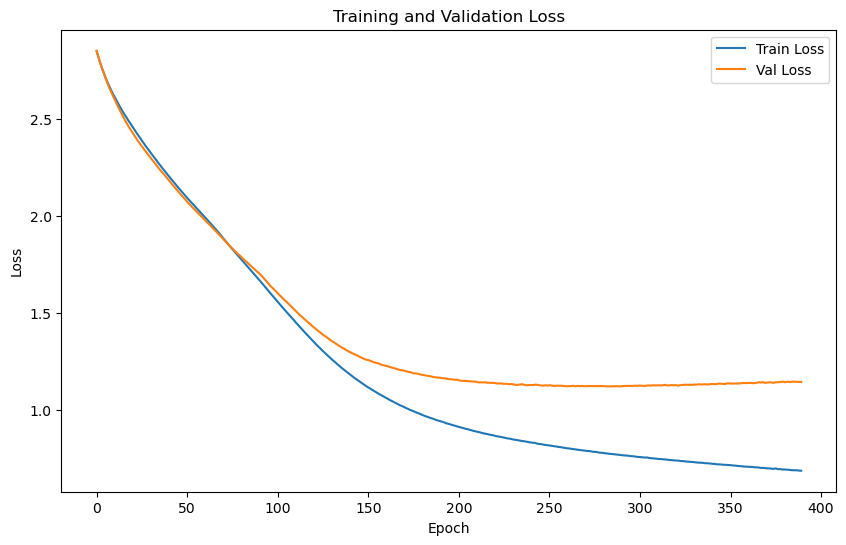

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 1.5301 | Test Accuracy: 51.41%


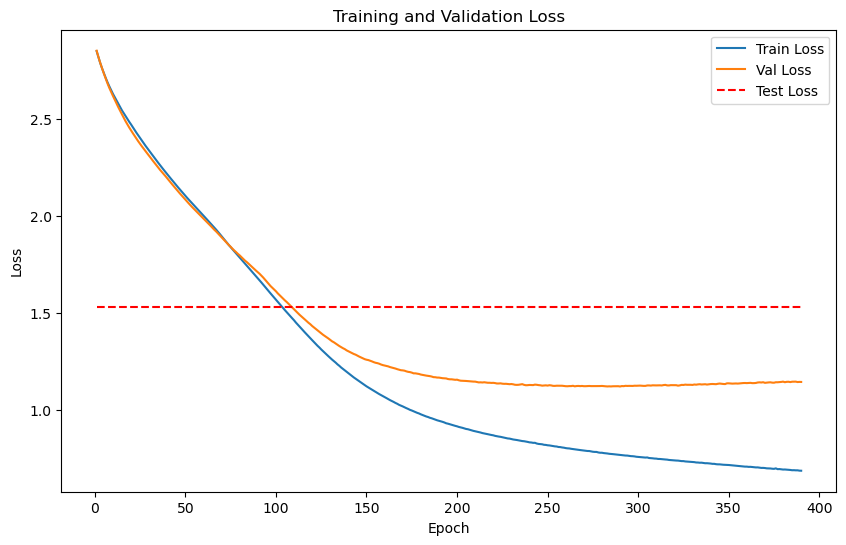

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 9571 samples with 64 features each
LOG: Labels shape: (9571,)


Train embeddings shape: (320, 64), 
Train labels shape: (320,)


Val embeddings shape: (70, 64), 
Val labels shape: (70,)


Test embeddings shape: (9571, 64), 
Test labels shape: (9571,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}
Training batch size: 320


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4998
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.5321
    Batch [2/2], Val Loss: 0.1400
Epoch [1/2000], Avg Train Loss: 0.4998, Avg Val Loss: 0.3361

Validation loss improved from inf to 0.3361. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.4999
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.5313
    Batch [2/2], Val Loss: 0.1383
Epoch [2/2000], Avg Train Loss: 0.4999, Avg Val Loss: 0.3348

Validation loss improved from 0.3361 to 0.3348. Saving model...
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.4973
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.5308
    Batch [2/2], Val Loss: 0.1369
Epoch [3/2000], Avg Train Loss: 0.4973, Avg Val Loss: 0.3338

Validation loss improved from 0.3348 to 0.3338. Saving model...
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.4955
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.5303
    Batch [2/2], Val Loss: 0.1366
Epoch [4/2000], Avg Train Loss: 0.4955, Avg Val Loss: 0.3335

Validation loss improved from 0.3338 to 0.3335. Saving model...
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.4951
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.5296
    Batch [2/2], Val Loss: 0.1365
Epoch [5/2000], Avg Train Loss: 0.4951, Avg Val Loss: 0.3331

Validation loss improved from 0.3335 to 0.3331. Saving model...
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.4948
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.5288
    Batch [2/2], Val Loss: 0.1365
Epoch [6/2000], Avg Train Loss: 0.4948, Avg Val Loss: 0.3326

Validation loss improved from 0.3331 to 0.3326. Saving model...
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.4928
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.5283
    Batch [2/2], Val Loss: 0.1359
Epoch [7/2000], Avg Train Loss: 0.4928, Avg Val Loss: 0.3321

Validation loss improved from 0.3326 to 0.3321. Saving model...
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.4953
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.5278
    Batch [2/2], Val Loss: 0.1348
Epoch [8/2000], Avg Train Loss: 0.4953, Avg Val Loss: 0.3313

Validation loss improved from 0.3321 to 0.3313. Saving model...
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.4938
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.5275
    Batch [2/2], Val Loss: 0.1338
Epoch [9/2000], Avg Train Loss: 0.4938, Avg Val Loss: 0.3307

Validation loss improved from 0.3313 to 0.3307. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.4925
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.5272
    Batch [2/2], Val Loss: 0.1330
Epoch [10/2000], Avg Train Loss: 0.4925, Avg Val Loss: 0.3301

Validation loss improved from 0.3307 to 0.3301. Saving model...
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.4927
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.5267
    Batch [2/2], Val Loss: 0.1321
Epoch [11/2000], Avg Train Loss: 0.4927, Avg Val Loss: 0.3294

Validation loss improved from 0.3301 to 0.3294. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.4918
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.5261
    Batch [2/2], Val Loss: 0.1311
Epoch [12/2000], Avg Train Loss: 0.4918, Avg Val Loss: 0.3286

Validation loss improved from 0.3294 to 0.3286. Saving model...
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.5256
    Batch [2/2], Val Loss: 0.1303
Epoch [13/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.3279

Validation loss improved from 0.3286 to 0.3279. Saving model...
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.5251
    Batch [2/2], Val Loss: 0.1295
Epoch [14/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.3273

Validation loss improved from 0.3279 to 0.3273. Saving model...
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4908
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.5246
    Batch [2/2], Val Loss: 0.1290
Epoch [15/2000], Avg Train Loss: 0.4908, Avg Val Loss: 0.3268

Validation loss improved from 0.3273 to 0.3268. Saving model...
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.4919
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.5240
    Batch [2/2], Val Loss: 0.1284
Epoch [16/2000], Avg Train Loss: 0.4919, Avg Val Loss: 0.3262

Validation loss improved from 0.3268 to 0.3262. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4902
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.5234
    Batch [2/2], Val Loss: 0.1278
Epoch [17/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.3256

Validation loss improved from 0.3262 to 0.3256. Saving model...
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.5228
    Batch [2/2], Val Loss: 0.1275
Epoch [18/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.3251

Validation loss improved from 0.3256 to 0.3251. Saving model...
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.5219
    Batch [2/2], Val Loss: 0.1273
Epoch [19/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.3246

Validation loss improved from 0.3251 to 0.3246. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.5209
    Batch [2/2], Val Loss: 0.1272
Epoch [20/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.3240

Validation loss improved from 0.3246 to 0.3240. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.5198
    Batch [2/2], Val Loss: 0.1270
Epoch [21/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.3234

Validation loss improved from 0.3240 to 0.3234. Saving model...
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.4873
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.5187
    Batch [2/2], Val Loss: 0.1269
Epoch [22/2000], Avg Train Loss: 0.4873, Avg Val Loss: 0.3228

Validation loss improved from 0.3234 to 0.3228. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4874
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.5176
    Batch [2/2], Val Loss: 0.1267
Epoch [23/2000], Avg Train Loss: 0.4874, Avg Val Loss: 0.3221

Validation loss improved from 0.3228 to 0.3221. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.4865
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.5167
    Batch [2/2], Val Loss: 0.1265
Epoch [24/2000], Avg Train Loss: 0.4865, Avg Val Loss: 0.3216

Validation loss improved from 0.3221 to 0.3216. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.4864
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.5160
    Batch [2/2], Val Loss: 0.1262
Epoch [25/2000], Avg Train Loss: 0.4864, Avg Val Loss: 0.3211

Validation loss improved from 0.3216 to 0.3211. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.4865
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.5152
    Batch [2/2], Val Loss: 0.1259
Epoch [26/2000], Avg Train Loss: 0.4865, Avg Val Loss: 0.3206

Validation loss improved from 0.3211 to 0.3206. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.5145
    Batch [2/2], Val Loss: 0.1256
Epoch [27/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.3201

Validation loss improved from 0.3206 to 0.3201. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.4865
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.5138
    Batch [2/2], Val Loss: 0.1253
Epoch [28/2000], Avg Train Loss: 0.4865, Avg Val Loss: 0.3196

Validation loss improved from 0.3201 to 0.3196. Saving model...
LOG: Epoch [29/2000] - Training


    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.1250
Epoch [29/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.3191

Validation loss improved from 0.3196 to 0.3191. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.4864
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.5127
    Batch [2/2], Val Loss: 0.1247
Epoch [30/2000], Avg Train Loss: 0.4864, Avg Val Loss: 0.3187

Validation loss improved from 0.3191 to 0.3187. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.4868
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.5121
    Batch [2/2], Val Loss: 0.1243
Epoch [31/2000], Avg Train Loss: 0.4868, Avg Val Loss: 0.3182

Validation loss improved from 0.3187 to 0.3182. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.4874
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.5115
    Batch [2/2], Val Loss: 0.1240
Epoch [32/2000], Avg Train Loss: 0.4874, Avg Val Loss: 0.3177

Validation loss improved from 0.3182 to 0.3177. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.4858
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.5110
    Batch [2/2], Val Loss: 0.1236
Epoch [33/2000], Avg Train Loss: 0.4858, Avg Val Loss: 0.3173

Validation loss improved from 0.3177 to 0.3173. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.4848
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.5104
    Batch [2/2], Val Loss: 0.1231
Epoch [34/2000], Avg Train Loss: 0.4848, Avg Val Loss: 0.3168

Validation loss improved from 0.3173 to 0.3168. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.4831
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.5100
    Batch [2/2], Val Loss: 0.1227
Epoch [35/2000], Avg Train Loss: 0.4831, Avg Val Loss: 0.3163

Validation loss improved from 0.3168 to 0.3163. Saving model...
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.4845
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.5095
    Batch [2/2], Val Loss: 0.1223
Epoch [36/2000], Avg Train Loss: 0.4845, Avg Val Loss: 0.3159

Validation loss improved from 0.3163 to 0.3159. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.4835
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.5090
    Batch [2/2], Val Loss: 0.1218
Epoch [37/2000], Avg Train Loss: 0.4835, Avg Val Loss: 0.3154

Validation loss improved from 0.3159 to 0.3154. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.4840
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.5085
    Batch [2/2], Val Loss: 0.1213
Epoch [38/2000], Avg Train Loss: 0.4840, Avg Val Loss: 0.3149

Validation loss improved from 0.3154 to 0.3149. Saving model...
LOG: Epoch [39/2000] - Training


    Batch [1/1], Train Loss: 0.4828
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.5081
    Batch [2/2], Val Loss: 0.1208
Epoch [39/2000], Avg Train Loss: 0.4828, Avg Val Loss: 0.3144

Validation loss improved from 0.3149 to 0.3144. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.4845
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.5077
    Batch [2/2], Val Loss: 0.1203
Epoch [40/2000], Avg Train Loss: 0.4845, Avg Val Loss: 0.3140

Validation loss improved from 0.3144 to 0.3140. Saving model...
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.4828
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.5072
    Batch [2/2], Val Loss: 0.1198
Epoch [41/2000], Avg Train Loss: 0.4828, Avg Val Loss: 0.3135

Validation loss improved from 0.3140 to 0.3135. Saving model...
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.4819
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.5068
    Batch [2/2], Val Loss: 0.1192
Epoch [42/2000], Avg Train Loss: 0.4819, Avg Val Loss: 0.3130

Validation loss improved from 0.3135 to 0.3130. Saving model...
LOG: Epoch [43/2000] - Training


    Batch [1/1], Train Loss: 0.4844
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.5064
    Batch [2/2], Val Loss: 0.1186
Epoch [43/2000], Avg Train Loss: 0.4844, Avg Val Loss: 0.3125

Validation loss improved from 0.3130 to 0.3125. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.4817
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.5060
    Batch [2/2], Val Loss: 0.1180
Epoch [44/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.3120

Validation loss improved from 0.3125 to 0.3120. Saving model...
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.5056
    Batch [2/2], Val Loss: 0.1174
Epoch [45/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.3115

Validation loss improved from 0.3120 to 0.3115. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/1], Train Loss: 0.4813
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.5052
    Batch [2/2], Val Loss: 0.1167
Epoch [46/2000], Avg Train Loss: 0.4813, Avg Val Loss: 0.3109

Validation loss improved from 0.3115 to 0.3109. Saving model...
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.4792
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.5048
    Batch [2/2], Val Loss: 0.1161
Epoch [47/2000], Avg Train Loss: 0.4792, Avg Val Loss: 0.3104

Validation loss improved from 0.3109 to 0.3104. Saving model...
LOG: Epoch [48/2000] - Training


    Batch [1/1], Train Loss: 0.4776
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.5044
    Batch [2/2], Val Loss: 0.1155
Epoch [48/2000], Avg Train Loss: 0.4776, Avg Val Loss: 0.3099

Validation loss improved from 0.3104 to 0.3099. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.4801
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.1149
Epoch [49/2000], Avg Train Loss: 0.4801, Avg Val Loss: 0.3094

Validation loss improved from 0.3099 to 0.3094. Saving model...
LOG: Epoch [50/2000] - Training


    Batch [1/1], Train Loss: 0.4793
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.5036
    Batch [2/2], Val Loss: 0.1143
Epoch [50/2000], Avg Train Loss: 0.4793, Avg Val Loss: 0.3089

Validation loss improved from 0.3094 to 0.3089. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.4785
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.5032
    Batch [2/2], Val Loss: 0.1136
Epoch [51/2000], Avg Train Loss: 0.4785, Avg Val Loss: 0.3084

Validation loss improved from 0.3089 to 0.3084. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.4779
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.5029
    Batch [2/2], Val Loss: 0.1130
Epoch [52/2000], Avg Train Loss: 0.4779, Avg Val Loss: 0.3079

Validation loss improved from 0.3084 to 0.3079. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.4785
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.5025
    Batch [2/2], Val Loss: 0.1124
Epoch [53/2000], Avg Train Loss: 0.4785, Avg Val Loss: 0.3074

Validation loss improved from 0.3079 to 0.3074. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.4764
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.5021
    Batch [2/2], Val Loss: 0.1117
Epoch [54/2000], Avg Train Loss: 0.4764, Avg Val Loss: 0.3069

Validation loss improved from 0.3074 to 0.3069. Saving model...
LOG: Epoch [55/2000] - Training


    Batch [1/1], Train Loss: 0.4780
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.5018
    Batch [2/2], Val Loss: 0.1111
Epoch [55/2000], Avg Train Loss: 0.4780, Avg Val Loss: 0.3064

Validation loss improved from 0.3069 to 0.3064. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.4782
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.5015
    Batch [2/2], Val Loss: 0.1104
Epoch [56/2000], Avg Train Loss: 0.4782, Avg Val Loss: 0.3059

Validation loss improved from 0.3064 to 0.3059. Saving model...
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.4776
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.5011
    Batch [2/2], Val Loss: 0.1098
Epoch [57/2000], Avg Train Loss: 0.4776, Avg Val Loss: 0.3055

Validation loss improved from 0.3059 to 0.3055. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.4767
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.5008
    Batch [2/2], Val Loss: 0.1092
Epoch [58/2000], Avg Train Loss: 0.4767, Avg Val Loss: 0.3050

Validation loss improved from 0.3055 to 0.3050. Saving model...
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.4743
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.5004
    Batch [2/2], Val Loss: 0.1086
Epoch [59/2000], Avg Train Loss: 0.4743, Avg Val Loss: 0.3045

Validation loss improved from 0.3050 to 0.3045. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/1], Train Loss: 0.4770
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.5001
    Batch [2/2], Val Loss: 0.1080
Epoch [60/2000], Avg Train Loss: 0.4770, Avg Val Loss: 0.3040

Validation loss improved from 0.3045 to 0.3040. Saving model...
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.4737
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.4997
    Batch [2/2], Val Loss: 0.1073
Epoch [61/2000], Avg Train Loss: 0.4737, Avg Val Loss: 0.3035

Validation loss improved from 0.3040 to 0.3035. Saving model...
LOG: Epoch [62/2000] - Training


    Batch [1/1], Train Loss: 0.4752
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.4994
    Batch [2/2], Val Loss: 0.1066
Epoch [62/2000], Avg Train Loss: 0.4752, Avg Val Loss: 0.3030

Validation loss improved from 0.3035 to 0.3030. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.4770
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.4990
    Batch [2/2], Val Loss: 0.1060
Epoch [63/2000], Avg Train Loss: 0.4770, Avg Val Loss: 0.3025

Validation loss improved from 0.3030 to 0.3025. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.4755
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.4987
    Batch [2/2], Val Loss: 0.1054
Epoch [64/2000], Avg Train Loss: 0.4755, Avg Val Loss: 0.3021

Validation loss improved from 0.3025 to 0.3021. Saving model...
LOG: Epoch [65/2000] - Training


    Batch [1/1], Train Loss: 0.4745
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.1048
Epoch [65/2000], Avg Train Loss: 0.4745, Avg Val Loss: 0.3016

Validation loss improved from 0.3021 to 0.3016. Saving model...
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.4741
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.4980
    Batch [2/2], Val Loss: 0.1043
Epoch [66/2000], Avg Train Loss: 0.4741, Avg Val Loss: 0.3012

Validation loss improved from 0.3016 to 0.3012. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.4715
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.4977
    Batch [2/2], Val Loss: 0.1037
Epoch [67/2000], Avg Train Loss: 0.4715, Avg Val Loss: 0.3007

Validation loss improved from 0.3012 to 0.3007. Saving model...
LOG: Epoch [68/2000] - Training


    Batch [1/1], Train Loss: 0.4734
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.4974
    Batch [2/2], Val Loss: 0.1031
Epoch [68/2000], Avg Train Loss: 0.4734, Avg Val Loss: 0.3003

Validation loss improved from 0.3007 to 0.3003. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.4723
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.4970
    Batch [2/2], Val Loss: 0.1026
Epoch [69/2000], Avg Train Loss: 0.4723, Avg Val Loss: 0.2998

Validation loss improved from 0.3003 to 0.2998. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.4727
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.4967
    Batch [2/2], Val Loss: 0.1020
Epoch [70/2000], Avg Train Loss: 0.4727, Avg Val Loss: 0.2994

Validation loss improved from 0.2998 to 0.2994. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.4708
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.1015
Epoch [71/2000], Avg Train Loss: 0.4708, Avg Val Loss: 0.2990

Validation loss improved from 0.2994 to 0.2990. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.4710
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.4962
    Batch [2/2], Val Loss: 0.1009
Epoch [72/2000], Avg Train Loss: 0.4710, Avg Val Loss: 0.2986

Validation loss improved from 0.2990 to 0.2986. Saving model...
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.4705
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.4959
    Batch [2/2], Val Loss: 0.1004
Epoch [73/2000], Avg Train Loss: 0.4705, Avg Val Loss: 0.2982

Validation loss improved from 0.2986 to 0.2982. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.4741
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.4957
    Batch [2/2], Val Loss: 0.0999
Epoch [74/2000], Avg Train Loss: 0.4741, Avg Val Loss: 0.2978

Validation loss improved from 0.2982 to 0.2978. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.4738
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.4954
    Batch [2/2], Val Loss: 0.0993
Epoch [75/2000], Avg Train Loss: 0.4738, Avg Val Loss: 0.2974

Validation loss improved from 0.2978 to 0.2974. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.4733
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.0987
Epoch [76/2000], Avg Train Loss: 0.4733, Avg Val Loss: 0.2969

Validation loss improved from 0.2974 to 0.2969. Saving model...
LOG: Epoch [77/2000] - Training


    Batch [1/1], Train Loss: 0.4724
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.4949
    Batch [2/2], Val Loss: 0.0981
Epoch [77/2000], Avg Train Loss: 0.4724, Avg Val Loss: 0.2965

Validation loss improved from 0.2969 to 0.2965. Saving model...
LOG: Epoch [78/2000] - Training


    Batch [1/1], Train Loss: 0.4735
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.4947
    Batch [2/2], Val Loss: 0.0975
Epoch [78/2000], Avg Train Loss: 0.4735, Avg Val Loss: 0.2961

Validation loss improved from 0.2965 to 0.2961. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.4688
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.4944
    Batch [2/2], Val Loss: 0.0968
Epoch [79/2000], Avg Train Loss: 0.4688, Avg Val Loss: 0.2956

Validation loss improved from 0.2961 to 0.2956. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.4723
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.4941
    Batch [2/2], Val Loss: 0.0961
Epoch [80/2000], Avg Train Loss: 0.4723, Avg Val Loss: 0.2951

Validation loss improved from 0.2956 to 0.2951. Saving model...
LOG: Epoch [81/2000] - Training


    Batch [1/1], Train Loss: 0.4692
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.4939
    Batch [2/2], Val Loss: 0.0955
Epoch [81/2000], Avg Train Loss: 0.4692, Avg Val Loss: 0.2947

Validation loss improved from 0.2951 to 0.2947. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.4704
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.4936
    Batch [2/2], Val Loss: 0.0948
Epoch [82/2000], Avg Train Loss: 0.4704, Avg Val Loss: 0.2942

Validation loss improved from 0.2947 to 0.2942. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.4691
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.4934
    Batch [2/2], Val Loss: 0.0941
Epoch [83/2000], Avg Train Loss: 0.4691, Avg Val Loss: 0.2938

Validation loss improved from 0.2942 to 0.2938. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.4670
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.4932
    Batch [2/2], Val Loss: 0.0934
Epoch [84/2000], Avg Train Loss: 0.4670, Avg Val Loss: 0.2933

Validation loss improved from 0.2938 to 0.2933. Saving model...
LOG: Epoch [85/2000] - Training


    Batch [1/1], Train Loss: 0.4704
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.4930
    Batch [2/2], Val Loss: 0.0928
Epoch [85/2000], Avg Train Loss: 0.4704, Avg Val Loss: 0.2929

Validation loss improved from 0.2933 to 0.2929. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.4699
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.4928
    Batch [2/2], Val Loss: 0.0921
Epoch [86/2000], Avg Train Loss: 0.4699, Avg Val Loss: 0.2924

Validation loss improved from 0.2929 to 0.2924. Saving model...
LOG: Epoch [87/2000] - Training


    Batch [1/1], Train Loss: 0.4645
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.4926
    Batch [2/2], Val Loss: 0.0915
Epoch [87/2000], Avg Train Loss: 0.4645, Avg Val Loss: 0.2920

Validation loss improved from 0.2924 to 0.2920. Saving model...
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.4654
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.0909
Epoch [88/2000], Avg Train Loss: 0.4654, Avg Val Loss: 0.2916

Validation loss improved from 0.2920 to 0.2916. Saving model...
LOG: Epoch [89/2000] - Training


    Batch [1/1], Train Loss: 0.4681
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.4922
    Batch [2/2], Val Loss: 0.0903
Epoch [89/2000], Avg Train Loss: 0.4681, Avg Val Loss: 0.2912

Validation loss improved from 0.2916 to 0.2912. Saving model...
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.4683
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.4920
    Batch [2/2], Val Loss: 0.0897
Epoch [90/2000], Avg Train Loss: 0.4683, Avg Val Loss: 0.2909

Validation loss improved from 0.2912 to 0.2909. Saving model...
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.4670
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.4918
    Batch [2/2], Val Loss: 0.0892
Epoch [91/2000], Avg Train Loss: 0.4670, Avg Val Loss: 0.2905

Validation loss improved from 0.2909 to 0.2905. Saving model...
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.4673
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.4916
    Batch [2/2], Val Loss: 0.0887
Epoch [92/2000], Avg Train Loss: 0.4673, Avg Val Loss: 0.2901

Validation loss improved from 0.2905 to 0.2901. Saving model...
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.4636
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.4914
    Batch [2/2], Val Loss: 0.0882
Epoch [93/2000], Avg Train Loss: 0.4636, Avg Val Loss: 0.2898

Validation loss improved from 0.2901 to 0.2898. Saving model...
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.4664
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.4912
    Batch [2/2], Val Loss: 0.0877
Epoch [94/2000], Avg Train Loss: 0.4664, Avg Val Loss: 0.2895

Validation loss improved from 0.2898 to 0.2895. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.4630
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.4910
    Batch [2/2], Val Loss: 0.0873
Epoch [95/2000], Avg Train Loss: 0.4630, Avg Val Loss: 0.2891

Validation loss improved from 0.2895 to 0.2891. Saving model...
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.4662
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.4908
    Batch [2/2], Val Loss: 0.0869
Epoch [96/2000], Avg Train Loss: 0.4662, Avg Val Loss: 0.2888

Validation loss improved from 0.2891 to 0.2888. Saving model...
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.4667
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.4905
    Batch [2/2], Val Loss: 0.0864
Epoch [97/2000], Avg Train Loss: 0.4667, Avg Val Loss: 0.2885

Validation loss improved from 0.2888 to 0.2885. Saving model...
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.4642
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.0859
Epoch [98/2000], Avg Train Loss: 0.4642, Avg Val Loss: 0.2881

Validation loss improved from 0.2885 to 0.2881. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.4631
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.4900
    Batch [2/2], Val Loss: 0.0854
Epoch [99/2000], Avg Train Loss: 0.4631, Avg Val Loss: 0.2877

Validation loss improved from 0.2881 to 0.2877. Saving model...
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.4655
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.4898
    Batch [2/2], Val Loss: 0.0849
Epoch [100/2000], Avg Train Loss: 0.4655, Avg Val Loss: 0.2873

Validation loss improved from 0.2877 to 0.2873. Saving model...
LOG: Epoch [101/2000] - Training


    Batch [1/1], Train Loss: 0.4652
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.4896
    Batch [2/2], Val Loss: 0.0844
Epoch [101/2000], Avg Train Loss: 0.4652, Avg Val Loss: 0.2870

Validation loss improved from 0.2873 to 0.2870. Saving model...
LOG: Epoch [102/2000] - Training


    Batch [1/1], Train Loss: 0.4645
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.4893
    Batch [2/2], Val Loss: 0.0839
Epoch [102/2000], Avg Train Loss: 0.4645, Avg Val Loss: 0.2866

Validation loss improved from 0.2870 to 0.2866. Saving model...
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.4637
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.4891
    Batch [2/2], Val Loss: 0.0834
Epoch [103/2000], Avg Train Loss: 0.4637, Avg Val Loss: 0.2863

Validation loss improved from 0.2866 to 0.2863. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.4647
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.4889
    Batch [2/2], Val Loss: 0.0830
Epoch [104/2000], Avg Train Loss: 0.4647, Avg Val Loss: 0.2859

Validation loss improved from 0.2863 to 0.2859. Saving model...
LOG: Epoch [105/2000] - Training


    Batch [1/1], Train Loss: 0.4621
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.4887
    Batch [2/2], Val Loss: 0.0825
Epoch [105/2000], Avg Train Loss: 0.4621, Avg Val Loss: 0.2856

Validation loss improved from 0.2859 to 0.2856. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.4632
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.4885
    Batch [2/2], Val Loss: 0.0821
Epoch [106/2000], Avg Train Loss: 0.4632, Avg Val Loss: 0.2853

Validation loss improved from 0.2856 to 0.2853. Saving model...
LOG: Epoch [107/2000] - Training


    Batch [1/1], Train Loss: 0.4624
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.4883
    Batch [2/2], Val Loss: 0.0816
Epoch [107/2000], Avg Train Loss: 0.4624, Avg Val Loss: 0.2850

Validation loss improved from 0.2853 to 0.2850. Saving model...
LOG: Epoch [108/2000] - Training


    Batch [1/1], Train Loss: 0.4641
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.4881
    Batch [2/2], Val Loss: 0.0812
Epoch [108/2000], Avg Train Loss: 0.4641, Avg Val Loss: 0.2846

Validation loss improved from 0.2850 to 0.2846. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/1], Train Loss: 0.4630
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.4878
    Batch [2/2], Val Loss: 0.0808
Epoch [109/2000], Avg Train Loss: 0.4630, Avg Val Loss: 0.2843

Validation loss improved from 0.2846 to 0.2843. Saving model...
LOG: Epoch [110/2000] - Training


    Batch [1/1], Train Loss: 0.4614
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.4876
    Batch [2/2], Val Loss: 0.0803
Epoch [110/2000], Avg Train Loss: 0.4614, Avg Val Loss: 0.2840

Validation loss improved from 0.2843 to 0.2840. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/1], Train Loss: 0.4586
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.4875
    Batch [2/2], Val Loss: 0.0799
Epoch [111/2000], Avg Train Loss: 0.4586, Avg Val Loss: 0.2837

Validation loss improved from 0.2840 to 0.2837. Saving model...
LOG: Epoch [112/2000] - Training


    Batch [1/1], Train Loss: 0.4614
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.4873
    Batch [2/2], Val Loss: 0.0795
Epoch [112/2000], Avg Train Loss: 0.4614, Avg Val Loss: 0.2834

Validation loss improved from 0.2837 to 0.2834. Saving model...
LOG: Epoch [113/2000] - Training


    Batch [1/1], Train Loss: 0.4609
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.4871
    Batch [2/2], Val Loss: 0.0791
Epoch [113/2000], Avg Train Loss: 0.4609, Avg Val Loss: 0.2831

Validation loss improved from 0.2834 to 0.2831. Saving model...
LOG: Epoch [114/2000] - Training


    Batch [1/1], Train Loss: 0.4592
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.4869
    Batch [2/2], Val Loss: 0.0787
Epoch [114/2000], Avg Train Loss: 0.4592, Avg Val Loss: 0.2828

Validation loss improved from 0.2831 to 0.2828. Saving model...
LOG: Epoch [115/2000] - Training


    Batch [1/1], Train Loss: 0.4583
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.4868
    Batch [2/2], Val Loss: 0.0783
Epoch [115/2000], Avg Train Loss: 0.4583, Avg Val Loss: 0.2826

Validation loss improved from 0.2828 to 0.2826. Saving model...
LOG: Epoch [116/2000] - Training


    Batch [1/1], Train Loss: 0.4566
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.4866
    Batch [2/2], Val Loss: 0.0779
Epoch [116/2000], Avg Train Loss: 0.4566, Avg Val Loss: 0.2823

Validation loss improved from 0.2826 to 0.2823. Saving model...
LOG: Epoch [117/2000] - Training


    Batch [1/1], Train Loss: 0.4583
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.4864
    Batch [2/2], Val Loss: 0.0775
Epoch [117/2000], Avg Train Loss: 0.4583, Avg Val Loss: 0.2820

Validation loss improved from 0.2823 to 0.2820. Saving model...
LOG: Epoch [118/2000] - Training


    Batch [1/1], Train Loss: 0.4596
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.4862
    Batch [2/2], Val Loss: 0.0771
Epoch [118/2000], Avg Train Loss: 0.4596, Avg Val Loss: 0.2817

Validation loss improved from 0.2820 to 0.2817. Saving model...
LOG: Epoch [119/2000] - Training


    Batch [1/1], Train Loss: 0.4593
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.4860
    Batch [2/2], Val Loss: 0.0767
Epoch [119/2000], Avg Train Loss: 0.4593, Avg Val Loss: 0.2814

Validation loss improved from 0.2817 to 0.2814. Saving model...
LOG: Epoch [120/2000] - Training


    Batch [1/1], Train Loss: 0.4600
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.4859
    Batch [2/2], Val Loss: 0.0762
Epoch [120/2000], Avg Train Loss: 0.4600, Avg Val Loss: 0.2811

Validation loss improved from 0.2814 to 0.2811. Saving model...
LOG: Epoch [121/2000] - Training


    Batch [1/1], Train Loss: 0.4619
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.4857
    Batch [2/2], Val Loss: 0.0758
Epoch [121/2000], Avg Train Loss: 0.4619, Avg Val Loss: 0.2808

Validation loss improved from 0.2811 to 0.2808. Saving model...
LOG: Epoch [122/2000] - Training


    Batch [1/1], Train Loss: 0.4627
LOG: Epoch [122/2000] - Validation
    Batch [1/2], Val Loss: 0.4855
    Batch [2/2], Val Loss: 0.0754
Epoch [122/2000], Avg Train Loss: 0.4627, Avg Val Loss: 0.2805

Validation loss improved from 0.2808 to 0.2805. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/1], Train Loss: 0.4584
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.4853
    Batch [2/2], Val Loss: 0.0750
Epoch [123/2000], Avg Train Loss: 0.4584, Avg Val Loss: 0.2802

Validation loss improved from 0.2805 to 0.2802. Saving model...
LOG: Epoch [124/2000] - Training


    Batch [1/1], Train Loss: 0.4590
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.4852
    Batch [2/2], Val Loss: 0.0745
Epoch [124/2000], Avg Train Loss: 0.4590, Avg Val Loss: 0.2799

Validation loss improved from 0.2802 to 0.2799. Saving model...
LOG: Epoch [125/2000] - Training


    Batch [1/1], Train Loss: 0.4587
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.4850
    Batch [2/2], Val Loss: 0.0742
Epoch [125/2000], Avg Train Loss: 0.4587, Avg Val Loss: 0.2796

Validation loss improved from 0.2799 to 0.2796. Saving model...
LOG: Epoch [126/2000] - Training


    Batch [1/1], Train Loss: 0.4612
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.4848
    Batch [2/2], Val Loss: 0.0738
Epoch [126/2000], Avg Train Loss: 0.4612, Avg Val Loss: 0.2793

Validation loss improved from 0.2796 to 0.2793. Saving model...
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.4572
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.4847
    Batch [2/2], Val Loss: 0.0734
Epoch [127/2000], Avg Train Loss: 0.4572, Avg Val Loss: 0.2790

Validation loss improved from 0.2793 to 0.2790. Saving model...
LOG: Epoch [128/2000] - Training


    Batch [1/1], Train Loss: 0.4578
LOG: Epoch [128/2000] - Validation
    Batch [1/2], Val Loss: 0.4845
    Batch [2/2], Val Loss: 0.0730
Epoch [128/2000], Avg Train Loss: 0.4578, Avg Val Loss: 0.2788

Validation loss improved from 0.2790 to 0.2788. Saving model...
LOG: Epoch [129/2000] - Training


    Batch [1/1], Train Loss: 0.4585
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.4844
    Batch [2/2], Val Loss: 0.0727
Epoch [129/2000], Avg Train Loss: 0.4585, Avg Val Loss: 0.2786

Validation loss improved from 0.2788 to 0.2786. Saving model...
LOG: Epoch [130/2000] - Training


    Batch [1/1], Train Loss: 0.4560
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.4843
    Batch [2/2], Val Loss: 0.0724
Epoch [130/2000], Avg Train Loss: 0.4560, Avg Val Loss: 0.2783

Validation loss improved from 0.2786 to 0.2783. Saving model...
LOG: Epoch [131/2000] - Training


    Batch [1/1], Train Loss: 0.4547
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.4842
    Batch [2/2], Val Loss: 0.0720
Epoch [131/2000], Avg Train Loss: 0.4547, Avg Val Loss: 0.2781

Validation loss improved from 0.2783 to 0.2781. Saving model...
LOG: Epoch [132/2000] - Training


    Batch [1/1], Train Loss: 0.4571
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.4841
    Batch [2/2], Val Loss: 0.0717
Epoch [132/2000], Avg Train Loss: 0.4571, Avg Val Loss: 0.2779

Validation loss improved from 0.2781 to 0.2779. Saving model...
LOG: Epoch [133/2000] - Training


    Batch [1/1], Train Loss: 0.4545
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.4840
    Batch [2/2], Val Loss: 0.0714
Epoch [133/2000], Avg Train Loss: 0.4545, Avg Val Loss: 0.2777

Validation loss improved from 0.2779 to 0.2777. Saving model...
LOG: Epoch [134/2000] - Training


    Batch [1/1], Train Loss: 0.4570
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.4838
    Batch [2/2], Val Loss: 0.0711
Epoch [134/2000], Avg Train Loss: 0.4570, Avg Val Loss: 0.2775

Validation loss improved from 0.2777 to 0.2775. Saving model...
LOG: Epoch [135/2000] - Training


    Batch [1/1], Train Loss: 0.4577
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.4837
    Batch [2/2], Val Loss: 0.0707
Epoch [135/2000], Avg Train Loss: 0.4577, Avg Val Loss: 0.2772

Validation loss improved from 0.2775 to 0.2772. Saving model...
LOG: Epoch [136/2000] - Training


    Batch [1/1], Train Loss: 0.4558
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.4836
    Batch [2/2], Val Loss: 0.0704
Epoch [136/2000], Avg Train Loss: 0.4558, Avg Val Loss: 0.2770

Validation loss improved from 0.2772 to 0.2770. Saving model...
LOG: Epoch [137/2000] - Training


    Batch [1/1], Train Loss: 0.4541
LOG: Epoch [137/2000] - Validation
    Batch [1/2], Val Loss: 0.4835
    Batch [2/2], Val Loss: 0.0701
Epoch [137/2000], Avg Train Loss: 0.4541, Avg Val Loss: 0.2768

Validation loss improved from 0.2770 to 0.2768. Saving model...
LOG: Epoch [138/2000] - Training


    Batch [1/1], Train Loss: 0.4538
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.4834
    Batch [2/2], Val Loss: 0.0698
Epoch [138/2000], Avg Train Loss: 0.4538, Avg Val Loss: 0.2766

Validation loss improved from 0.2768 to 0.2766. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/1], Train Loss: 0.4502
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.4833
    Batch [2/2], Val Loss: 0.0695
Epoch [139/2000], Avg Train Loss: 0.4502, Avg Val Loss: 0.2764

Validation loss improved from 0.2766 to 0.2764. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/1], Train Loss: 0.4551
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.4832
    Batch [2/2], Val Loss: 0.0692
Epoch [140/2000], Avg Train Loss: 0.4551, Avg Val Loss: 0.2762

Validation loss improved from 0.2764 to 0.2762. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/1], Train Loss: 0.4537
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.4831
    Batch [2/2], Val Loss: 0.0689
Epoch [141/2000], Avg Train Loss: 0.4537, Avg Val Loss: 0.2760

Validation loss improved from 0.2762 to 0.2760. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/1], Train Loss: 0.4496
LOG: Epoch [142/2000] - Validation
    Batch [1/2], Val Loss: 0.4830
    Batch [2/2], Val Loss: 0.0687
Epoch [142/2000], Avg Train Loss: 0.4496, Avg Val Loss: 0.2758

Validation loss improved from 0.2760 to 0.2758. Saving model...
LOG: Epoch [143/2000] - Training


    Batch [1/1], Train Loss: 0.4539
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.4829
    Batch [2/2], Val Loss: 0.0684
Epoch [143/2000], Avg Train Loss: 0.4539, Avg Val Loss: 0.2756

Validation loss improved from 0.2758 to 0.2756. Saving model...
LOG: Epoch [144/2000] - Training


    Batch [1/1], Train Loss: 0.4554
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.4828
    Batch [2/2], Val Loss: 0.0682
Epoch [144/2000], Avg Train Loss: 0.4554, Avg Val Loss: 0.2755

Validation loss improved from 0.2756 to 0.2755. Saving model...
LOG: Epoch [145/2000] - Training


    Batch [1/1], Train Loss: 0.4556
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.4826
    Batch [2/2], Val Loss: 0.0680
Epoch [145/2000], Avg Train Loss: 0.4556, Avg Val Loss: 0.2753

Validation loss improved from 0.2755 to 0.2753. Saving model...
LOG: Epoch [146/2000] - Training


    Batch [1/1], Train Loss: 0.4544
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.4825
    Batch [2/2], Val Loss: 0.0678
Epoch [146/2000], Avg Train Loss: 0.4544, Avg Val Loss: 0.2752

Validation loss improved from 0.2753 to 0.2752. Saving model...
LOG: Epoch [147/2000] - Training


    Batch [1/1], Train Loss: 0.4521
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.4825
    Batch [2/2], Val Loss: 0.0675
Epoch [147/2000], Avg Train Loss: 0.4521, Avg Val Loss: 0.2750

Validation loss improved from 0.2752 to 0.2750. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.4521
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.4823
    Batch [2/2], Val Loss: 0.0673
Epoch [148/2000], Avg Train Loss: 0.4521, Avg Val Loss: 0.2748

Validation loss improved from 0.2750 to 0.2748. Saving model...
LOG: Epoch [149/2000] - Training


    Batch [1/1], Train Loss: 0.4504
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.4822
    Batch [2/2], Val Loss: 0.0671
Epoch [149/2000], Avg Train Loss: 0.4504, Avg Val Loss: 0.2747

Validation loss improved from 0.2748 to 0.2747. Saving model...
LOG: Epoch [150/2000] - Training


    Batch [1/1], Train Loss: 0.4515
LOG: Epoch [150/2000] - Validation
    Batch [1/2], Val Loss: 0.4821
    Batch [2/2], Val Loss: 0.0668
Epoch [150/2000], Avg Train Loss: 0.4515, Avg Val Loss: 0.2745

Validation loss improved from 0.2747 to 0.2745. Saving model...
LOG: Epoch [151/2000] - Training


    Batch [1/1], Train Loss: 0.4518
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.4820
    Batch [2/2], Val Loss: 0.0666
Epoch [151/2000], Avg Train Loss: 0.4518, Avg Val Loss: 0.2743

Validation loss improved from 0.2745 to 0.2743. Saving model...
LOG: Epoch [152/2000] - Training


    Batch [1/1], Train Loss: 0.4534
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.4819
    Batch [2/2], Val Loss: 0.0664
Epoch [152/2000], Avg Train Loss: 0.4534, Avg Val Loss: 0.2741

Validation loss improved from 0.2743 to 0.2741. Saving model...
LOG: Epoch [153/2000] - Training


    Batch [1/1], Train Loss: 0.4527
LOG: Epoch [153/2000] - Validation
    Batch [1/2], Val Loss: 0.4818
    Batch [2/2], Val Loss: 0.0662
Epoch [153/2000], Avg Train Loss: 0.4527, Avg Val Loss: 0.2740

Validation loss improved from 0.2741 to 0.2740. Saving model...
LOG: Epoch [154/2000] - Training


    Batch [1/1], Train Loss: 0.4505
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.4816
    Batch [2/2], Val Loss: 0.0660
Epoch [154/2000], Avg Train Loss: 0.4505, Avg Val Loss: 0.2738

Validation loss improved from 0.2740 to 0.2738. Saving model...
LOG: Epoch [155/2000] - Training


    Batch [1/1], Train Loss: 0.4520
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.4814
    Batch [2/2], Val Loss: 0.0658
Epoch [155/2000], Avg Train Loss: 0.4520, Avg Val Loss: 0.2736

Validation loss improved from 0.2738 to 0.2736. Saving model...
LOG: Epoch [156/2000] - Training


    Batch [1/1], Train Loss: 0.4508
LOG: Epoch [156/2000] - Validation
    Batch [1/2], Val Loss: 0.4813
    Batch [2/2], Val Loss: 0.0656
Epoch [156/2000], Avg Train Loss: 0.4508, Avg Val Loss: 0.2734

Validation loss improved from 0.2736 to 0.2734. Saving model...
LOG: Epoch [157/2000] - Training


    Batch [1/1], Train Loss: 0.4494
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.4811
    Batch [2/2], Val Loss: 0.0654
Epoch [157/2000], Avg Train Loss: 0.4494, Avg Val Loss: 0.2733

Validation loss improved from 0.2734 to 0.2733. Saving model...
LOG: Epoch [158/2000] - Training


    Batch [1/1], Train Loss: 0.4487
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.4810
    Batch [2/2], Val Loss: 0.0651
Epoch [158/2000], Avg Train Loss: 0.4487, Avg Val Loss: 0.2731

Validation loss improved from 0.2733 to 0.2731. Saving model...
LOG: Epoch [159/2000] - Training


    Batch [1/1], Train Loss: 0.4495
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.4809
    Batch [2/2], Val Loss: 0.0649
Epoch [159/2000], Avg Train Loss: 0.4495, Avg Val Loss: 0.2729

Validation loss improved from 0.2731 to 0.2729. Saving model...
LOG: Epoch [160/2000] - Training


    Batch [1/1], Train Loss: 0.4458
LOG: Epoch [160/2000] - Validation
    Batch [1/2], Val Loss: 0.4807
    Batch [2/2], Val Loss: 0.0647
Epoch [160/2000], Avg Train Loss: 0.4458, Avg Val Loss: 0.2727

Validation loss improved from 0.2729 to 0.2727. Saving model...
LOG: Epoch [161/2000] - Training


    Batch [1/1], Train Loss: 0.4474
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.4806
    Batch [2/2], Val Loss: 0.0646
Epoch [161/2000], Avg Train Loss: 0.4474, Avg Val Loss: 0.2726

Validation loss improved from 0.2727 to 0.2726. Saving model...
LOG: Epoch [162/2000] - Training


    Batch [1/1], Train Loss: 0.4494
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.4804
    Batch [2/2], Val Loss: 0.0644
Epoch [162/2000], Avg Train Loss: 0.4494, Avg Val Loss: 0.2724

Validation loss improved from 0.2726 to 0.2724. Saving model...
LOG: Epoch [163/2000] - Training


    Batch [1/1], Train Loss: 0.4460
LOG: Epoch [163/2000] - Validation
    Batch [1/2], Val Loss: 0.4803
    Batch [2/2], Val Loss: 0.0642
Epoch [163/2000], Avg Train Loss: 0.4460, Avg Val Loss: 0.2723

Validation loss improved from 0.2724 to 0.2723. Saving model...
LOG: Epoch [164/2000] - Training


    Batch [1/1], Train Loss: 0.4471
LOG: Epoch [164/2000] - Validation
    Batch [1/2], Val Loss: 0.4802
    Batch [2/2], Val Loss: 0.0641
Epoch [164/2000], Avg Train Loss: 0.4471, Avg Val Loss: 0.2721

Validation loss improved from 0.2723 to 0.2721. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/1], Train Loss: 0.4493
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.4801
    Batch [2/2], Val Loss: 0.0639
Epoch [165/2000], Avg Train Loss: 0.4493, Avg Val Loss: 0.2720

Validation loss improved from 0.2721 to 0.2720. Saving model...
LOG: Epoch [166/2000] - Training


    Batch [1/1], Train Loss: 0.4471
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.4800
    Batch [2/2], Val Loss: 0.0637
Epoch [166/2000], Avg Train Loss: 0.4471, Avg Val Loss: 0.2719

Validation loss improved from 0.2720 to 0.2719. Saving model...
LOG: Epoch [167/2000] - Training


    Batch [1/1], Train Loss: 0.4475
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.4799
    Batch [2/2], Val Loss: 0.0635
Epoch [167/2000], Avg Train Loss: 0.4475, Avg Val Loss: 0.2717

Validation loss improved from 0.2719 to 0.2717. Saving model...
LOG: Epoch [168/2000] - Training


    Batch [1/1], Train Loss: 0.4475
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.4798
    Batch [2/2], Val Loss: 0.0634
Epoch [168/2000], Avg Train Loss: 0.4475, Avg Val Loss: 0.2716

Validation loss improved from 0.2717 to 0.2716. Saving model...
LOG: Epoch [169/2000] - Training


    Batch [1/1], Train Loss: 0.4458
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.4797
    Batch [2/2], Val Loss: 0.0632
Epoch [169/2000], Avg Train Loss: 0.4458, Avg Val Loss: 0.2714

Validation loss improved from 0.2716 to 0.2714. Saving model...
LOG: Epoch [170/2000] - Training


    Batch [1/1], Train Loss: 0.4460
LOG: Epoch [170/2000] - Validation
    Batch [1/2], Val Loss: 0.4796
    Batch [2/2], Val Loss: 0.0630
Epoch [170/2000], Avg Train Loss: 0.4460, Avg Val Loss: 0.2713

Validation loss improved from 0.2714 to 0.2713. Saving model...
LOG: Epoch [171/2000] - Training


    Batch [1/1], Train Loss: 0.4476
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.0628
Epoch [171/2000], Avg Train Loss: 0.4476, Avg Val Loss: 0.2711

Validation loss improved from 0.2713 to 0.2711. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.4481
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.4793
    Batch [2/2], Val Loss: 0.0626
Epoch [172/2000], Avg Train Loss: 0.4481, Avg Val Loss: 0.2710

Validation loss improved from 0.2711 to 0.2710. Saving model...
LOG: Epoch [173/2000] - Training


    Batch [1/1], Train Loss: 0.4485
LOG: Epoch [173/2000] - Validation
    Batch [1/2], Val Loss: 0.4792
    Batch [2/2], Val Loss: 0.0624
Epoch [173/2000], Avg Train Loss: 0.4485, Avg Val Loss: 0.2708

Validation loss improved from 0.2710 to 0.2708. Saving model...
LOG: Epoch [174/2000] - Training


    Batch [1/1], Train Loss: 0.4494
LOG: Epoch [174/2000] - Validation
    Batch [1/2], Val Loss: 0.4791
    Batch [2/2], Val Loss: 0.0622
Epoch [174/2000], Avg Train Loss: 0.4494, Avg Val Loss: 0.2707

Validation loss improved from 0.2708 to 0.2707. Saving model...
LOG: Epoch [175/2000] - Training


    Batch [1/1], Train Loss: 0.4455
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.4790
    Batch [2/2], Val Loss: 0.0621
Epoch [175/2000], Avg Train Loss: 0.4455, Avg Val Loss: 0.2706

Validation loss improved from 0.2707 to 0.2706. Saving model...
LOG: Epoch [176/2000] - Training


    Batch [1/1], Train Loss: 0.4461
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.4790
    Batch [2/2], Val Loss: 0.0619
Epoch [176/2000], Avg Train Loss: 0.4461, Avg Val Loss: 0.2704

Validation loss improved from 0.2706 to 0.2704. Saving model...
LOG: Epoch [177/2000] - Training


    Batch [1/1], Train Loss: 0.4428
LOG: Epoch [177/2000] - Validation
    Batch [1/2], Val Loss: 0.4789
    Batch [2/2], Val Loss: 0.0618
Epoch [177/2000], Avg Train Loss: 0.4428, Avg Val Loss: 0.2703

Validation loss improved from 0.2704 to 0.2703. Saving model...
LOG: Epoch [178/2000] - Training


    Batch [1/1], Train Loss: 0.4396
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.4788
    Batch [2/2], Val Loss: 0.0616
Epoch [178/2000], Avg Train Loss: 0.4396, Avg Val Loss: 0.2702

Validation loss improved from 0.2703 to 0.2702. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/1], Train Loss: 0.4450
LOG: Epoch [179/2000] - Validation
    Batch [1/2], Val Loss: 0.4787
    Batch [2/2], Val Loss: 0.0615
Epoch [179/2000], Avg Train Loss: 0.4450, Avg Val Loss: 0.2701

Validation loss improved from 0.2702 to 0.2701. Saving model...
LOG: Epoch [180/2000] - Training


    Batch [1/1], Train Loss: 0.4429
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.4785
    Batch [2/2], Val Loss: 0.0613
Epoch [180/2000], Avg Train Loss: 0.4429, Avg Val Loss: 0.2699

Validation loss improved from 0.2701 to 0.2699. Saving model...
LOG: Epoch [181/2000] - Training


    Batch [1/1], Train Loss: 0.4444
LOG: Epoch [181/2000] - Validation
    Batch [1/2], Val Loss: 0.4784
    Batch [2/2], Val Loss: 0.0612
Epoch [181/2000], Avg Train Loss: 0.4444, Avg Val Loss: 0.2698

Validation loss improved from 0.2699 to 0.2698. Saving model...
LOG: Epoch [182/2000] - Training


    Batch [1/1], Train Loss: 0.4440
LOG: Epoch [182/2000] - Validation
    Batch [1/2], Val Loss: 0.4782
    Batch [2/2], Val Loss: 0.0610
Epoch [182/2000], Avg Train Loss: 0.4440, Avg Val Loss: 0.2696

Validation loss improved from 0.2698 to 0.2696. Saving model...
LOG: Epoch [183/2000] - Training


    Batch [1/1], Train Loss: 0.4432
LOG: Epoch [183/2000] - Validation
    Batch [1/2], Val Loss: 0.4781
    Batch [2/2], Val Loss: 0.0609
Epoch [183/2000], Avg Train Loss: 0.4432, Avg Val Loss: 0.2695

Validation loss improved from 0.2696 to 0.2695. Saving model...
LOG: Epoch [184/2000] - Training


    Batch [1/1], Train Loss: 0.4422
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.4779
    Batch [2/2], Val Loss: 0.0607
Epoch [184/2000], Avg Train Loss: 0.4422, Avg Val Loss: 0.2693

Validation loss improved from 0.2695 to 0.2693. Saving model...
LOG: Epoch [185/2000] - Training


    Batch [1/1], Train Loss: 0.4457
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.4778
    Batch [2/2], Val Loss: 0.0606
Epoch [185/2000], Avg Train Loss: 0.4457, Avg Val Loss: 0.2692

Validation loss improved from 0.2693 to 0.2692. Saving model...
LOG: Epoch [186/2000] - Training


    Batch [1/1], Train Loss: 0.4444
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.4777
    Batch [2/2], Val Loss: 0.0605
Epoch [186/2000], Avg Train Loss: 0.4444, Avg Val Loss: 0.2691

Validation loss improved from 0.2692 to 0.2691. Saving model...
LOG: Epoch [187/2000] - Training


    Batch [1/1], Train Loss: 0.4434
LOG: Epoch [187/2000] - Validation
    Batch [1/2], Val Loss: 0.4775
    Batch [2/2], Val Loss: 0.0604
Epoch [187/2000], Avg Train Loss: 0.4434, Avg Val Loss: 0.2690

Validation loss improved from 0.2691 to 0.2690. Saving model...
LOG: Epoch [188/2000] - Training


    Batch [1/1], Train Loss: 0.4394
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.4773
    Batch [2/2], Val Loss: 0.0603
Epoch [188/2000], Avg Train Loss: 0.4394, Avg Val Loss: 0.2688

Validation loss improved from 0.2690 to 0.2688. Saving model...
LOG: Epoch [189/2000] - Training


    Batch [1/1], Train Loss: 0.4426
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.4772
    Batch [2/2], Val Loss: 0.0602
Epoch [189/2000], Avg Train Loss: 0.4426, Avg Val Loss: 0.2687

Validation loss improved from 0.2688 to 0.2687. Saving model...
LOG: Epoch [190/2000] - Training


    Batch [1/1], Train Loss: 0.4408
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.4770
    Batch [2/2], Val Loss: 0.0601
Epoch [190/2000], Avg Train Loss: 0.4408, Avg Val Loss: 0.2685

Validation loss improved from 0.2687 to 0.2685. Saving model...
LOG: Epoch [191/2000] - Training


    Batch [1/1], Train Loss: 0.4436
LOG: Epoch [191/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.0599
Epoch [191/2000], Avg Train Loss: 0.4436, Avg Val Loss: 0.2684

Validation loss improved from 0.2685 to 0.2684. Saving model...
LOG: Epoch [192/2000] - Training


    Batch [1/1], Train Loss: 0.4413
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.4766
    Batch [2/2], Val Loss: 0.0598
Epoch [192/2000], Avg Train Loss: 0.4413, Avg Val Loss: 0.2682

Validation loss improved from 0.2684 to 0.2682. Saving model...
LOG: Epoch [193/2000] - Training


    Batch [1/1], Train Loss: 0.4413
LOG: Epoch [193/2000] - Validation
    Batch [1/2], Val Loss: 0.4765
    Batch [2/2], Val Loss: 0.0596
Epoch [193/2000], Avg Train Loss: 0.4413, Avg Val Loss: 0.2680

Validation loss improved from 0.2682 to 0.2680. Saving model...
LOG: Epoch [194/2000] - Training


    Batch [1/1], Train Loss: 0.4422
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.4763
    Batch [2/2], Val Loss: 0.0595
Epoch [194/2000], Avg Train Loss: 0.4422, Avg Val Loss: 0.2679

Validation loss improved from 0.2680 to 0.2679. Saving model...
LOG: Epoch [195/2000] - Training


    Batch [1/1], Train Loss: 0.4404
LOG: Epoch [195/2000] - Validation
    Batch [1/2], Val Loss: 0.4761
    Batch [2/2], Val Loss: 0.0593
Epoch [195/2000], Avg Train Loss: 0.4404, Avg Val Loss: 0.2677

Validation loss improved from 0.2679 to 0.2677. Saving model...
LOG: Epoch [196/2000] - Training


    Batch [1/1], Train Loss: 0.4442
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.4760
    Batch [2/2], Val Loss: 0.0592
Epoch [196/2000], Avg Train Loss: 0.4442, Avg Val Loss: 0.2676

Validation loss improved from 0.2677 to 0.2676. Saving model...
LOG: Epoch [197/2000] - Training


    Batch [1/1], Train Loss: 0.4405
LOG: Epoch [197/2000] - Validation
    Batch [1/2], Val Loss: 0.4759
    Batch [2/2], Val Loss: 0.0591
Epoch [197/2000], Avg Train Loss: 0.4405, Avg Val Loss: 0.2675

Validation loss improved from 0.2676 to 0.2675. Saving model...
LOG: Epoch [198/2000] - Training


    Batch [1/1], Train Loss: 0.4390
LOG: Epoch [198/2000] - Validation
    Batch [1/2], Val Loss: 0.4757
    Batch [2/2], Val Loss: 0.0590
Epoch [198/2000], Avg Train Loss: 0.4390, Avg Val Loss: 0.2673

Validation loss improved from 0.2675 to 0.2673. Saving model...
LOG: Epoch [199/2000] - Training


    Batch [1/1], Train Loss: 0.4384
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.4756
    Batch [2/2], Val Loss: 0.0588
Epoch [199/2000], Avg Train Loss: 0.4384, Avg Val Loss: 0.2672

Validation loss improved from 0.2673 to 0.2672. Saving model...
LOG: Epoch [200/2000] - Training


    Batch [1/1], Train Loss: 0.4372
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.4754
    Batch [2/2], Val Loss: 0.0586
Epoch [200/2000], Avg Train Loss: 0.4372, Avg Val Loss: 0.2670

Validation loss improved from 0.2672 to 0.2670. Saving model...
LOG: Epoch [201/2000] - Training


    Batch [1/1], Train Loss: 0.4374
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.4754
    Batch [2/2], Val Loss: 0.0585
Epoch [201/2000], Avg Train Loss: 0.4374, Avg Val Loss: 0.2669

Validation loss improved from 0.2670 to 0.2669. Saving model...
LOG: Epoch [202/2000] - Training


    Batch [1/1], Train Loss: 0.4366
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.4753
    Batch [2/2], Val Loss: 0.0583
Epoch [202/2000], Avg Train Loss: 0.4366, Avg Val Loss: 0.2668

Validation loss improved from 0.2669 to 0.2668. Saving model...
LOG: Epoch [203/2000] - Training


    Batch [1/1], Train Loss: 0.4402
LOG: Epoch [203/2000] - Validation
    Batch [1/2], Val Loss: 0.4752
    Batch [2/2], Val Loss: 0.0582
Epoch [203/2000], Avg Train Loss: 0.4402, Avg Val Loss: 0.2667

Validation loss improved from 0.2668 to 0.2667. Saving model...
LOG: Epoch [204/2000] - Training


    Batch [1/1], Train Loss: 0.4393
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.4751
    Batch [2/2], Val Loss: 0.0581
Epoch [204/2000], Avg Train Loss: 0.4393, Avg Val Loss: 0.2666

Validation loss improved from 0.2667 to 0.2666. Saving model...
LOG: Epoch [205/2000] - Training


    Batch [1/1], Train Loss: 0.4367
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.4750
    Batch [2/2], Val Loss: 0.0580
Epoch [205/2000], Avg Train Loss: 0.4367, Avg Val Loss: 0.2665

Validation loss improved from 0.2666 to 0.2665. Saving model...
LOG: Epoch [206/2000] - Training


    Batch [1/1], Train Loss: 0.4389
LOG: Epoch [206/2000] - Validation
    Batch [1/2], Val Loss: 0.4749
    Batch [2/2], Val Loss: 0.0579
Epoch [206/2000], Avg Train Loss: 0.4389, Avg Val Loss: 0.2664

Validation loss improved from 0.2665 to 0.2664. Saving model...
LOG: Epoch [207/2000] - Training


    Batch [1/1], Train Loss: 0.4420
LOG: Epoch [207/2000] - Validation
    Batch [1/2], Val Loss: 0.4748
    Batch [2/2], Val Loss: 0.0578
Epoch [207/2000], Avg Train Loss: 0.4420, Avg Val Loss: 0.2663

Validation loss improved from 0.2664 to 0.2663. Saving model...
LOG: Epoch [208/2000] - Training


    Batch [1/1], Train Loss: 0.4379
LOG: Epoch [208/2000] - Validation
    Batch [1/2], Val Loss: 0.4747
    Batch [2/2], Val Loss: 0.0577
Epoch [208/2000], Avg Train Loss: 0.4379, Avg Val Loss: 0.2662

Validation loss improved from 0.2663 to 0.2662. Saving model...
LOG: Epoch [209/2000] - Training


    Batch [1/1], Train Loss: 0.4408
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.4746
    Batch [2/2], Val Loss: 0.0576
Epoch [209/2000], Avg Train Loss: 0.4408, Avg Val Loss: 0.2661

Validation loss improved from 0.2662 to 0.2661. Saving model...
LOG: Epoch [210/2000] - Training


    Batch [1/1], Train Loss: 0.4350
LOG: Epoch [210/2000] - Validation
    Batch [1/2], Val Loss: 0.4745
    Batch [2/2], Val Loss: 0.0576
Epoch [210/2000], Avg Train Loss: 0.4350, Avg Val Loss: 0.2660

Validation loss improved from 0.2661 to 0.2660. Saving model...
LOG: Epoch [211/2000] - Training


    Batch [1/1], Train Loss: 0.4388
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.4744
    Batch [2/2], Val Loss: 0.0575
Epoch [211/2000], Avg Train Loss: 0.4388, Avg Val Loss: 0.2660

Validation loss improved from 0.2660 to 0.2660. Saving model...
LOG: Epoch [212/2000] - Training


    Batch [1/1], Train Loss: 0.4386
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.4743
    Batch [2/2], Val Loss: 0.0575
Epoch [212/2000], Avg Train Loss: 0.4386, Avg Val Loss: 0.2659

Validation loss improved from 0.2660 to 0.2659. Saving model...
LOG: Epoch [213/2000] - Training


    Batch [1/1], Train Loss: 0.4354
LOG: Epoch [213/2000] - Validation
    Batch [1/2], Val Loss: 0.4742
    Batch [2/2], Val Loss: 0.0575
Epoch [213/2000], Avg Train Loss: 0.4354, Avg Val Loss: 0.2658

Validation loss improved from 0.2659 to 0.2658. Saving model...
LOG: Epoch [214/2000] - Training


    Batch [1/1], Train Loss: 0.4372
LOG: Epoch [214/2000] - Validation
    Batch [1/2], Val Loss: 0.4741
    Batch [2/2], Val Loss: 0.0575
Epoch [214/2000], Avg Train Loss: 0.4372, Avg Val Loss: 0.2658

Validation loss improved from 0.2658 to 0.2658. Saving model...
LOG: Epoch [215/2000] - Training


    Batch [1/1], Train Loss: 0.4350
LOG: Epoch [215/2000] - Validation
    Batch [1/2], Val Loss: 0.4740
    Batch [2/2], Val Loss: 0.0575
Epoch [215/2000], Avg Train Loss: 0.4350, Avg Val Loss: 0.2657

Validation loss improved from 0.2658 to 0.2657. Saving model...
LOG: Epoch [216/2000] - Training


    Batch [1/1], Train Loss: 0.4330
LOG: Epoch [216/2000] - Validation
    Batch [1/2], Val Loss: 0.4739
    Batch [2/2], Val Loss: 0.0575
Epoch [216/2000], Avg Train Loss: 0.4330, Avg Val Loss: 0.2657

Validation loss improved from 0.2657 to 0.2657. Saving model...
LOG: Epoch [217/2000] - Training


    Batch [1/1], Train Loss: 0.4348
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.4738
    Batch [2/2], Val Loss: 0.0575
Epoch [217/2000], Avg Train Loss: 0.4348, Avg Val Loss: 0.2657

Validation loss improved from 0.2657 to 0.2657. Saving model...
LOG: Epoch [218/2000] - Training


    Batch [1/1], Train Loss: 0.4340
LOG: Epoch [218/2000] - Validation
    Batch [1/2], Val Loss: 0.4737
    Batch [2/2], Val Loss: 0.0575
Epoch [218/2000], Avg Train Loss: 0.4340, Avg Val Loss: 0.2656

Validation loss improved from 0.2657 to 0.2656. Saving model...
LOG: Epoch [219/2000] - Training


    Batch [1/1], Train Loss: 0.4329
LOG: Epoch [219/2000] - Validation
    Batch [1/2], Val Loss: 0.4736
    Batch [2/2], Val Loss: 0.0575
Epoch [219/2000], Avg Train Loss: 0.4329, Avg Val Loss: 0.2655

Validation loss improved from 0.2656 to 0.2655. Saving model...
LOG: Epoch [220/2000] - Training


    Batch [1/1], Train Loss: 0.4365
LOG: Epoch [220/2000] - Validation
    Batch [1/2], Val Loss: 0.4734
    Batch [2/2], Val Loss: 0.0574
Epoch [220/2000], Avg Train Loss: 0.4365, Avg Val Loss: 0.2654

Validation loss improved from 0.2655 to 0.2654. Saving model...
LOG: Epoch [221/2000] - Training


    Batch [1/1], Train Loss: 0.4374
LOG: Epoch [221/2000] - Validation
    Batch [1/2], Val Loss: 0.4733
    Batch [2/2], Val Loss: 0.0574
Epoch [221/2000], Avg Train Loss: 0.4374, Avg Val Loss: 0.2653

Validation loss improved from 0.2654 to 0.2653. Saving model...
LOG: Epoch [222/2000] - Training


    Batch [1/1], Train Loss: 0.4327
LOG: Epoch [222/2000] - Validation
    Batch [1/2], Val Loss: 0.4732
    Batch [2/2], Val Loss: 0.0573
Epoch [222/2000], Avg Train Loss: 0.4327, Avg Val Loss: 0.2652

Validation loss improved from 0.2653 to 0.2652. Saving model...
LOG: Epoch [223/2000] - Training


    Batch [1/1], Train Loss: 0.4318
LOG: Epoch [223/2000] - Validation
    Batch [1/2], Val Loss: 0.4731
    Batch [2/2], Val Loss: 0.0573
Epoch [223/2000], Avg Train Loss: 0.4318, Avg Val Loss: 0.2652

Validation loss improved from 0.2652 to 0.2652. Saving model...
LOG: Epoch [224/2000] - Training


    Batch [1/1], Train Loss: 0.4312
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.4730
    Batch [2/2], Val Loss: 0.0572
Epoch [224/2000], Avg Train Loss: 0.4312, Avg Val Loss: 0.2651

Validation loss improved from 0.2652 to 0.2651. Saving model...
LOG: Epoch [225/2000] - Training


    Batch [1/1], Train Loss: 0.4328
LOG: Epoch [225/2000] - Validation
    Batch [1/2], Val Loss: 0.4729
    Batch [2/2], Val Loss: 0.0571
Epoch [225/2000], Avg Train Loss: 0.4328, Avg Val Loss: 0.2650

Validation loss improved from 0.2651 to 0.2650. Saving model...
LOG: Epoch [226/2000] - Training


    Batch [1/1], Train Loss: 0.4311
LOG: Epoch [226/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.0570
Epoch [226/2000], Avg Train Loss: 0.4311, Avg Val Loss: 0.2649

Validation loss improved from 0.2650 to 0.2649. Saving model...
LOG: Epoch [227/2000] - Training


    Batch [1/1], Train Loss: 0.4378
LOG: Epoch [227/2000] - Validation
    Batch [1/2], Val Loss: 0.4727
    Batch [2/2], Val Loss: 0.0569
Epoch [227/2000], Avg Train Loss: 0.4378, Avg Val Loss: 0.2648

Validation loss improved from 0.2649 to 0.2648. Saving model...
LOG: Epoch [228/2000] - Training


    Batch [1/1], Train Loss: 0.4324
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.4725
    Batch [2/2], Val Loss: 0.0569
Epoch [228/2000], Avg Train Loss: 0.4324, Avg Val Loss: 0.2647

Validation loss improved from 0.2648 to 0.2647. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/1], Train Loss: 0.4336
LOG: Epoch [229/2000] - Validation
    Batch [1/2], Val Loss: 0.4724
    Batch [2/2], Val Loss: 0.0568
Epoch [229/2000], Avg Train Loss: 0.4336, Avg Val Loss: 0.2646

Validation loss improved from 0.2647 to 0.2646. Saving model...
LOG: Epoch [230/2000] - Training


    Batch [1/1], Train Loss: 0.4315
LOG: Epoch [230/2000] - Validation
    Batch [1/2], Val Loss: 0.4723
    Batch [2/2], Val Loss: 0.0567
Epoch [230/2000], Avg Train Loss: 0.4315, Avg Val Loss: 0.2645

Validation loss improved from 0.2646 to 0.2645. Saving model...
LOG: Epoch [231/2000] - Training


    Batch [1/1], Train Loss: 0.4294
LOG: Epoch [231/2000] - Validation
    Batch [1/2], Val Loss: 0.4722
    Batch [2/2], Val Loss: 0.0565
Epoch [231/2000], Avg Train Loss: 0.4294, Avg Val Loss: 0.2644

Validation loss improved from 0.2645 to 0.2644. Saving model...
LOG: Epoch [232/2000] - Training


    Batch [1/1], Train Loss: 0.4301
LOG: Epoch [232/2000] - Validation
    Batch [1/2], Val Loss: 0.4722
    Batch [2/2], Val Loss: 0.0564
Epoch [232/2000], Avg Train Loss: 0.4301, Avg Val Loss: 0.2643

Validation loss improved from 0.2644 to 0.2643. Saving model...
LOG: Epoch [233/2000] - Training


    Batch [1/1], Train Loss: 0.4294
LOG: Epoch [233/2000] - Validation
    Batch [1/2], Val Loss: 0.4721
    Batch [2/2], Val Loss: 0.0563
Epoch [233/2000], Avg Train Loss: 0.4294, Avg Val Loss: 0.2642

Validation loss improved from 0.2643 to 0.2642. Saving model...
LOG: Epoch [234/2000] - Training


    Batch [1/1], Train Loss: 0.4311
LOG: Epoch [234/2000] - Validation
    Batch [1/2], Val Loss: 0.4720
    Batch [2/2], Val Loss: 0.0562
Epoch [234/2000], Avg Train Loss: 0.4311, Avg Val Loss: 0.2641

Validation loss improved from 0.2642 to 0.2641. Saving model...
LOG: Epoch [235/2000] - Training


    Batch [1/1], Train Loss: 0.4327
LOG: Epoch [235/2000] - Validation
    Batch [1/2], Val Loss: 0.4719
    Batch [2/2], Val Loss: 0.0561
Epoch [235/2000], Avg Train Loss: 0.4327, Avg Val Loss: 0.2640

Validation loss improved from 0.2641 to 0.2640. Saving model...
LOG: Epoch [236/2000] - Training


    Batch [1/1], Train Loss: 0.4315
LOG: Epoch [236/2000] - Validation
    Batch [1/2], Val Loss: 0.4718
    Batch [2/2], Val Loss: 0.0560
Epoch [236/2000], Avg Train Loss: 0.4315, Avg Val Loss: 0.2639

Validation loss improved from 0.2640 to 0.2639. Saving model...
LOG: Epoch [237/2000] - Training


    Batch [1/1], Train Loss: 0.4315
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.4717
    Batch [2/2], Val Loss: 0.0559
Epoch [237/2000], Avg Train Loss: 0.4315, Avg Val Loss: 0.2638

Validation loss improved from 0.2639 to 0.2638. Saving model...
LOG: Epoch [238/2000] - Training


    Batch [1/1], Train Loss: 0.4281
LOG: Epoch [238/2000] - Validation
    Batch [1/2], Val Loss: 0.4716
    Batch [2/2], Val Loss: 0.0559
Epoch [238/2000], Avg Train Loss: 0.4281, Avg Val Loss: 0.2637

Validation loss improved from 0.2638 to 0.2637. Saving model...
LOG: Epoch [239/2000] - Training


    Batch [1/1], Train Loss: 0.4298
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.4715
    Batch [2/2], Val Loss: 0.0558
Epoch [239/2000], Avg Train Loss: 0.4298, Avg Val Loss: 0.2636

Validation loss improved from 0.2637 to 0.2636. Saving model...
LOG: Epoch [240/2000] - Training


    Batch [1/1], Train Loss: 0.4319
LOG: Epoch [240/2000] - Validation
    Batch [1/2], Val Loss: 0.4714
    Batch [2/2], Val Loss: 0.0557
Epoch [240/2000], Avg Train Loss: 0.4319, Avg Val Loss: 0.2635

Validation loss improved from 0.2636 to 0.2635. Saving model...
LOG: Epoch [241/2000] - Training


    Batch [1/1], Train Loss: 0.4309
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.4713
    Batch [2/2], Val Loss: 0.0556
Epoch [241/2000], Avg Train Loss: 0.4309, Avg Val Loss: 0.2635

Validation loss improved from 0.2635 to 0.2635. Saving model...
LOG: Epoch [242/2000] - Training


    Batch [1/1], Train Loss: 0.4329
LOG: Epoch [242/2000] - Validation
    Batch [1/2], Val Loss: 0.4712
    Batch [2/2], Val Loss: 0.0556
Epoch [242/2000], Avg Train Loss: 0.4329, Avg Val Loss: 0.2634

Validation loss improved from 0.2635 to 0.2634. Saving model...
LOG: Epoch [243/2000] - Training


    Batch [1/1], Train Loss: 0.4330
LOG: Epoch [243/2000] - Validation
    Batch [1/2], Val Loss: 0.4711
    Batch [2/2], Val Loss: 0.0555
Epoch [243/2000], Avg Train Loss: 0.4330, Avg Val Loss: 0.2633

Validation loss improved from 0.2634 to 0.2633. Saving model...
LOG: Epoch [244/2000] - Training


    Batch [1/1], Train Loss: 0.4273
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.4710
    Batch [2/2], Val Loss: 0.0554
Epoch [244/2000], Avg Train Loss: 0.4273, Avg Val Loss: 0.2632

Validation loss improved from 0.2633 to 0.2632. Saving model...
LOG: Epoch [245/2000] - Training


    Batch [1/1], Train Loss: 0.4241
LOG: Epoch [245/2000] - Validation
    Batch [1/2], Val Loss: 0.4710
    Batch [2/2], Val Loss: 0.0554
Epoch [245/2000], Avg Train Loss: 0.4241, Avg Val Loss: 0.2632

Validation loss improved from 0.2632 to 0.2632. Saving model...
LOG: Epoch [246/2000] - Training


    Batch [1/1], Train Loss: 0.4338
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.4710
    Batch [2/2], Val Loss: 0.0554
Epoch [246/2000], Avg Train Loss: 0.4338, Avg Val Loss: 0.2632

Validation loss improved from 0.2632 to 0.2632. Saving model...
LOG: Epoch [247/2000] - Training


    Batch [1/1], Train Loss: 0.4260
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.4709
    Batch [2/2], Val Loss: 0.0554
Epoch [247/2000], Avg Train Loss: 0.4260, Avg Val Loss: 0.2632

Validation loss improved from 0.2632 to 0.2632. Saving model...
LOG: Epoch [248/2000] - Training


    Batch [1/1], Train Loss: 0.4271
LOG: Epoch [248/2000] - Validation
    Batch [1/2], Val Loss: 0.4709
    Batch [2/2], Val Loss: 0.0554
Epoch [248/2000], Avg Train Loss: 0.4271, Avg Val Loss: 0.2631

Validation loss improved from 0.2632 to 0.2631. Saving model...
LOG: Epoch [249/2000] - Training


    Batch [1/1], Train Loss: 0.4307
LOG: Epoch [249/2000] - Validation
    Batch [1/2], Val Loss: 0.4709
    Batch [2/2], Val Loss: 0.0554
Epoch [249/2000], Avg Train Loss: 0.4307, Avg Val Loss: 0.2631

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [250/2000] - Training


    Batch [1/1], Train Loss: 0.4278
LOG: Epoch [250/2000] - Validation
    Batch [1/2], Val Loss: 0.4709
    Batch [2/2], Val Loss: 0.0554
Epoch [250/2000], Avg Train Loss: 0.4278, Avg Val Loss: 0.2632

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [251/2000] - Training


    Batch [1/1], Train Loss: 0.4252
LOG: Epoch [251/2000] - Validation
    Batch [1/2], Val Loss: 0.4709
    Batch [2/2], Val Loss: 0.0554
Epoch [251/2000], Avg Train Loss: 0.4252, Avg Val Loss: 0.2631

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [252/2000] - Training


    Batch [1/1], Train Loss: 0.4253
LOG: Epoch [252/2000] - Validation
    Batch [1/2], Val Loss: 0.4709
    Batch [2/2], Val Loss: 0.0554
Epoch [252/2000], Avg Train Loss: 0.4253, Avg Val Loss: 0.2631

Validation loss improved from 0.2631 to 0.2631. Saving model...
LOG: Epoch [253/2000] - Training


    Batch [1/1], Train Loss: 0.4277
LOG: Epoch [253/2000] - Validation
    Batch [1/2], Val Loss: 0.4708
    Batch [2/2], Val Loss: 0.0553
Epoch [253/2000], Avg Train Loss: 0.4277, Avg Val Loss: 0.2631

Validation loss improved from 0.2631 to 0.2631. Saving model...
LOG: Epoch [254/2000] - Training


    Batch [1/1], Train Loss: 0.4242
LOG: Epoch [254/2000] - Validation
    Batch [1/2], Val Loss: 0.4708
    Batch [2/2], Val Loss: 0.0552
Epoch [254/2000], Avg Train Loss: 0.4242, Avg Val Loss: 0.2630

Validation loss improved from 0.2631 to 0.2630. Saving model...
LOG: Epoch [255/2000] - Training


    Batch [1/1], Train Loss: 0.4272
LOG: Epoch [255/2000] - Validation
    Batch [1/2], Val Loss: 0.4708
    Batch [2/2], Val Loss: 0.0551
Epoch [255/2000], Avg Train Loss: 0.4272, Avg Val Loss: 0.2630

Validation loss improved from 0.2630 to 0.2630. Saving model...
LOG: Epoch [256/2000] - Training


    Batch [1/1], Train Loss: 0.4273
LOG: Epoch [256/2000] - Validation
    Batch [1/2], Val Loss: 0.4707
    Batch [2/2], Val Loss: 0.0551
Epoch [256/2000], Avg Train Loss: 0.4273, Avg Val Loss: 0.2629

Validation loss improved from 0.2630 to 0.2629. Saving model...
LOG: Epoch [257/2000] - Training


    Batch [1/1], Train Loss: 0.4223
LOG: Epoch [257/2000] - Validation
    Batch [1/2], Val Loss: 0.4707
    Batch [2/2], Val Loss: 0.0550
Epoch [257/2000], Avg Train Loss: 0.4223, Avg Val Loss: 0.2629

Validation loss improved from 0.2629 to 0.2629. Saving model...
LOG: Epoch [258/2000] - Training


    Batch [1/1], Train Loss: 0.4236
LOG: Epoch [258/2000] - Validation
    Batch [1/2], Val Loss: 0.4707
    Batch [2/2], Val Loss: 0.0549
Epoch [258/2000], Avg Train Loss: 0.4236, Avg Val Loss: 0.2628

Validation loss improved from 0.2629 to 0.2628. Saving model...
LOG: Epoch [259/2000] - Training


    Batch [1/1], Train Loss: 0.4291
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.4707
    Batch [2/2], Val Loss: 0.0548
Epoch [259/2000], Avg Train Loss: 0.4291, Avg Val Loss: 0.2627

Validation loss improved from 0.2628 to 0.2627. Saving model...
LOG: Epoch [260/2000] - Training


    Batch [1/1], Train Loss: 0.4252
LOG: Epoch [260/2000] - Validation
    Batch [1/2], Val Loss: 0.4706
    Batch [2/2], Val Loss: 0.0547
Epoch [260/2000], Avg Train Loss: 0.4252, Avg Val Loss: 0.2627

Validation loss improved from 0.2627 to 0.2627. Saving model...
LOG: Epoch [261/2000] - Training


    Batch [1/1], Train Loss: 0.4255
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.4705
    Batch [2/2], Val Loss: 0.0547
Epoch [261/2000], Avg Train Loss: 0.4255, Avg Val Loss: 0.2626

Validation loss improved from 0.2627 to 0.2626. Saving model...
LOG: Epoch [262/2000] - Training


    Batch [1/1], Train Loss: 0.4248
LOG: Epoch [262/2000] - Validation
    Batch [1/2], Val Loss: 0.4705
    Batch [2/2], Val Loss: 0.0546
Epoch [262/2000], Avg Train Loss: 0.4248, Avg Val Loss: 0.2626

Validation loss improved from 0.2626 to 0.2626. Saving model...
LOG: Epoch [263/2000] - Training


    Batch [1/1], Train Loss: 0.4233
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.4704
    Batch [2/2], Val Loss: 0.0546
Epoch [263/2000], Avg Train Loss: 0.4233, Avg Val Loss: 0.2625

Validation loss improved from 0.2626 to 0.2625. Saving model...
LOG: Epoch [264/2000] - Training


    Batch [1/1], Train Loss: 0.4238
LOG: Epoch [264/2000] - Validation
    Batch [1/2], Val Loss: 0.4703
    Batch [2/2], Val Loss: 0.0545
Epoch [264/2000], Avg Train Loss: 0.4238, Avg Val Loss: 0.2624

Validation loss improved from 0.2625 to 0.2624. Saving model...
LOG: Epoch [265/2000] - Training


    Batch [1/1], Train Loss: 0.4226
LOG: Epoch [265/2000] - Validation
    Batch [1/2], Val Loss: 0.4701
    Batch [2/2], Val Loss: 0.0545
Epoch [265/2000], Avg Train Loss: 0.4226, Avg Val Loss: 0.2623

Validation loss improved from 0.2624 to 0.2623. Saving model...
LOG: Epoch [266/2000] - Training


    Batch [1/1], Train Loss: 0.4211
LOG: Epoch [266/2000] - Validation
    Batch [1/2], Val Loss: 0.4701
    Batch [2/2], Val Loss: 0.0544
Epoch [266/2000], Avg Train Loss: 0.4211, Avg Val Loss: 0.2622

Validation loss improved from 0.2623 to 0.2622. Saving model...
LOG: Epoch [267/2000] - Training


    Batch [1/1], Train Loss: 0.4268
LOG: Epoch [267/2000] - Validation
    Batch [1/2], Val Loss: 0.4699
    Batch [2/2], Val Loss: 0.0543
Epoch [267/2000], Avg Train Loss: 0.4268, Avg Val Loss: 0.2621

Validation loss improved from 0.2622 to 0.2621. Saving model...
LOG: Epoch [268/2000] - Training


    Batch [1/1], Train Loss: 0.4226
LOG: Epoch [268/2000] - Validation
    Batch [1/2], Val Loss: 0.4698
    Batch [2/2], Val Loss: 0.0543
Epoch [268/2000], Avg Train Loss: 0.4226, Avg Val Loss: 0.2620

Validation loss improved from 0.2621 to 0.2620. Saving model...
LOG: Epoch [269/2000] - Training


    Batch [1/1], Train Loss: 0.4219
LOG: Epoch [269/2000] - Validation
    Batch [1/2], Val Loss: 0.4696
    Batch [2/2], Val Loss: 0.0541
Epoch [269/2000], Avg Train Loss: 0.4219, Avg Val Loss: 0.2619

Validation loss improved from 0.2620 to 0.2619. Saving model...
LOG: Epoch [270/2000] - Training


    Batch [1/1], Train Loss: 0.4225
LOG: Epoch [270/2000] - Validation
    Batch [1/2], Val Loss: 0.4695
    Batch [2/2], Val Loss: 0.0540
Epoch [270/2000], Avg Train Loss: 0.4225, Avg Val Loss: 0.2617

Validation loss improved from 0.2619 to 0.2617. Saving model...
LOG: Epoch [271/2000] - Training


    Batch [1/1], Train Loss: 0.4222
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.4694
    Batch [2/2], Val Loss: 0.0538
Epoch [271/2000], Avg Train Loss: 0.4222, Avg Val Loss: 0.2616

Validation loss improved from 0.2617 to 0.2616. Saving model...
LOG: Epoch [272/2000] - Training


    Batch [1/1], Train Loss: 0.4257
LOG: Epoch [272/2000] - Validation
    Batch [1/2], Val Loss: 0.4693
    Batch [2/2], Val Loss: 0.0537
Epoch [272/2000], Avg Train Loss: 0.4257, Avg Val Loss: 0.2615

Validation loss improved from 0.2616 to 0.2615. Saving model...
LOG: Epoch [273/2000] - Training


    Batch [1/1], Train Loss: 0.4242
LOG: Epoch [273/2000] - Validation
    Batch [1/2], Val Loss: 0.4692
    Batch [2/2], Val Loss: 0.0536
Epoch [273/2000], Avg Train Loss: 0.4242, Avg Val Loss: 0.2614

Validation loss improved from 0.2615 to 0.2614. Saving model...
LOG: Epoch [274/2000] - Training


    Batch [1/1], Train Loss: 0.4176
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.4691
    Batch [2/2], Val Loss: 0.0535
Epoch [274/2000], Avg Train Loss: 0.4176, Avg Val Loss: 0.2613

Validation loss improved from 0.2614 to 0.2613. Saving model...
LOG: Epoch [275/2000] - Training


    Batch [1/1], Train Loss: 0.4239
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.4689
    Batch [2/2], Val Loss: 0.0534
Epoch [275/2000], Avg Train Loss: 0.4239, Avg Val Loss: 0.2612

Validation loss improved from 0.2613 to 0.2612. Saving model...
LOG: Epoch [276/2000] - Training


    Batch [1/1], Train Loss: 0.4186
LOG: Epoch [276/2000] - Validation
    Batch [1/2], Val Loss: 0.4688
    Batch [2/2], Val Loss: 0.0534
Epoch [276/2000], Avg Train Loss: 0.4186, Avg Val Loss: 0.2611

Validation loss improved from 0.2612 to 0.2611. Saving model...
LOG: Epoch [277/2000] - Training


    Batch [1/1], Train Loss: 0.4212
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.4687
    Batch [2/2], Val Loss: 0.0533
Epoch [277/2000], Avg Train Loss: 0.4212, Avg Val Loss: 0.2610

Validation loss improved from 0.2611 to 0.2610. Saving model...
LOG: Epoch [278/2000] - Training


    Batch [1/1], Train Loss: 0.4203
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.4685
    Batch [2/2], Val Loss: 0.0533
Epoch [278/2000], Avg Train Loss: 0.4203, Avg Val Loss: 0.2609

Validation loss improved from 0.2610 to 0.2609. Saving model...
LOG: Epoch [279/2000] - Training


    Batch [1/1], Train Loss: 0.4223
LOG: Epoch [279/2000] - Validation
    Batch [1/2], Val Loss: 0.4685
    Batch [2/2], Val Loss: 0.0533
Epoch [279/2000], Avg Train Loss: 0.4223, Avg Val Loss: 0.2609

Validation loss improved from 0.2609 to 0.2609. Saving model...
LOG: Epoch [280/2000] - Training


    Batch [1/1], Train Loss: 0.4239
LOG: Epoch [280/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.0532
Epoch [280/2000], Avg Train Loss: 0.4239, Avg Val Loss: 0.2608

Validation loss improved from 0.2609 to 0.2608. Saving model...
LOG: Epoch [281/2000] - Training


    Batch [1/1], Train Loss: 0.4179
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.0532
Epoch [281/2000], Avg Train Loss: 0.4179, Avg Val Loss: 0.2608

Validation loss improved from 0.2608 to 0.2608. Saving model...
LOG: Epoch [282/2000] - Training


    Batch [1/1], Train Loss: 0.4175
LOG: Epoch [282/2000] - Validation
    Batch [1/2], Val Loss: 0.4683
    Batch [2/2], Val Loss: 0.0531
Epoch [282/2000], Avg Train Loss: 0.4175, Avg Val Loss: 0.2607

Validation loss improved from 0.2608 to 0.2607. Saving model...
LOG: Epoch [283/2000] - Training


    Batch [1/1], Train Loss: 0.4199
LOG: Epoch [283/2000] - Validation
    Batch [1/2], Val Loss: 0.4683
    Batch [2/2], Val Loss: 0.0531
Epoch [283/2000], Avg Train Loss: 0.4199, Avg Val Loss: 0.2607

Validation loss improved from 0.2607 to 0.2607. Saving model...
LOG: Epoch [284/2000] - Training


    Batch [1/1], Train Loss: 0.4214
LOG: Epoch [284/2000] - Validation
    Batch [1/2], Val Loss: 0.4683
    Batch [2/2], Val Loss: 0.0530
Epoch [284/2000], Avg Train Loss: 0.4214, Avg Val Loss: 0.2606

Validation loss improved from 0.2607 to 0.2606. Saving model...
LOG: Epoch [285/2000] - Training


    Batch [1/1], Train Loss: 0.4193
LOG: Epoch [285/2000] - Validation
    Batch [1/2], Val Loss: 0.4683
    Batch [2/2], Val Loss: 0.0529
Epoch [285/2000], Avg Train Loss: 0.4193, Avg Val Loss: 0.2606

Validation loss improved from 0.2606 to 0.2606. Saving model...
LOG: Epoch [286/2000] - Training


    Batch [1/1], Train Loss: 0.4212
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.4683
    Batch [2/2], Val Loss: 0.0529
Epoch [286/2000], Avg Train Loss: 0.4212, Avg Val Loss: 0.2606

Validation loss improved from 0.2606 to 0.2606. Saving model...
LOG: Epoch [287/2000] - Training


    Batch [1/1], Train Loss: 0.4224
LOG: Epoch [287/2000] - Validation
    Batch [1/2], Val Loss: 0.4683
    Batch [2/2], Val Loss: 0.0529
Epoch [287/2000], Avg Train Loss: 0.4224, Avg Val Loss: 0.2606

Validation loss improved from 0.2606 to 0.2606. Saving model...
LOG: Epoch [288/2000] - Training


    Batch [1/1], Train Loss: 0.4227
LOG: Epoch [288/2000] - Validation
    Batch [1/2], Val Loss: 0.4683
    Batch [2/2], Val Loss: 0.0528
Epoch [288/2000], Avg Train Loss: 0.4227, Avg Val Loss: 0.2606

Validation loss improved from 0.2606 to 0.2606. Saving model...
LOG: Epoch [289/2000] - Training


    Batch [1/1], Train Loss: 0.4160
LOG: Epoch [289/2000] - Validation
    Batch [1/2], Val Loss: 0.4683
    Batch [2/2], Val Loss: 0.0528
Epoch [289/2000], Avg Train Loss: 0.4160, Avg Val Loss: 0.2606

Validation loss improved from 0.2606 to 0.2606. Saving model...
LOG: Epoch [290/2000] - Training


    Batch [1/1], Train Loss: 0.4171
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.4683
    Batch [2/2], Val Loss: 0.0527
Epoch [290/2000], Avg Train Loss: 0.4171, Avg Val Loss: 0.2605

Validation loss improved from 0.2606 to 0.2605. Saving model...
LOG: Epoch [291/2000] - Training


    Batch [1/1], Train Loss: 0.4154
LOG: Epoch [291/2000] - Validation
    Batch [1/2], Val Loss: 0.4683
    Batch [2/2], Val Loss: 0.0527
Epoch [291/2000], Avg Train Loss: 0.4154, Avg Val Loss: 0.2605

Validation loss improved from 0.2605 to 0.2605. Saving model...
LOG: Epoch [292/2000] - Training


    Batch [1/1], Train Loss: 0.4182
LOG: Epoch [292/2000] - Validation
    Batch [1/2], Val Loss: 0.4682
    Batch [2/2], Val Loss: 0.0526
Epoch [292/2000], Avg Train Loss: 0.4182, Avg Val Loss: 0.2604

Validation loss improved from 0.2605 to 0.2604. Saving model...
LOG: Epoch [293/2000] - Training


    Batch [1/1], Train Loss: 0.4182
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.4682
    Batch [2/2], Val Loss: 0.0526
Epoch [293/2000], Avg Train Loss: 0.4182, Avg Val Loss: 0.2604

Validation loss improved from 0.2604 to 0.2604. Saving model...
LOG: Epoch [294/2000] - Training


    Batch [1/1], Train Loss: 0.4159
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.0526
Epoch [294/2000], Avg Train Loss: 0.4159, Avg Val Loss: 0.2603

Validation loss improved from 0.2604 to 0.2603. Saving model...
LOG: Epoch [295/2000] - Training


    Batch [1/1], Train Loss: 0.4180
LOG: Epoch [295/2000] - Validation
    Batch [1/2], Val Loss: 0.4680
    Batch [2/2], Val Loss: 0.0526
Epoch [295/2000], Avg Train Loss: 0.4180, Avg Val Loss: 0.2603

Validation loss improved from 0.2603 to 0.2603. Saving model...
LOG: Epoch [296/2000] - Training


    Batch [1/1], Train Loss: 0.4187
LOG: Epoch [296/2000] - Validation
    Batch [1/2], Val Loss: 0.4679
    Batch [2/2], Val Loss: 0.0525
Epoch [296/2000], Avg Train Loss: 0.4187, Avg Val Loss: 0.2602

Validation loss improved from 0.2603 to 0.2602. Saving model...
LOG: Epoch [297/2000] - Training


    Batch [1/1], Train Loss: 0.4159
LOG: Epoch [297/2000] - Validation
    Batch [1/2], Val Loss: 0.4678
    Batch [2/2], Val Loss: 0.0525
Epoch [297/2000], Avg Train Loss: 0.4159, Avg Val Loss: 0.2601

Validation loss improved from 0.2602 to 0.2601. Saving model...
LOG: Epoch [298/2000] - Training


    Batch [1/1], Train Loss: 0.4211
LOG: Epoch [298/2000] - Validation
    Batch [1/2], Val Loss: 0.4678
    Batch [2/2], Val Loss: 0.0524
Epoch [298/2000], Avg Train Loss: 0.4211, Avg Val Loss: 0.2601

Validation loss improved from 0.2601 to 0.2601. Saving model...
LOG: Epoch [299/2000] - Training


    Batch [1/1], Train Loss: 0.4163
LOG: Epoch [299/2000] - Validation
    Batch [1/2], Val Loss: 0.4678
    Batch [2/2], Val Loss: 0.0524
Epoch [299/2000], Avg Train Loss: 0.4163, Avg Val Loss: 0.2601

Validation loss improved from 0.2601 to 0.2601. Saving model...
LOG: Epoch [300/2000] - Training


    Batch [1/1], Train Loss: 0.4174
LOG: Epoch [300/2000] - Validation
    Batch [1/2], Val Loss: 0.4677
    Batch [2/2], Val Loss: 0.0523
Epoch [300/2000], Avg Train Loss: 0.4174, Avg Val Loss: 0.2600

Validation loss improved from 0.2601 to 0.2600. Saving model...
LOG: Epoch [301/2000] - Training


    Batch [1/1], Train Loss: 0.4170
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.4677
    Batch [2/2], Val Loss: 0.0523
Epoch [301/2000], Avg Train Loss: 0.4170, Avg Val Loss: 0.2600

Validation loss improved from 0.2600 to 0.2600. Saving model...
LOG: Epoch [302/2000] - Training


    Batch [1/1], Train Loss: 0.4190
LOG: Epoch [302/2000] - Validation
    Batch [1/2], Val Loss: 0.4677
    Batch [2/2], Val Loss: 0.0522
Epoch [302/2000], Avg Train Loss: 0.4190, Avg Val Loss: 0.2600

Validation loss improved from 0.2600 to 0.2600. Saving model...
LOG: Epoch [303/2000] - Training


    Batch [1/1], Train Loss: 0.4146
LOG: Epoch [303/2000] - Validation
    Batch [1/2], Val Loss: 0.4677
    Batch [2/2], Val Loss: 0.0522
Epoch [303/2000], Avg Train Loss: 0.4146, Avg Val Loss: 0.2599

Validation loss improved from 0.2600 to 0.2599. Saving model...
LOG: Epoch [304/2000] - Training


    Batch [1/1], Train Loss: 0.4127
LOG: Epoch [304/2000] - Validation
    Batch [1/2], Val Loss: 0.4677
    Batch [2/2], Val Loss: 0.0522
Epoch [304/2000], Avg Train Loss: 0.4127, Avg Val Loss: 0.2599

Validation loss improved from 0.2599 to 0.2599. Saving model...
LOG: Epoch [305/2000] - Training


    Batch [1/1], Train Loss: 0.4156
LOG: Epoch [305/2000] - Validation
    Batch [1/2], Val Loss: 0.4677
    Batch [2/2], Val Loss: 0.0522
Epoch [305/2000], Avg Train Loss: 0.4156, Avg Val Loss: 0.2599

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [306/2000] - Training


    Batch [1/1], Train Loss: 0.4099
LOG: Epoch [306/2000] - Validation
    Batch [1/2], Val Loss: 0.4676
    Batch [2/2], Val Loss: 0.0523
Epoch [306/2000], Avg Train Loss: 0.4099, Avg Val Loss: 0.2600

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [307/2000] - Training


    Batch [1/1], Train Loss: 0.4125
LOG: Epoch [307/2000] - Validation
    Batch [1/2], Val Loss: 0.4675
    Batch [2/2], Val Loss: 0.0524
Epoch [307/2000], Avg Train Loss: 0.4125, Avg Val Loss: 0.2600

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [308/2000] - Training


    Batch [1/1], Train Loss: 0.4134
LOG: Epoch [308/2000] - Validation
    Batch [1/2], Val Loss: 0.4675
    Batch [2/2], Val Loss: 0.0525
Epoch [308/2000], Avg Train Loss: 0.4134, Avg Val Loss: 0.2600

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [309/2000] - Training


    Batch [1/1], Train Loss: 0.4133
LOG: Epoch [309/2000] - Validation
    Batch [1/2], Val Loss: 0.4675
    Batch [2/2], Val Loss: 0.0526
Epoch [309/2000], Avg Train Loss: 0.4133, Avg Val Loss: 0.2600

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [310/2000] - Training


    Batch [1/1], Train Loss: 0.4126
LOG: Epoch [310/2000] - Validation
    Batch [1/2], Val Loss: 0.4674
    Batch [2/2], Val Loss: 0.0526
Epoch [310/2000], Avg Train Loss: 0.4126, Avg Val Loss: 0.2600

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [311/2000] - Training


    Batch [1/1], Train Loss: 0.4132
LOG: Epoch [311/2000] - Validation
    Batch [1/2], Val Loss: 0.4674
    Batch [2/2], Val Loss: 0.0527
Epoch [311/2000], Avg Train Loss: 0.4132, Avg Val Loss: 0.2600

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [312/2000] - Training


    Batch [1/1], Train Loss: 0.4110
LOG: Epoch [312/2000] - Validation
    Batch [1/2], Val Loss: 0.4673
    Batch [2/2], Val Loss: 0.0528
Epoch [312/2000], Avg Train Loss: 0.4110, Avg Val Loss: 0.2600

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [313/2000] - Training


    Batch [1/1], Train Loss: 0.4136
LOG: Epoch [313/2000] - Validation
    Batch [1/2], Val Loss: 0.4672
    Batch [2/2], Val Loss: 0.0528
Epoch [313/2000], Avg Train Loss: 0.4136, Avg Val Loss: 0.2600

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [314/2000] - Training


    Batch [1/1], Train Loss: 0.4145
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.4671
    Batch [2/2], Val Loss: 0.0529
Epoch [314/2000], Avg Train Loss: 0.4145, Avg Val Loss: 0.2600

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [315/2000] - Training


    Batch [1/1], Train Loss: 0.4119
LOG: Epoch [315/2000] - Validation
    Batch [1/2], Val Loss: 0.4670
    Batch [2/2], Val Loss: 0.0529
Epoch [315/2000], Avg Train Loss: 0.4119, Avg Val Loss: 0.2599

Validation loss improved from 0.2599 to 0.2599. Saving model...
LOG: Epoch [316/2000] - Training


    Batch [1/1], Train Loss: 0.4120
LOG: Epoch [316/2000] - Validation
    Batch [1/2], Val Loss: 0.4668
    Batch [2/2], Val Loss: 0.0529
Epoch [316/2000], Avg Train Loss: 0.4120, Avg Val Loss: 0.2599

Validation loss improved from 0.2599 to 0.2599. Saving model...
LOG: Epoch [317/2000] - Training


    Batch [1/1], Train Loss: 0.4156
LOG: Epoch [317/2000] - Validation
    Batch [1/2], Val Loss: 0.4667
    Batch [2/2], Val Loss: 0.0529
Epoch [317/2000], Avg Train Loss: 0.4156, Avg Val Loss: 0.2598

Validation loss improved from 0.2599 to 0.2598. Saving model...
LOG: Epoch [318/2000] - Training


    Batch [1/1], Train Loss: 0.4114
LOG: Epoch [318/2000] - Validation
    Batch [1/2], Val Loss: 0.4666
    Batch [2/2], Val Loss: 0.0529
Epoch [318/2000], Avg Train Loss: 0.4114, Avg Val Loss: 0.2598

Validation loss improved from 0.2598 to 0.2598. Saving model...
LOG: Epoch [319/2000] - Training


    Batch [1/1], Train Loss: 0.4107
LOG: Epoch [319/2000] - Validation
    Batch [1/2], Val Loss: 0.4665
    Batch [2/2], Val Loss: 0.0529
Epoch [319/2000], Avg Train Loss: 0.4107, Avg Val Loss: 0.2597

Validation loss improved from 0.2598 to 0.2597. Saving model...
LOG: Epoch [320/2000] - Training


    Batch [1/1], Train Loss: 0.4148
LOG: Epoch [320/2000] - Validation
    Batch [1/2], Val Loss: 0.4664
    Batch [2/2], Val Loss: 0.0528
Epoch [320/2000], Avg Train Loss: 0.4148, Avg Val Loss: 0.2596

Validation loss improved from 0.2597 to 0.2596. Saving model...
LOG: Epoch [321/2000] - Training


    Batch [1/1], Train Loss: 0.4110
LOG: Epoch [321/2000] - Validation
    Batch [1/2], Val Loss: 0.4662
    Batch [2/2], Val Loss: 0.0527
Epoch [321/2000], Avg Train Loss: 0.4110, Avg Val Loss: 0.2595

Validation loss improved from 0.2596 to 0.2595. Saving model...
LOG: Epoch [322/2000] - Training


    Batch [1/1], Train Loss: 0.4145
LOG: Epoch [322/2000] - Validation
    Batch [1/2], Val Loss: 0.4661
    Batch [2/2], Val Loss: 0.0526
Epoch [322/2000], Avg Train Loss: 0.4145, Avg Val Loss: 0.2593

Validation loss improved from 0.2595 to 0.2593. Saving model...
LOG: Epoch [323/2000] - Training


    Batch [1/1], Train Loss: 0.4144
LOG: Epoch [323/2000] - Validation
    Batch [1/2], Val Loss: 0.4660
    Batch [2/2], Val Loss: 0.0524
Epoch [323/2000], Avg Train Loss: 0.4144, Avg Val Loss: 0.2592

Validation loss improved from 0.2593 to 0.2592. Saving model...
LOG: Epoch [324/2000] - Training


    Batch [1/1], Train Loss: 0.4087
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.4659
    Batch [2/2], Val Loss: 0.0523
Epoch [324/2000], Avg Train Loss: 0.4087, Avg Val Loss: 0.2591

Validation loss improved from 0.2592 to 0.2591. Saving model...
LOG: Epoch [325/2000] - Training


    Batch [1/1], Train Loss: 0.4138
LOG: Epoch [325/2000] - Validation
    Batch [1/2], Val Loss: 0.4658
    Batch [2/2], Val Loss: 0.0521
Epoch [325/2000], Avg Train Loss: 0.4138, Avg Val Loss: 0.2590

Validation loss improved from 0.2591 to 0.2590. Saving model...
LOG: Epoch [326/2000] - Training


    Batch [1/1], Train Loss: 0.4111
LOG: Epoch [326/2000] - Validation
    Batch [1/2], Val Loss: 0.4658
    Batch [2/2], Val Loss: 0.0520
Epoch [326/2000], Avg Train Loss: 0.4111, Avg Val Loss: 0.2589

Validation loss improved from 0.2590 to 0.2589. Saving model...
LOG: Epoch [327/2000] - Training


    Batch [1/1], Train Loss: 0.4099
LOG: Epoch [327/2000] - Validation
    Batch [1/2], Val Loss: 0.4658
    Batch [2/2], Val Loss: 0.0519
Epoch [327/2000], Avg Train Loss: 0.4099, Avg Val Loss: 0.2588

Validation loss improved from 0.2589 to 0.2588. Saving model...
LOG: Epoch [328/2000] - Training


    Batch [1/1], Train Loss: 0.4085
LOG: Epoch [328/2000] - Validation
    Batch [1/2], Val Loss: 0.4658
    Batch [2/2], Val Loss: 0.0518
Epoch [328/2000], Avg Train Loss: 0.4085, Avg Val Loss: 0.2588

Validation loss improved from 0.2588 to 0.2588. Saving model...
LOG: Epoch [329/2000] - Training


    Batch [1/1], Train Loss: 0.4109
LOG: Epoch [329/2000] - Validation
    Batch [1/2], Val Loss: 0.4658
    Batch [2/2], Val Loss: 0.0517
Epoch [329/2000], Avg Train Loss: 0.4109, Avg Val Loss: 0.2587

Validation loss improved from 0.2588 to 0.2587. Saving model...
LOG: Epoch [330/2000] - Training


    Batch [1/1], Train Loss: 0.4053
LOG: Epoch [330/2000] - Validation
    Batch [1/2], Val Loss: 0.4657
    Batch [2/2], Val Loss: 0.0517
Epoch [330/2000], Avg Train Loss: 0.4053, Avg Val Loss: 0.2587

Validation loss improved from 0.2587 to 0.2587. Saving model...
LOG: Epoch [331/2000] - Training


    Batch [1/1], Train Loss: 0.4094
LOG: Epoch [331/2000] - Validation
    Batch [1/2], Val Loss: 0.4657
    Batch [2/2], Val Loss: 0.0516
Epoch [331/2000], Avg Train Loss: 0.4094, Avg Val Loss: 0.2587

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [332/2000] - Training


    Batch [1/1], Train Loss: 0.4105
LOG: Epoch [332/2000] - Validation
    Batch [1/2], Val Loss: 0.4657
    Batch [2/2], Val Loss: 0.0516
Epoch [332/2000], Avg Train Loss: 0.4105, Avg Val Loss: 0.2587

Validation loss improved from 0.2587 to 0.2587. Saving model...
LOG: Epoch [333/2000] - Training


    Batch [1/1], Train Loss: 0.4063
LOG: Epoch [333/2000] - Validation
    Batch [1/2], Val Loss: 0.4657
    Batch [2/2], Val Loss: 0.0515
Epoch [333/2000], Avg Train Loss: 0.4063, Avg Val Loss: 0.2586

Validation loss improved from 0.2587 to 0.2586. Saving model...
LOG: Epoch [334/2000] - Training


    Batch [1/1], Train Loss: 0.4105
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.4658
    Batch [2/2], Val Loss: 0.0515
Epoch [334/2000], Avg Train Loss: 0.4105, Avg Val Loss: 0.2586

Validation loss improved from 0.2586 to 0.2586. Saving model...
LOG: Epoch [335/2000] - Training


    Batch [1/1], Train Loss: 0.4093
LOG: Epoch [335/2000] - Validation
    Batch [1/2], Val Loss: 0.4658
    Batch [2/2], Val Loss: 0.0514
Epoch [335/2000], Avg Train Loss: 0.4093, Avg Val Loss: 0.2586

Validation loss improved from 0.2586 to 0.2586. Saving model...
LOG: Epoch [336/2000] - Training


    Batch [1/1], Train Loss: 0.4022
LOG: Epoch [336/2000] - Validation
    Batch [1/2], Val Loss: 0.4658
    Batch [2/2], Val Loss: 0.0514
Epoch [336/2000], Avg Train Loss: 0.4022, Avg Val Loss: 0.2586

Validation loss improved from 0.2586 to 0.2586. Saving model...
LOG: Epoch [337/2000] - Training


    Batch [1/1], Train Loss: 0.4143
LOG: Epoch [337/2000] - Validation
    Batch [1/2], Val Loss: 0.4658
    Batch [2/2], Val Loss: 0.0514
Epoch [337/2000], Avg Train Loss: 0.4143, Avg Val Loss: 0.2586

Validation loss improved from 0.2586 to 0.2586. Saving model...
LOG: Epoch [338/2000] - Training


    Batch [1/1], Train Loss: 0.4085
LOG: Epoch [338/2000] - Validation
    Batch [1/2], Val Loss: 0.4658
    Batch [2/2], Val Loss: 0.0515
Epoch [338/2000], Avg Train Loss: 0.4085, Avg Val Loss: 0.2586

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [339/2000] - Training


    Batch [1/1], Train Loss: 0.4102
LOG: Epoch [339/2000] - Validation
    Batch [1/2], Val Loss: 0.4657
    Batch [2/2], Val Loss: 0.0515
Epoch [339/2000], Avg Train Loss: 0.4102, Avg Val Loss: 0.2586

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [340/2000] - Training


    Batch [1/1], Train Loss: 0.4107
LOG: Epoch [340/2000] - Validation
    Batch [1/2], Val Loss: 0.4657
    Batch [2/2], Val Loss: 0.0516
Epoch [340/2000], Avg Train Loss: 0.4107, Avg Val Loss: 0.2586

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [341/2000] - Training


    Batch [1/1], Train Loss: 0.4091
LOG: Epoch [341/2000] - Validation
    Batch [1/2], Val Loss: 0.4656
    Batch [2/2], Val Loss: 0.0517
Epoch [341/2000], Avg Train Loss: 0.4091, Avg Val Loss: 0.2587

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [342/2000] - Training


    Batch [1/1], Train Loss: 0.4021
LOG: Epoch [342/2000] - Validation
    Batch [1/2], Val Loss: 0.4656
    Batch [2/2], Val Loss: 0.0519
Epoch [342/2000], Avg Train Loss: 0.4021, Avg Val Loss: 0.2588

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [343/2000] - Training


    Batch [1/1], Train Loss: 0.4079
LOG: Epoch [343/2000] - Validation
    Batch [1/2], Val Loss: 0.4655
    Batch [2/2], Val Loss: 0.0521
Epoch [343/2000], Avg Train Loss: 0.4079, Avg Val Loss: 0.2588

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [344/2000] - Training


    Batch [1/1], Train Loss: 0.4040
LOG: Epoch [344/2000] - Validation
    Batch [1/2], Val Loss: 0.4655
    Batch [2/2], Val Loss: 0.0523
Epoch [344/2000], Avg Train Loss: 0.4040, Avg Val Loss: 0.2589

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [345/2000] - Training


    Batch [1/1], Train Loss: 0.4063
LOG: Epoch [345/2000] - Validation
    Batch [1/2], Val Loss: 0.4654
    Batch [2/2], Val Loss: 0.0524
Epoch [345/2000], Avg Train Loss: 0.4063, Avg Val Loss: 0.2589

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [346/2000] - Training


    Batch [1/1], Train Loss: 0.4056
LOG: Epoch [346/2000] - Validation
    Batch [1/2], Val Loss: 0.4654
    Batch [2/2], Val Loss: 0.0525
Epoch [346/2000], Avg Train Loss: 0.4056, Avg Val Loss: 0.2589

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [347/2000] - Training


    Batch [1/1], Train Loss: 0.3990
LOG: Epoch [347/2000] - Validation
    Batch [1/2], Val Loss: 0.4653
    Batch [2/2], Val Loss: 0.0526
Epoch [347/2000], Avg Train Loss: 0.3990, Avg Val Loss: 0.2590

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [348/2000] - Training


    Batch [1/1], Train Loss: 0.4067
LOG: Epoch [348/2000] - Validation
    Batch [1/2], Val Loss: 0.4652
    Batch [2/2], Val Loss: 0.0527
Epoch [348/2000], Avg Train Loss: 0.4067, Avg Val Loss: 0.2590

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [349/2000] - Training


    Batch [1/1], Train Loss: 0.4040
LOG: Epoch [349/2000] - Validation
    Batch [1/2], Val Loss: 0.4652
    Batch [2/2], Val Loss: 0.0528
Epoch [349/2000], Avg Train Loss: 0.4040, Avg Val Loss: 0.2590

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [350/2000] - Training


    Batch [1/1], Train Loss: 0.4081
LOG: Epoch [350/2000] - Validation
    Batch [1/2], Val Loss: 0.4651
    Batch [2/2], Val Loss: 0.0528
Epoch [350/2000], Avg Train Loss: 0.4081, Avg Val Loss: 0.2590

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [351/2000] - Training


    Batch [1/1], Train Loss: 0.4059
LOG: Epoch [351/2000] - Validation
    Batch [1/2], Val Loss: 0.4649
    Batch [2/2], Val Loss: 0.0528
Epoch [351/2000], Avg Train Loss: 0.4059, Avg Val Loss: 0.2589

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [352/2000] - Training


    Batch [1/1], Train Loss: 0.4027
LOG: Epoch [352/2000] - Validation
    Batch [1/2], Val Loss: 0.4648
    Batch [2/2], Val Loss: 0.0528
Epoch [352/2000], Avg Train Loss: 0.4027, Avg Val Loss: 0.2588

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [353/2000] - Training


    Batch [1/1], Train Loss: 0.4053
LOG: Epoch [353/2000] - Validation
    Batch [1/2], Val Loss: 0.4647
    Batch [2/2], Val Loss: 0.0528
Epoch [353/2000], Avg Train Loss: 0.4053, Avg Val Loss: 0.2588

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [354/2000] - Training


    Batch [1/1], Train Loss: 0.4044
LOG: Epoch [354/2000] - Validation
    Batch [1/2], Val Loss: 0.4646
    Batch [2/2], Val Loss: 0.0528
Epoch [354/2000], Avg Train Loss: 0.4044, Avg Val Loss: 0.2587

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [355/2000] - Training


    Batch [1/1], Train Loss: 0.4036
LOG: Epoch [355/2000] - Validation
    Batch [1/2], Val Loss: 0.4645
    Batch [2/2], Val Loss: 0.0529
Epoch [355/2000], Avg Train Loss: 0.4036, Avg Val Loss: 0.2587

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [356/2000] - Training


    Batch [1/1], Train Loss: 0.4019
LOG: Epoch [356/2000] - Validation
    Batch [1/2], Val Loss: 0.4644
    Batch [2/2], Val Loss: 0.0529
Epoch [356/2000], Avg Train Loss: 0.4019, Avg Val Loss: 0.2587

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [357/2000] - Training


    Batch [1/1], Train Loss: 0.4063
LOG: Epoch [357/2000] - Validation
    Batch [1/2], Val Loss: 0.4643
    Batch [2/2], Val Loss: 0.0530
Epoch [357/2000], Avg Train Loss: 0.4063, Avg Val Loss: 0.2587

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [358/2000] - Training


    Batch [1/1], Train Loss: 0.4036
LOG: Epoch [358/2000] - Validation
    Batch [1/2], Val Loss: 0.4643
    Batch [2/2], Val Loss: 0.0530
Epoch [358/2000], Avg Train Loss: 0.4036, Avg Val Loss: 0.2586

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [359/2000] - Training


    Batch [1/1], Train Loss: 0.3996
LOG: Epoch [359/2000] - Validation
    Batch [1/2], Val Loss: 0.4642
    Batch [2/2], Val Loss: 0.0530
Epoch [359/2000], Avg Train Loss: 0.3996, Avg Val Loss: 0.2586

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [360/2000] - Training


    Batch [1/1], Train Loss: 0.4041
LOG: Epoch [360/2000] - Validation
    Batch [1/2], Val Loss: 0.4641
    Batch [2/2], Val Loss: 0.0530
Epoch [360/2000], Avg Train Loss: 0.4041, Avg Val Loss: 0.2585

Validation loss improved from 0.2586 to 0.2585. Saving model...
LOG: Epoch [361/2000] - Training


    Batch [1/1], Train Loss: 0.4044
LOG: Epoch [361/2000] - Validation
    Batch [1/2], Val Loss: 0.4639
    Batch [2/2], Val Loss: 0.0529
Epoch [361/2000], Avg Train Loss: 0.4044, Avg Val Loss: 0.2584

Validation loss improved from 0.2585 to 0.2584. Saving model...
LOG: Epoch [362/2000] - Training


    Batch [1/1], Train Loss: 0.4020
LOG: Epoch [362/2000] - Validation
    Batch [1/2], Val Loss: 0.4638
    Batch [2/2], Val Loss: 0.0529
Epoch [362/2000], Avg Train Loss: 0.4020, Avg Val Loss: 0.2584

Validation loss improved from 0.2584 to 0.2584. Saving model...
LOG: Epoch [363/2000] - Training


    Batch [1/1], Train Loss: 0.4063
LOG: Epoch [363/2000] - Validation
    Batch [1/2], Val Loss: 0.4637
    Batch [2/2], Val Loss: 0.0528
Epoch [363/2000], Avg Train Loss: 0.4063, Avg Val Loss: 0.2583

Validation loss improved from 0.2584 to 0.2583. Saving model...
LOG: Epoch [364/2000] - Training


    Batch [1/1], Train Loss: 0.4059
LOG: Epoch [364/2000] - Validation
    Batch [1/2], Val Loss: 0.4636
    Batch [2/2], Val Loss: 0.0528
Epoch [364/2000], Avg Train Loss: 0.4059, Avg Val Loss: 0.2582

Validation loss improved from 0.2583 to 0.2582. Saving model...
LOG: Epoch [365/2000] - Training


    Batch [1/1], Train Loss: 0.4015
LOG: Epoch [365/2000] - Validation
    Batch [1/2], Val Loss: 0.4636
    Batch [2/2], Val Loss: 0.0528
Epoch [365/2000], Avg Train Loss: 0.4015, Avg Val Loss: 0.2582

Validation loss improved from 0.2582 to 0.2582. Saving model...
LOG: Epoch [366/2000] - Training


    Batch [1/1], Train Loss: 0.3985
LOG: Epoch [366/2000] - Validation
    Batch [1/2], Val Loss: 0.4635
    Batch [2/2], Val Loss: 0.0528
Epoch [366/2000], Avg Train Loss: 0.3985, Avg Val Loss: 0.2582

Validation loss improved from 0.2582 to 0.2582. Saving model...
LOG: Epoch [367/2000] - Training


    Batch [1/1], Train Loss: 0.4022
LOG: Epoch [367/2000] - Validation
    Batch [1/2], Val Loss: 0.4634
    Batch [2/2], Val Loss: 0.0529
Epoch [367/2000], Avg Train Loss: 0.4022, Avg Val Loss: 0.2582

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [368/2000] - Training


    Batch [1/1], Train Loss: 0.4006
LOG: Epoch [368/2000] - Validation
    Batch [1/2], Val Loss: 0.4634
    Batch [2/2], Val Loss: 0.0529
Epoch [368/2000], Avg Train Loss: 0.4006, Avg Val Loss: 0.2581

Validation loss improved from 0.2582 to 0.2581. Saving model...
LOG: Epoch [369/2000] - Training


    Batch [1/1], Train Loss: 0.4003
LOG: Epoch [369/2000] - Validation
    Batch [1/2], Val Loss: 0.4633
    Batch [2/2], Val Loss: 0.0529
Epoch [369/2000], Avg Train Loss: 0.4003, Avg Val Loss: 0.2581

Validation loss improved from 0.2581 to 0.2581. Saving model...
LOG: Epoch [370/2000] - Training


    Batch [1/1], Train Loss: 0.4014
LOG: Epoch [370/2000] - Validation
    Batch [1/2], Val Loss: 0.4632
    Batch [2/2], Val Loss: 0.0529
Epoch [370/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.2580

Validation loss improved from 0.2581 to 0.2580. Saving model...
LOG: Epoch [371/2000] - Training


    Batch [1/1], Train Loss: 0.4010
LOG: Epoch [371/2000] - Validation
    Batch [1/2], Val Loss: 0.4631
    Batch [2/2], Val Loss: 0.0529
Epoch [371/2000], Avg Train Loss: 0.4010, Avg Val Loss: 0.2580

Validation loss improved from 0.2580 to 0.2580. Saving model...
LOG: Epoch [372/2000] - Training


    Batch [1/1], Train Loss: 0.3993
LOG: Epoch [372/2000] - Validation
    Batch [1/2], Val Loss: 0.4630
    Batch [2/2], Val Loss: 0.0529
Epoch [372/2000], Avg Train Loss: 0.3993, Avg Val Loss: 0.2580

Validation loss improved from 0.2580 to 0.2580. Saving model...
LOG: Epoch [373/2000] - Training


    Batch [1/1], Train Loss: 0.4028
LOG: Epoch [373/2000] - Validation
    Batch [1/2], Val Loss: 0.4629
    Batch [2/2], Val Loss: 0.0530
Epoch [373/2000], Avg Train Loss: 0.4028, Avg Val Loss: 0.2580

Validation loss improved from 0.2580 to 0.2580. Saving model...
LOG: Epoch [374/2000] - Training


    Batch [1/1], Train Loss: 0.4002
LOG: Epoch [374/2000] - Validation
    Batch [1/2], Val Loss: 0.4628
    Batch [2/2], Val Loss: 0.0531
Epoch [374/2000], Avg Train Loss: 0.4002, Avg Val Loss: 0.2579

Validation loss improved from 0.2580 to 0.2579. Saving model...
LOG: Epoch [375/2000] - Training


    Batch [1/1], Train Loss: 0.4010
LOG: Epoch [375/2000] - Validation
    Batch [1/2], Val Loss: 0.4626
    Batch [2/2], Val Loss: 0.0532
Epoch [375/2000], Avg Train Loss: 0.4010, Avg Val Loss: 0.2579

Validation loss improved from 0.2579 to 0.2579. Saving model...
LOG: Epoch [376/2000] - Training


    Batch [1/1], Train Loss: 0.4036
LOG: Epoch [376/2000] - Validation
    Batch [1/2], Val Loss: 0.4625
    Batch [2/2], Val Loss: 0.0533
Epoch [376/2000], Avg Train Loss: 0.4036, Avg Val Loss: 0.2579

Validation loss improved from 0.2579 to 0.2579. Saving model...
LOG: Epoch [377/2000] - Training


    Batch [1/1], Train Loss: 0.3965
LOG: Epoch [377/2000] - Validation
    Batch [1/2], Val Loss: 0.4623
    Batch [2/2], Val Loss: 0.0534
Epoch [377/2000], Avg Train Loss: 0.3965, Avg Val Loss: 0.2579

Validation loss improved from 0.2579 to 0.2579. Saving model...
LOG: Epoch [378/2000] - Training


    Batch [1/1], Train Loss: 0.3967
LOG: Epoch [378/2000] - Validation
    Batch [1/2], Val Loss: 0.4623
    Batch [2/2], Val Loss: 0.0535
Epoch [378/2000], Avg Train Loss: 0.3967, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [379/2000] - Training


    Batch [1/1], Train Loss: 0.3940
LOG: Epoch [379/2000] - Validation
    Batch [1/2], Val Loss: 0.4624
    Batch [2/2], Val Loss: 0.0537
Epoch [379/2000], Avg Train Loss: 0.3940, Avg Val Loss: 0.2580

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [380/2000] - Training


    Batch [1/1], Train Loss: 0.3946
LOG: Epoch [380/2000] - Validation
    Batch [1/2], Val Loss: 0.4623
    Batch [2/2], Val Loss: 0.0538
Epoch [380/2000], Avg Train Loss: 0.3946, Avg Val Loss: 0.2581

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [381/2000] - Training


    Batch [1/1], Train Loss: 0.4020
LOG: Epoch [381/2000] - Validation
    Batch [1/2], Val Loss: 0.4623
    Batch [2/2], Val Loss: 0.0539
Epoch [381/2000], Avg Train Loss: 0.4020, Avg Val Loss: 0.2581

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [382/2000] - Training


    Batch [1/1], Train Loss: 0.3991
LOG: Epoch [382/2000] - Validation
    Batch [1/2], Val Loss: 0.4623
    Batch [2/2], Val Loss: 0.0540
Epoch [382/2000], Avg Train Loss: 0.3991, Avg Val Loss: 0.2581

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [383/2000] - Training


    Batch [1/1], Train Loss: 0.4012
LOG: Epoch [383/2000] - Validation
    Batch [1/2], Val Loss: 0.4622
    Batch [2/2], Val Loss: 0.0540
Epoch [383/2000], Avg Train Loss: 0.4012, Avg Val Loss: 0.2581

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [384/2000] - Training


    Batch [1/1], Train Loss: 0.3971
LOG: Epoch [384/2000] - Validation
    Batch [1/2], Val Loss: 0.4620
    Batch [2/2], Val Loss: 0.0541
Epoch [384/2000], Avg Train Loss: 0.3971, Avg Val Loss: 0.2580

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [385/2000] - Training


    Batch [1/1], Train Loss: 0.3968
LOG: Epoch [385/2000] - Validation
    Batch [1/2], Val Loss: 0.4619
    Batch [2/2], Val Loss: 0.0541
Epoch [385/2000], Avg Train Loss: 0.3968, Avg Val Loss: 0.2580

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [386/2000] - Training


    Batch [1/1], Train Loss: 0.3989
LOG: Epoch [386/2000] - Validation
    Batch [1/2], Val Loss: 0.4618
    Batch [2/2], Val Loss: 0.0541
Epoch [386/2000], Avg Train Loss: 0.3989, Avg Val Loss: 0.2580

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [387/2000] - Training


    Batch [1/1], Train Loss: 0.3969
LOG: Epoch [387/2000] - Validation
    Batch [1/2], Val Loss: 0.4618
    Batch [2/2], Val Loss: 0.0540
Epoch [387/2000], Avg Train Loss: 0.3969, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [388/2000] - Training


    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [388/2000] - Validation
    Batch [1/2], Val Loss: 0.4618
    Batch [2/2], Val Loss: 0.0540
Epoch [388/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.2579

Validation loss improved from 0.2579 to 0.2579. Saving model...
LOG: Epoch [389/2000] - Training


    Batch [1/1], Train Loss: 0.3999
LOG: Epoch [389/2000] - Validation
    Batch [1/2], Val Loss: 0.4617
    Batch [2/2], Val Loss: 0.0538
Epoch [389/2000], Avg Train Loss: 0.3999, Avg Val Loss: 0.2578

Validation loss improved from 0.2579 to 0.2578. Saving model...
LOG: Epoch [390/2000] - Training


    Batch [1/1], Train Loss: 0.3968
LOG: Epoch [390/2000] - Validation
    Batch [1/2], Val Loss: 0.4616
    Batch [2/2], Val Loss: 0.0537
Epoch [390/2000], Avg Train Loss: 0.3968, Avg Val Loss: 0.2577

Validation loss improved from 0.2578 to 0.2577. Saving model...
LOG: Epoch [391/2000] - Training


    Batch [1/1], Train Loss: 0.3947
LOG: Epoch [391/2000] - Validation
    Batch [1/2], Val Loss: 0.4615
    Batch [2/2], Val Loss: 0.0536
Epoch [391/2000], Avg Train Loss: 0.3947, Avg Val Loss: 0.2576

Validation loss improved from 0.2577 to 0.2576. Saving model...
LOG: Epoch [392/2000] - Training


    Batch [1/1], Train Loss: 0.3980
LOG: Epoch [392/2000] - Validation
    Batch [1/2], Val Loss: 0.4614
    Batch [2/2], Val Loss: 0.0535
Epoch [392/2000], Avg Train Loss: 0.3980, Avg Val Loss: 0.2575

Validation loss improved from 0.2576 to 0.2575. Saving model...
LOG: Epoch [393/2000] - Training


    Batch [1/1], Train Loss: 0.3967
LOG: Epoch [393/2000] - Validation
    Batch [1/2], Val Loss: 0.4614
    Batch [2/2], Val Loss: 0.0535
Epoch [393/2000], Avg Train Loss: 0.3967, Avg Val Loss: 0.2574

Validation loss improved from 0.2575 to 0.2574. Saving model...
LOG: Epoch [394/2000] - Training


    Batch [1/1], Train Loss: 0.4011
LOG: Epoch [394/2000] - Validation
    Batch [1/2], Val Loss: 0.4614
    Batch [2/2], Val Loss: 0.0533
Epoch [394/2000], Avg Train Loss: 0.4011, Avg Val Loss: 0.2574

Validation loss improved from 0.2574 to 0.2574. Saving model...
LOG: Epoch [395/2000] - Training


    Batch [1/1], Train Loss: 0.3985
LOG: Epoch [395/2000] - Validation
    Batch [1/2], Val Loss: 0.4614
    Batch [2/2], Val Loss: 0.0532
Epoch [395/2000], Avg Train Loss: 0.3985, Avg Val Loss: 0.2573

Validation loss improved from 0.2574 to 0.2573. Saving model...
LOG: Epoch [396/2000] - Training


    Batch [1/1], Train Loss: 0.3965
LOG: Epoch [396/2000] - Validation
    Batch [1/2], Val Loss: 0.4614
    Batch [2/2], Val Loss: 0.0530
Epoch [396/2000], Avg Train Loss: 0.3965, Avg Val Loss: 0.2572

Validation loss improved from 0.2573 to 0.2572. Saving model...
LOG: Epoch [397/2000] - Training


    Batch [1/1], Train Loss: 0.3976
LOG: Epoch [397/2000] - Validation
    Batch [1/2], Val Loss: 0.4614
    Batch [2/2], Val Loss: 0.0528
Epoch [397/2000], Avg Train Loss: 0.3976, Avg Val Loss: 0.2571

Validation loss improved from 0.2572 to 0.2571. Saving model...
LOG: Epoch [398/2000] - Training


    Batch [1/1], Train Loss: 0.3964
LOG: Epoch [398/2000] - Validation
    Batch [1/2], Val Loss: 0.4614
    Batch [2/2], Val Loss: 0.0526
Epoch [398/2000], Avg Train Loss: 0.3964, Avg Val Loss: 0.2570

Validation loss improved from 0.2571 to 0.2570. Saving model...
LOG: Epoch [399/2000] - Training


    Batch [1/1], Train Loss: 0.3997
LOG: Epoch [399/2000] - Validation
    Batch [1/2], Val Loss: 0.4615
    Batch [2/2], Val Loss: 0.0525
Epoch [399/2000], Avg Train Loss: 0.3997, Avg Val Loss: 0.2570

Validation loss improved from 0.2570 to 0.2570. Saving model...
LOG: Epoch [400/2000] - Training


    Batch [1/1], Train Loss: 0.3969
LOG: Epoch [400/2000] - Validation
    Batch [1/2], Val Loss: 0.4617
    Batch [2/2], Val Loss: 0.0524
Epoch [400/2000], Avg Train Loss: 0.3969, Avg Val Loss: 0.2570

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [401/2000] - Training


    Batch [1/1], Train Loss: 0.3965
LOG: Epoch [401/2000] - Validation
    Batch [1/2], Val Loss: 0.4618
    Batch [2/2], Val Loss: 0.0523
Epoch [401/2000], Avg Train Loss: 0.3965, Avg Val Loss: 0.2570

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [402/2000] - Training


    Batch [1/1], Train Loss: 0.3940
LOG: Epoch [402/2000] - Validation
    Batch [1/2], Val Loss: 0.4619
    Batch [2/2], Val Loss: 0.0522
Epoch [402/2000], Avg Train Loss: 0.3940, Avg Val Loss: 0.2570

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [403/2000] - Training


    Batch [1/1], Train Loss: 0.3978
LOG: Epoch [403/2000] - Validation
    Batch [1/2], Val Loss: 0.4619
    Batch [2/2], Val Loss: 0.0522
Epoch [403/2000], Avg Train Loss: 0.3978, Avg Val Loss: 0.2571

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [404/2000] - Training


    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [404/2000] - Validation
    Batch [1/2], Val Loss: 0.4619
    Batch [2/2], Val Loss: 0.0522
Epoch [404/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.2570

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [405/2000] - Training


    Batch [1/1], Train Loss: 0.3959
LOG: Epoch [405/2000] - Validation
    Batch [1/2], Val Loss: 0.4618
    Batch [2/2], Val Loss: 0.0522
Epoch [405/2000], Avg Train Loss: 0.3959, Avg Val Loss: 0.2570

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [406/2000] - Training


    Batch [1/1], Train Loss: 0.3963
LOG: Epoch [406/2000] - Validation
    Batch [1/2], Val Loss: 0.4618
    Batch [2/2], Val Loss: 0.0522
Epoch [406/2000], Avg Train Loss: 0.3963, Avg Val Loss: 0.2570

Validation loss improved from 0.2570 to 0.2570. Saving model...
LOG: Epoch [407/2000] - Training


    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [407/2000] - Validation
    Batch [1/2], Val Loss: 0.4617
    Batch [2/2], Val Loss: 0.0522
Epoch [407/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.2570

Validation loss improved from 0.2570 to 0.2570. Saving model...
LOG: Epoch [408/2000] - Training


    Batch [1/1], Train Loss: 0.3969
LOG: Epoch [408/2000] - Validation
    Batch [1/2], Val Loss: 0.4617
    Batch [2/2], Val Loss: 0.0521
Epoch [408/2000], Avg Train Loss: 0.3969, Avg Val Loss: 0.2569

Validation loss improved from 0.2570 to 0.2569. Saving model...
LOG: Epoch [409/2000] - Training


    Batch [1/1], Train Loss: 0.3901
LOG: Epoch [409/2000] - Validation
    Batch [1/2], Val Loss: 0.4616
    Batch [2/2], Val Loss: 0.0521
Epoch [409/2000], Avg Train Loss: 0.3901, Avg Val Loss: 0.2568

Validation loss improved from 0.2569 to 0.2568. Saving model...
LOG: Epoch [410/2000] - Training


    Batch [1/1], Train Loss: 0.3930
LOG: Epoch [410/2000] - Validation
    Batch [1/2], Val Loss: 0.4615
    Batch [2/2], Val Loss: 0.0520
Epoch [410/2000], Avg Train Loss: 0.3930, Avg Val Loss: 0.2567

Validation loss improved from 0.2568 to 0.2567. Saving model...
LOG: Epoch [411/2000] - Training


    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [411/2000] - Validation
    Batch [1/2], Val Loss: 0.4614
    Batch [2/2], Val Loss: 0.0519
Epoch [411/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.2566

Validation loss improved from 0.2567 to 0.2566. Saving model...
LOG: Epoch [412/2000] - Training


    Batch [1/1], Train Loss: 0.3900
LOG: Epoch [412/2000] - Validation
    Batch [1/2], Val Loss: 0.4612
    Batch [2/2], Val Loss: 0.0519
Epoch [412/2000], Avg Train Loss: 0.3900, Avg Val Loss: 0.2566

Validation loss improved from 0.2566 to 0.2566. Saving model...
LOG: Epoch [413/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [413/2000] - Validation
    Batch [1/2], Val Loss: 0.4611
    Batch [2/2], Val Loss: 0.0519
Epoch [413/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.2565

Validation loss improved from 0.2566 to 0.2565. Saving model...
LOG: Epoch [414/2000] - Training


    Batch [1/1], Train Loss: 0.3936
LOG: Epoch [414/2000] - Validation
    Batch [1/2], Val Loss: 0.4610
    Batch [2/2], Val Loss: 0.0520
Epoch [414/2000], Avg Train Loss: 0.3936, Avg Val Loss: 0.2565

Validation loss improved from 0.2565 to 0.2565. Saving model...
LOG: Epoch [415/2000] - Training


    Batch [1/1], Train Loss: 0.3895
LOG: Epoch [415/2000] - Validation
    Batch [1/2], Val Loss: 0.4608
    Batch [2/2], Val Loss: 0.0521
Epoch [415/2000], Avg Train Loss: 0.3895, Avg Val Loss: 0.2565

Validation loss improved from 0.2565 to 0.2565. Saving model...
LOG: Epoch [416/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [416/2000] - Validation
    Batch [1/2], Val Loss: 0.4607
    Batch [2/2], Val Loss: 0.0522
Epoch [416/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.2565

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [417/2000] - Training


    Batch [1/1], Train Loss: 0.3893
LOG: Epoch [417/2000] - Validation
    Batch [1/2], Val Loss: 0.4605
    Batch [2/2], Val Loss: 0.0523
Epoch [417/2000], Avg Train Loss: 0.3893, Avg Val Loss: 0.2564

Validation loss improved from 0.2565 to 0.2564. Saving model...
LOG: Epoch [418/2000] - Training


    Batch [1/1], Train Loss: 0.3906
LOG: Epoch [418/2000] - Validation
    Batch [1/2], Val Loss: 0.4604
    Batch [2/2], Val Loss: 0.0525
Epoch [418/2000], Avg Train Loss: 0.3906, Avg Val Loss: 0.2565

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [419/2000] - Training


    Batch [1/1], Train Loss: 0.3886
LOG: Epoch [419/2000] - Validation
    Batch [1/2], Val Loss: 0.4603
    Batch [2/2], Val Loss: 0.0526
Epoch [419/2000], Avg Train Loss: 0.3886, Avg Val Loss: 0.2565

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [420/2000] - Training


    Batch [1/1], Train Loss: 0.3868
LOG: Epoch [420/2000] - Validation
    Batch [1/2], Val Loss: 0.4602
    Batch [2/2], Val Loss: 0.0527
Epoch [420/2000], Avg Train Loss: 0.3868, Avg Val Loss: 0.2565

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [421/2000] - Training


    Batch [1/1], Train Loss: 0.3943
LOG: Epoch [421/2000] - Validation
    Batch [1/2], Val Loss: 0.4600
    Batch [2/2], Val Loss: 0.0529
Epoch [421/2000], Avg Train Loss: 0.3943, Avg Val Loss: 0.2564

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [422/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [422/2000] - Validation
    Batch [1/2], Val Loss: 0.4598
    Batch [2/2], Val Loss: 0.0530
Epoch [422/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.2564

Validation loss improved from 0.2564 to 0.2564. Saving model...
LOG: Epoch [423/2000] - Training


    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [423/2000] - Validation
    Batch [1/2], Val Loss: 0.4597
    Batch [2/2], Val Loss: 0.0532
Epoch [423/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.2564

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [424/2000] - Training


    Batch [1/1], Train Loss: 0.3919
LOG: Epoch [424/2000] - Validation
    Batch [1/2], Val Loss: 0.4595
    Batch [2/2], Val Loss: 0.0534
Epoch [424/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.2565

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [425/2000] - Training


    Batch [1/1], Train Loss: 0.3851
LOG: Epoch [425/2000] - Validation
    Batch [1/2], Val Loss: 0.4594
    Batch [2/2], Val Loss: 0.0537
Epoch [425/2000], Avg Train Loss: 0.3851, Avg Val Loss: 0.2565

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [426/2000] - Training


    Batch [1/1], Train Loss: 0.3863
LOG: Epoch [426/2000] - Validation
    Batch [1/2], Val Loss: 0.4593
    Batch [2/2], Val Loss: 0.0539
Epoch [426/2000], Avg Train Loss: 0.3863, Avg Val Loss: 0.2566

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [427/2000] - Training


    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [427/2000] - Validation
    Batch [1/2], Val Loss: 0.4591
    Batch [2/2], Val Loss: 0.0542
Epoch [427/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.2567

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [428/2000] - Training


    Batch [1/1], Train Loss: 0.3916
LOG: Epoch [428/2000] - Validation
    Batch [1/2], Val Loss: 0.4591
    Batch [2/2], Val Loss: 0.0544
Epoch [428/2000], Avg Train Loss: 0.3916, Avg Val Loss: 0.2567

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [429/2000] - Training


    Batch [1/1], Train Loss: 0.3900
LOG: Epoch [429/2000] - Validation
    Batch [1/2], Val Loss: 0.4590
    Batch [2/2], Val Loss: 0.0547
Epoch [429/2000], Avg Train Loss: 0.3900, Avg Val Loss: 0.2568

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [430/2000] - Training


    Batch [1/1], Train Loss: 0.3894
LOG: Epoch [430/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.0551
Epoch [430/2000], Avg Train Loss: 0.3894, Avg Val Loss: 0.2570

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [431/2000] - Training


    Batch [1/1], Train Loss: 0.3902
LOG: Epoch [431/2000] - Validation
    Batch [1/2], Val Loss: 0.4588
    Batch [2/2], Val Loss: 0.0554
Epoch [431/2000], Avg Train Loss: 0.3902, Avg Val Loss: 0.2571

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [432/2000] - Training


    Batch [1/1], Train Loss: 0.3851
LOG: Epoch [432/2000] - Validation
    Batch [1/2], Val Loss: 0.4587
    Batch [2/2], Val Loss: 0.0556
Epoch [432/2000], Avg Train Loss: 0.3851, Avg Val Loss: 0.2572

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [433/2000] - Training


    Batch [1/1], Train Loss: 0.3919
LOG: Epoch [433/2000] - Validation
    Batch [1/2], Val Loss: 0.4587
    Batch [2/2], Val Loss: 0.0559
Epoch [433/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.2573

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [434/2000] - Training


    Batch [1/1], Train Loss: 0.3899
LOG: Epoch [434/2000] - Validation
    Batch [1/2], Val Loss: 0.4587
    Batch [2/2], Val Loss: 0.0561
Epoch [434/2000], Avg Train Loss: 0.3899, Avg Val Loss: 0.2574

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [435/2000] - Training


    Batch [1/1], Train Loss: 0.3886
LOG: Epoch [435/2000] - Validation
    Batch [1/2], Val Loss: 0.4587
    Batch [2/2], Val Loss: 0.0562
Epoch [435/2000], Avg Train Loss: 0.3886, Avg Val Loss: 0.2574

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [436/2000] - Training


    Batch [1/1], Train Loss: 0.3867
LOG: Epoch [436/2000] - Validation
    Batch [1/2], Val Loss: 0.4586
    Batch [2/2], Val Loss: 0.0564
Epoch [436/2000], Avg Train Loss: 0.3867, Avg Val Loss: 0.2575

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [437/2000] - Training


    Batch [1/1], Train Loss: 0.3843
LOG: Epoch [437/2000] - Validation
    Batch [1/2], Val Loss: 0.4587
    Batch [2/2], Val Loss: 0.0565
Epoch [437/2000], Avg Train Loss: 0.3843, Avg Val Loss: 0.2576

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [438/2000] - Training


    Batch [1/1], Train Loss: 0.3857
LOG: Epoch [438/2000] - Validation
    Batch [1/2], Val Loss: 0.4587
    Batch [2/2], Val Loss: 0.0566
Epoch [438/2000], Avg Train Loss: 0.3857, Avg Val Loss: 0.2577

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [439/2000] - Training


    Batch [1/1], Train Loss: 0.3865
LOG: Epoch [439/2000] - Validation
    Batch [1/2], Val Loss: 0.4588
    Batch [2/2], Val Loss: 0.0568
Epoch [439/2000], Avg Train Loss: 0.3865, Avg Val Loss: 0.2578

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [440/2000] - Training


    Batch [1/1], Train Loss: 0.3880
LOG: Epoch [440/2000] - Validation
    Batch [1/2], Val Loss: 0.4588
    Batch [2/2], Val Loss: 0.0568
Epoch [440/2000], Avg Train Loss: 0.3880, Avg Val Loss: 0.2578

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [441/2000] - Training


    Batch [1/1], Train Loss: 0.3887
LOG: Epoch [441/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.0570
Epoch [441/2000], Avg Train Loss: 0.3887, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [442/2000] - Training


    Batch [1/1], Train Loss: 0.3867
LOG: Epoch [442/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.0572
Epoch [442/2000], Avg Train Loss: 0.3867, Avg Val Loss: 0.2580

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [443/2000] - Training


    Batch [1/1], Train Loss: 0.3890
LOG: Epoch [443/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.0572
Epoch [443/2000], Avg Train Loss: 0.3890, Avg Val Loss: 0.2580

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [444/2000] - Training


    Batch [1/1], Train Loss: 0.3875
LOG: Epoch [444/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.0573
Epoch [444/2000], Avg Train Loss: 0.3875, Avg Val Loss: 0.2581

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [445/2000] - Training


    Batch [1/1], Train Loss: 0.3896
LOG: Epoch [445/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.0573
Epoch [445/2000], Avg Train Loss: 0.3896, Avg Val Loss: 0.2581

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [446/2000] - Training


    Batch [1/1], Train Loss: 0.3857
LOG: Epoch [446/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.0573
Epoch [446/2000], Avg Train Loss: 0.3857, Avg Val Loss: 0.2581

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [447/2000] - Training


    Batch [1/1], Train Loss: 0.3879
LOG: Epoch [447/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.0574
Epoch [447/2000], Avg Train Loss: 0.3879, Avg Val Loss: 0.2581

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [448/2000] - Training


    Batch [1/1], Train Loss: 0.3861
LOG: Epoch [448/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.0574
Epoch [448/2000], Avg Train Loss: 0.3861, Avg Val Loss: 0.2581

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [449/2000] - Training


    Batch [1/1], Train Loss: 0.3881
LOG: Epoch [449/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.0574
Epoch [449/2000], Avg Train Loss: 0.3881, Avg Val Loss: 0.2581

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [450/2000] - Training


    Batch [1/1], Train Loss: 0.3881
LOG: Epoch [450/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.0574
Epoch [450/2000], Avg Train Loss: 0.3881, Avg Val Loss: 0.2582

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [451/2000] - Training


    Batch [1/1], Train Loss: 0.3840
LOG: Epoch [451/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.0574
Epoch [451/2000], Avg Train Loss: 0.3840, Avg Val Loss: 0.2582

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [452/2000] - Training


    Batch [1/1], Train Loss: 0.3896
LOG: Epoch [452/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.0575
Epoch [452/2000], Avg Train Loss: 0.3896, Avg Val Loss: 0.2582

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [453/2000] - Training


    Batch [1/1], Train Loss: 0.3897
LOG: Epoch [453/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.0575
Epoch [453/2000], Avg Train Loss: 0.3897, Avg Val Loss: 0.2582

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [454/2000] - Training


    Batch [1/1], Train Loss: 0.3874
LOG: Epoch [454/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.0575
Epoch [454/2000], Avg Train Loss: 0.3874, Avg Val Loss: 0.2582

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [455/2000] - Training


    Batch [1/1], Train Loss: 0.3887
LOG: Epoch [455/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.0575
Epoch [455/2000], Avg Train Loss: 0.3887, Avg Val Loss: 0.2582

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [456/2000] - Training


    Batch [1/1], Train Loss: 0.3835
LOG: Epoch [456/2000] - Validation
    Batch [1/2], Val Loss: 0.4588
    Batch [2/2], Val Loss: 0.0575
Epoch [456/2000], Avg Train Loss: 0.3835, Avg Val Loss: 0.2582

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [457/2000] - Training


    Batch [1/1], Train Loss: 0.3858
LOG: Epoch [457/2000] - Validation
    Batch [1/2], Val Loss: 0.4588
    Batch [2/2], Val Loss: 0.0575
Epoch [457/2000], Avg Train Loss: 0.3858, Avg Val Loss: 0.2582

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [458/2000] - Training


    Batch [1/1], Train Loss: 0.3869
LOG: Epoch [458/2000] - Validation
    Batch [1/2], Val Loss: 0.4588
    Batch [2/2], Val Loss: 0.0576
Epoch [458/2000], Avg Train Loss: 0.3869, Avg Val Loss: 0.2582

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [459/2000] - Training


    Batch [1/1], Train Loss: 0.3868
LOG: Epoch [459/2000] - Validation
    Batch [1/2], Val Loss: 0.4588
    Batch [2/2], Val Loss: 0.0576
Epoch [459/2000], Avg Train Loss: 0.3868, Avg Val Loss: 0.2582

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [460/2000] - Training


    Batch [1/1], Train Loss: 0.3858
LOG: Epoch [460/2000] - Validation
    Batch [1/2], Val Loss: 0.4588
    Batch [2/2], Val Loss: 0.0576
Epoch [460/2000], Avg Train Loss: 0.3858, Avg Val Loss: 0.2582

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [461/2000] - Training


    Batch [1/1], Train Loss: 0.3874
LOG: Epoch [461/2000] - Validation
    Batch [1/2], Val Loss: 0.4588
    Batch [2/2], Val Loss: 0.0576
Epoch [461/2000], Avg Train Loss: 0.3874, Avg Val Loss: 0.2582

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [462/2000] - Training


    Batch [1/1], Train Loss: 0.3885
LOG: Epoch [462/2000] - Validation
    Batch [1/2], Val Loss: 0.4588
    Batch [2/2], Val Loss: 0.0576
Epoch [462/2000], Avg Train Loss: 0.3885, Avg Val Loss: 0.2582

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [463/2000] - Training


    Batch [1/1], Train Loss: 0.3829
LOG: Epoch [463/2000] - Validation
    Batch [1/2], Val Loss: 0.4588
    Batch [2/2], Val Loss: 0.0576
Epoch [463/2000], Avg Train Loss: 0.3829, Avg Val Loss: 0.2582

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [464/2000] - Training


    Batch [1/1], Train Loss: 0.3865
LOG: Epoch [464/2000] - Validation
    Batch [1/2], Val Loss: 0.4588
    Batch [2/2], Val Loss: 0.0576
Epoch [464/2000], Avg Train Loss: 0.3865, Avg Val Loss: 0.2582

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [465/2000] - Training


    Batch [1/1], Train Loss: 0.3881
LOG: Epoch [465/2000] - Validation
    Batch [1/2], Val Loss: 0.4587
    Batch [2/2], Val Loss: 0.0576
Epoch [465/2000], Avg Train Loss: 0.3881, Avg Val Loss: 0.2582

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [466/2000] - Training


    Batch [1/1], Train Loss: 0.3868
LOG: Epoch [466/2000] - Validation
    Batch [1/2], Val Loss: 0.4587
    Batch [2/2], Val Loss: 0.0576
Epoch [466/2000], Avg Train Loss: 0.3868, Avg Val Loss: 0.2582

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [467/2000] - Training


    Batch [1/1], Train Loss: 0.3877
LOG: Epoch [467/2000] - Validation
    Batch [1/2], Val Loss: 0.4587
    Batch [2/2], Val Loss: 0.0576
Epoch [467/2000], Avg Train Loss: 0.3877, Avg Val Loss: 0.2581

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [468/2000] - Training


    Batch [1/1], Train Loss: 0.3829
LOG: Epoch [468/2000] - Validation
    Batch [1/2], Val Loss: 0.4587
    Batch [2/2], Val Loss: 0.0576
Epoch [468/2000], Avg Train Loss: 0.3829, Avg Val Loss: 0.2581

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [469/2000] - Training


    Batch [1/1], Train Loss: 0.3841
LOG: Epoch [469/2000] - Validation
    Batch [1/2], Val Loss: 0.4587
    Batch [2/2], Val Loss: 0.0576
Epoch [469/2000], Avg Train Loss: 0.3841, Avg Val Loss: 0.2581

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [470/2000] - Training


    Batch [1/1], Train Loss: 0.3851
LOG: Epoch [470/2000] - Validation
    Batch [1/2], Val Loss: 0.4587
    Batch [2/2], Val Loss: 0.0576
Epoch [470/2000], Avg Train Loss: 0.3851, Avg Val Loss: 0.2582

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [471/2000] - Training


    Batch [1/1], Train Loss: 0.3870
LOG: Epoch [471/2000] - Validation
    Batch [1/2], Val Loss: 0.4588
    Batch [2/2], Val Loss: 0.0576
Epoch [471/2000], Avg Train Loss: 0.3870, Avg Val Loss: 0.2582

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [472/2000] - Training


    Batch [1/1], Train Loss: 0.3867
LOG: Epoch [472/2000] - Validation
    Batch [1/2], Val Loss: 0.4588
    Batch [2/2], Val Loss: 0.0576
Epoch [472/2000], Avg Train Loss: 0.3867, Avg Val Loss: 0.2582

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [473/2000] - Training


    Batch [1/1], Train Loss: 0.3847
LOG: Epoch [473/2000] - Validation
    Batch [1/2], Val Loss: 0.4588
    Batch [2/2], Val Loss: 0.0576
Epoch [473/2000], Avg Train Loss: 0.3847, Avg Val Loss: 0.2582

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [474/2000] - Training


    Batch [1/1], Train Loss: 0.3839
LOG: Epoch [474/2000] - Validation
    Batch [1/2], Val Loss: 0.4588
    Batch [2/2], Val Loss: 0.0576
Epoch [474/2000], Avg Train Loss: 0.3839, Avg Val Loss: 0.2582

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [475/2000] - Training


    Batch [1/1], Train Loss: 0.3850
LOG: Epoch [475/2000] - Validation
    Batch [1/2], Val Loss: 0.4588
    Batch [2/2], Val Loss: 0.0576
Epoch [475/2000], Avg Train Loss: 0.3850, Avg Val Loss: 0.2582

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [476/2000] - Training


    Batch [1/1], Train Loss: 0.3873
LOG: Epoch [476/2000] - Validation
    Batch [1/2], Val Loss: 0.4588
    Batch [2/2], Val Loss: 0.0576
Epoch [476/2000], Avg Train Loss: 0.3873, Avg Val Loss: 0.2582

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [477/2000] - Training


    Batch [1/1], Train Loss: 0.3827
LOG: Epoch [477/2000] - Validation
    Batch [1/2], Val Loss: 0.4588
    Batch [2/2], Val Loss: 0.0576
Epoch [477/2000], Avg Train Loss: 0.3827, Avg Val Loss: 0.2582

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [478/2000] - Training


    Batch [1/1], Train Loss: 0.3894
LOG: Epoch [478/2000] - Validation
    Batch [1/2], Val Loss: 0.4588
    Batch [2/2], Val Loss: 0.0576
Epoch [478/2000], Avg Train Loss: 0.3894, Avg Val Loss: 0.2582

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [479/2000] - Training


    Batch [1/1], Train Loss: 0.3897
LOG: Epoch [479/2000] - Validation
    Batch [1/2], Val Loss: 0.4588
    Batch [2/2], Val Loss: 0.0576
Epoch [479/2000], Avg Train Loss: 0.3897, Avg Val Loss: 0.2582

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [480/2000] - Training


    Batch [1/1], Train Loss: 0.3883
LOG: Epoch [480/2000] - Validation
    Batch [1/2], Val Loss: 0.4588
    Batch [2/2], Val Loss: 0.0576
Epoch [480/2000], Avg Train Loss: 0.3883, Avg Val Loss: 0.2582

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [481/2000] - Training


    Batch [1/1], Train Loss: 0.3863
LOG: Epoch [481/2000] - Validation
    Batch [1/2], Val Loss: 0.4588
    Batch [2/2], Val Loss: 0.0576
Epoch [481/2000], Avg Train Loss: 0.3863, Avg Val Loss: 0.2582

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [482/2000] - Training


    Batch [1/1], Train Loss: 0.3853
LOG: Epoch [482/2000] - Validation
    Batch [1/2], Val Loss: 0.4588
    Batch [2/2], Val Loss: 0.0576
Epoch [482/2000], Avg Train Loss: 0.3853, Avg Val Loss: 0.2582

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [483/2000] - Training


    Batch [1/1], Train Loss: 0.3862
LOG: Epoch [483/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.0576
Epoch [483/2000], Avg Train Loss: 0.3862, Avg Val Loss: 0.2582

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [484/2000] - Training


    Batch [1/1], Train Loss: 0.3881
LOG: Epoch [484/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.0576
Epoch [484/2000], Avg Train Loss: 0.3881, Avg Val Loss: 0.2582

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [485/2000] - Training


    Batch [1/1], Train Loss: 0.3871
LOG: Epoch [485/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.0576
Epoch [485/2000], Avg Train Loss: 0.3871, Avg Val Loss: 0.2582

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [486/2000] - Training


    Batch [1/1], Train Loss: 0.3897
LOG: Epoch [486/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.0576
Epoch [486/2000], Avg Train Loss: 0.3897, Avg Val Loss: 0.2582

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [487/2000] - Training


    Batch [1/1], Train Loss: 0.3848
LOG: Epoch [487/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.0576
Epoch [487/2000], Avg Train Loss: 0.3848, Avg Val Loss: 0.2582

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [488/2000] - Training


    Batch [1/1], Train Loss: 0.3884
LOG: Epoch [488/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.0576
Epoch [488/2000], Avg Train Loss: 0.3884, Avg Val Loss: 0.2582

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [489/2000] - Training


    Batch [1/1], Train Loss: 0.3823
LOG: Epoch [489/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.0576
Epoch [489/2000], Avg Train Loss: 0.3823, Avg Val Loss: 0.2582

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [490/2000] - Training


    Batch [1/1], Train Loss: 0.3818
LOG: Epoch [490/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.0576
Epoch [490/2000], Avg Train Loss: 0.3818, Avg Val Loss: 0.2582

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [491/2000] - Training


    Batch [1/1], Train Loss: 0.3840
LOG: Epoch [491/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.0576
Epoch [491/2000], Avg Train Loss: 0.3840, Avg Val Loss: 0.2583

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [492/2000] - Training


    Batch [1/1], Train Loss: 0.3846
LOG: Epoch [492/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.0576
Epoch [492/2000], Avg Train Loss: 0.3846, Avg Val Loss: 0.2583

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [493/2000] - Training


    Batch [1/1], Train Loss: 0.3918
LOG: Epoch [493/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.0576
Epoch [493/2000], Avg Train Loss: 0.3918, Avg Val Loss: 0.2583

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [494/2000] - Training


    Batch [1/1], Train Loss: 0.3828
LOG: Epoch [494/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.0576
Epoch [494/2000], Avg Train Loss: 0.3828, Avg Val Loss: 0.2583

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [495/2000] - Training


    Batch [1/1], Train Loss: 0.3884
LOG: Epoch [495/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.0576
Epoch [495/2000], Avg Train Loss: 0.3884, Avg Val Loss: 0.2583

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [496/2000] - Training


    Batch [1/1], Train Loss: 0.3897
LOG: Epoch [496/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.0576
Epoch [496/2000], Avg Train Loss: 0.3897, Avg Val Loss: 0.2583

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [497/2000] - Training


    Batch [1/1], Train Loss: 0.3826
LOG: Epoch [497/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.0576
Epoch [497/2000], Avg Train Loss: 0.3826, Avg Val Loss: 0.2583

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [498/2000] - Training


    Batch [1/1], Train Loss: 0.3829
LOG: Epoch [498/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.0576
Epoch [498/2000], Avg Train Loss: 0.3829, Avg Val Loss: 0.2583

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [499/2000] - Training


    Batch [1/1], Train Loss: 0.3838
LOG: Epoch [499/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.0576
Epoch [499/2000], Avg Train Loss: 0.3838, Avg Val Loss: 0.2583

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [500/2000] - Training


    Batch [1/1], Train Loss: 0.3863
LOG: Epoch [500/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.0576
Epoch [500/2000], Avg Train Loss: 0.3863, Avg Val Loss: 0.2583

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [501/2000] - Training


    Batch [1/1], Train Loss: 0.3844
LOG: Epoch [501/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.0576
Epoch [501/2000], Avg Train Loss: 0.3844, Avg Val Loss: 0.2583

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [502/2000] - Training


    Batch [1/1], Train Loss: 0.3874
LOG: Epoch [502/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.0576
Epoch [502/2000], Avg Train Loss: 0.3874, Avg Val Loss: 0.2583

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [503/2000] - Training


    Batch [1/1], Train Loss: 0.3866
LOG: Epoch [503/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.0576
Epoch [503/2000], Avg Train Loss: 0.3866, Avg Val Loss: 0.2583

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [504/2000] - Training


    Batch [1/1], Train Loss: 0.3869
LOG: Epoch [504/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.0576
Epoch [504/2000], Avg Train Loss: 0.3869, Avg Val Loss: 0.2583

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [505/2000] - Training


    Batch [1/1], Train Loss: 0.3864
LOG: Epoch [505/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.0576
Epoch [505/2000], Avg Train Loss: 0.3864, Avg Val Loss: 0.2583

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [506/2000] - Training


    Batch [1/1], Train Loss: 0.3872
LOG: Epoch [506/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.0576
Epoch [506/2000], Avg Train Loss: 0.3872, Avg Val Loss: 0.2583

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [507/2000] - Training


    Batch [1/1], Train Loss: 0.3879
LOG: Epoch [507/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.0576
Epoch [507/2000], Avg Train Loss: 0.3879, Avg Val Loss: 0.2583

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [508/2000] - Training


    Batch [1/1], Train Loss: 0.3865
LOG: Epoch [508/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.0576
Epoch [508/2000], Avg Train Loss: 0.3865, Avg Val Loss: 0.2583

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [509/2000] - Training


    Batch [1/1], Train Loss: 0.3838
LOG: Epoch [509/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.0576
Epoch [509/2000], Avg Train Loss: 0.3838, Avg Val Loss: 0.2583

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [510/2000] - Training


    Batch [1/1], Train Loss: 0.3911
LOG: Epoch [510/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.0576
Epoch [510/2000], Avg Train Loss: 0.3911, Avg Val Loss: 0.2583

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [511/2000] - Training


    Batch [1/1], Train Loss: 0.3808
LOG: Epoch [511/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.0576
Epoch [511/2000], Avg Train Loss: 0.3808, Avg Val Loss: 0.2583

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [512/2000] - Training


    Batch [1/1], Train Loss: 0.3873
LOG: Epoch [512/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.0576
Epoch [512/2000], Avg Train Loss: 0.3873, Avg Val Loss: 0.2583

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [513/2000] - Training


    Batch [1/1], Train Loss: 0.3884
LOG: Epoch [513/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.0576
Epoch [513/2000], Avg Train Loss: 0.3884, Avg Val Loss: 0.2583

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [514/2000] - Training


    Batch [1/1], Train Loss: 0.3919
LOG: Epoch [514/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.0576
Epoch [514/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.2583

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [515/2000] - Training


    Batch [1/1], Train Loss: 0.3862
LOG: Epoch [515/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.0576
Epoch [515/2000], Avg Train Loss: 0.3862, Avg Val Loss: 0.2583

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [516/2000] - Training


    Batch [1/1], Train Loss: 0.3876
LOG: Epoch [516/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.0576
Epoch [516/2000], Avg Train Loss: 0.3876, Avg Val Loss: 0.2583

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [517/2000] - Training


    Batch [1/1], Train Loss: 0.3837
LOG: Epoch [517/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.0576
Epoch [517/2000], Avg Train Loss: 0.3837, Avg Val Loss: 0.2583

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [518/2000] - Training


    Batch [1/1], Train Loss: 0.3889
LOG: Epoch [518/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.0576
Epoch [518/2000], Avg Train Loss: 0.3889, Avg Val Loss: 0.2583

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [519/2000] - Training


    Batch [1/1], Train Loss: 0.3833
LOG: Epoch [519/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.0576
Epoch [519/2000], Avg Train Loss: 0.3833, Avg Val Loss: 0.2583

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [520/2000] - Training


    Batch [1/1], Train Loss: 0.3854
LOG: Epoch [520/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.0576
Epoch [520/2000], Avg Train Loss: 0.3854, Avg Val Loss: 0.2583

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [521/2000] - Training


    Batch [1/1], Train Loss: 0.3878
LOG: Epoch [521/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.0576
Epoch [521/2000], Avg Train Loss: 0.3878, Avg Val Loss: 0.2583

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [522/2000] - Training


    Batch [1/1], Train Loss: 0.3844
LOG: Epoch [522/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.0576
Epoch [522/2000], Avg Train Loss: 0.3844, Avg Val Loss: 0.2583

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 522!!
No improvement for 100 epochs


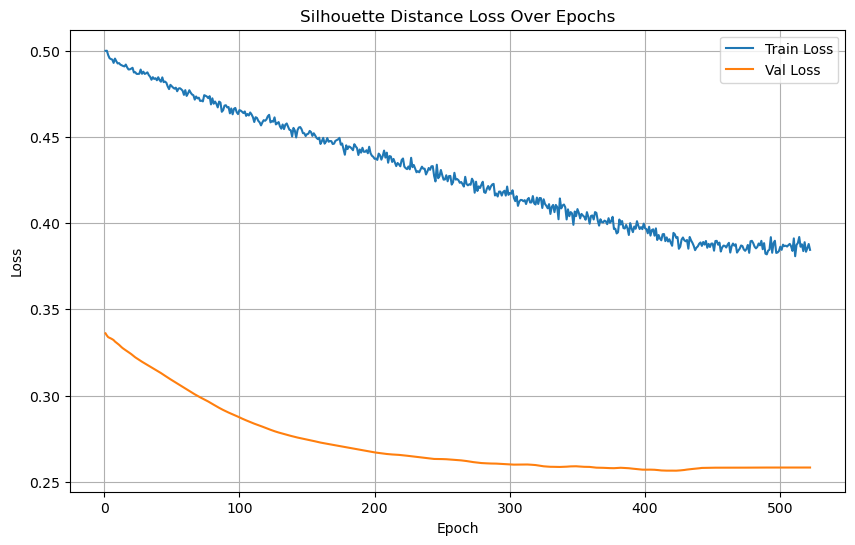

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/150], Loss: 0.2642


Test Batch [20/150], Loss: 0.3209
Test Batch [30/150], Loss: 0.3348


Test Batch [40/150], Loss: 0.4058


Test Batch [50/150], Loss: 0.4280
Test Batch [60/150], Loss: 0.3808


Test Batch [70/150], Loss: 0.2607
Test Batch [80/150], Loss: 0.3439
Test Batch [90/150], Loss: 0.2150


Test Batch [100/150], Loss: 0.1743
Test Batch [110/150], Loss: 0.2475
Test Batch [120/150], Loss: 0.1486


Test Batch [130/150], Loss: 0.3733
Test Batch [140/150], Loss: 0.3373


Test Batch [150/150], Loss: 0.1942

Test Loss: 0.3154


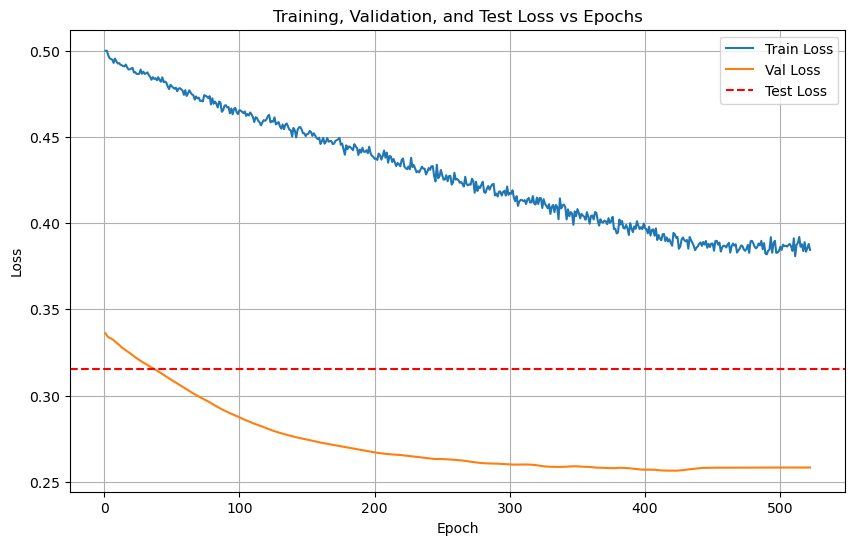

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/150 for test dataset.


  Processed batch 20/150 for test dataset.


  Processed batch 30/150 for test dataset.
  Processed batch 40/150 for test dataset.
  Processed batch 50/150 for test dataset.


  Processed batch 60/150 for test dataset.
  Processed batch 70/150 for test dataset.
  Processed batch 80/150 for test dataset.
  Processed batch 90/150 for test dataset.


  Processed batch 100/150 for test dataset.
  Processed batch 110/150 for test dataset.
  Processed batch 120/150 for test dataset.
  Processed batch 130/150 for test dataset.


  Processed batch 140/150 for test dataset.
  Processed batch 150/150 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (9571, 128)
Test labels shape: (9571,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 62.86%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       0.60      0.60      0.60         5
           2       0.50      0.40      0.44         5
           3       0.67      0.80      0.73         5
           4       0.67      0.80      0.73         5
           5       0.57      0.80      0.67         5
           7       1.00      0.80      0.89         5
           8       0.00      0.00      0.00         0
           9       0.67      0.40      0.50         5
          10       0.22      0.40      0.29         5
          11       0.50      0.40      0.44         5
          12       0.83      1.00      0.91         5
          13       1.00      0.20      0.33         5
          14       0.5

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_clas

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (9571, 128)
Test labels shape: (9571,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.8899  |  Val Loss: 2.9996
Validation loss improved from inf to 2.9996.
[Epoch 2/1000] Train Loss: 2.8524  |  Val Loss: 2.9569
Validation loss improved from 2.9996 to 2.9569.
[Epoch 3/1000] Train Loss: 2.8202  |  Val Loss: 2.9169
Validation loss improved from 2.9569 to 2.9169.
[Epoch 4/1000] Train Loss: 2.7927  |  Val Loss: 2.8776
Validation loss improved from 2.9169 to 2.8776.
[Epoch 5/1000] Train Loss: 2.7624  |  Val Loss: 2.8432
Validation loss improved from 2.8776 to 2.8432.
[Epoch 6/1000] Train Loss: 2.7369  |  Val Loss: 2.8112
Validation loss improved from 2.8432 to 2.8112.


[Epoch 7/1000] Train Loss: 2.7123  |  Val Loss: 2.7816
Validation loss improved from 2.8112 to 2.7816.
[Epoch 8/1000] Train Loss: 2.6877  |  Val Loss: 2.7545
Validation loss improved from 2.7816 to 2.7545.
[Epoch 9/1000] Train Loss: 2.6659  |  Val Loss: 2.7297
Validation loss improved from 2.7545 to 2.7297.
[Epoch 10/1000] Train Loss: 2.6442  |  Val Loss: 2.7066
Validation loss improved from 2.7297 to 2.7066.
[Epoch 11/1000] Train Loss: 2.6229  |  Val Loss: 2.6850
Validation loss improved from 2.7066 to 2.6850.
[Epoch 12/1000] Train Loss: 2.6025  |  Val Loss: 2.6644
Validation loss improved from 2.6850 to 2.6644.
[Epoch 13/1000] Train Loss: 2.5821  |  Val Loss: 2.6449
Validation loss improved from 2.6644 to 2.6449.
[Epoch 14/1000] Train Loss: 2.5615  |  Val Loss: 2.6272
Validation loss improved from 2.6449 to 2.6272.
[Epoch 15/1000] Train Loss: 2.5420  |  Val Loss: 2.6107
Validation loss improved from 2.6272 to 2.6107.
[Epoch 16/1000] Train Loss: 2.5225  |  Val Loss: 2.5945
Validation 

[Epoch 17/1000] Train Loss: 2.5050  |  Val Loss: 2.5787
Validation loss improved from 2.5945 to 2.5787.
[Epoch 18/1000] Train Loss: 2.4870  |  Val Loss: 2.5632
Validation loss improved from 2.5787 to 2.5632.
[Epoch 19/1000] Train Loss: 2.4692  |  Val Loss: 2.5484
Validation loss improved from 2.5632 to 2.5484.
[Epoch 20/1000] Train Loss: 2.4517  |  Val Loss: 2.5346
Validation loss improved from 2.5484 to 2.5346.
[Epoch 21/1000] Train Loss: 2.4346  |  Val Loss: 2.5209
Validation loss improved from 2.5346 to 2.5209.
[Epoch 22/1000] Train Loss: 2.4177  |  Val Loss: 2.5082
Validation loss improved from 2.5209 to 2.5082.
[Epoch 23/1000] Train Loss: 2.4011  |  Val Loss: 2.4951
Validation loss improved from 2.5082 to 2.4951.
[Epoch 24/1000] Train Loss: 2.3842  |  Val Loss: 2.4818
Validation loss improved from 2.4951 to 2.4818.
[Epoch 25/1000] Train Loss: 2.3672  |  Val Loss: 2.4691
Validation loss improved from 2.4818 to 2.4691.
[Epoch 26/1000] Train Loss: 2.3511  |  Val Loss: 2.4567
Validati

[Epoch 27/1000] Train Loss: 2.3346  |  Val Loss: 2.4442
Validation loss improved from 2.4567 to 2.4442.
[Epoch 28/1000] Train Loss: 2.3172  |  Val Loss: 2.4316
Validation loss improved from 2.4442 to 2.4316.
[Epoch 29/1000] Train Loss: 2.3006  |  Val Loss: 2.4189
Validation loss improved from 2.4316 to 2.4189.
[Epoch 30/1000] Train Loss: 2.2831  |  Val Loss: 2.4059
Validation loss improved from 2.4189 to 2.4059.
[Epoch 31/1000] Train Loss: 2.2648  |  Val Loss: 2.3925
Validation loss improved from 2.4059 to 2.3925.
[Epoch 32/1000] Train Loss: 2.2460  |  Val Loss: 2.3793
Validation loss improved from 2.3925 to 2.3793.
[Epoch 33/1000] Train Loss: 2.2265  |  Val Loss: 2.3664
Validation loss improved from 2.3793 to 2.3664.
[Epoch 34/1000] Train Loss: 2.2072  |  Val Loss: 2.3535
Validation loss improved from 2.3664 to 2.3535.


[Epoch 35/1000] Train Loss: 2.1876  |  Val Loss: 2.3413
Validation loss improved from 2.3535 to 2.3413.
[Epoch 36/1000] Train Loss: 2.1675  |  Val Loss: 2.3282
Validation loss improved from 2.3413 to 2.3282.
[Epoch 37/1000] Train Loss: 2.1474  |  Val Loss: 2.3153
Validation loss improved from 2.3282 to 2.3153.
[Epoch 38/1000] Train Loss: 2.1280  |  Val Loss: 2.3016
Validation loss improved from 2.3153 to 2.3016.
[Epoch 39/1000] Train Loss: 2.1083  |  Val Loss: 2.2884
Validation loss improved from 2.3016 to 2.2884.
[Epoch 40/1000] Train Loss: 2.0885  |  Val Loss: 2.2757
Validation loss improved from 2.2884 to 2.2757.
[Epoch 41/1000] Train Loss: 2.0688  |  Val Loss: 2.2624
Validation loss improved from 2.2757 to 2.2624.
[Epoch 42/1000] Train Loss: 2.0495  |  Val Loss: 2.2482
Validation loss improved from 2.2624 to 2.2482.
[Epoch 43/1000] Train Loss: 2.0298  |  Val Loss: 2.2344
Validation loss improved from 2.2482 to 2.2344.
[Epoch 44/1000] Train Loss: 2.0104  |  Val Loss: 2.2210
Validati

[Epoch 46/1000] Train Loss: 1.9707  |  Val Loss: 2.1934
Validation loss improved from 2.2073 to 2.1934.
[Epoch 47/1000] Train Loss: 1.9505  |  Val Loss: 2.1790
Validation loss improved from 2.1934 to 2.1790.
[Epoch 48/1000] Train Loss: 1.9301  |  Val Loss: 2.1646
Validation loss improved from 2.1790 to 2.1646.
[Epoch 49/1000] Train Loss: 1.9099  |  Val Loss: 2.1508
Validation loss improved from 2.1646 to 2.1508.
[Epoch 50/1000] Train Loss: 1.8903  |  Val Loss: 2.1362
Validation loss improved from 2.1508 to 2.1362.
[Epoch 51/1000] Train Loss: 1.8692  |  Val Loss: 2.1209
Validation loss improved from 2.1362 to 2.1209.
[Epoch 52/1000] Train Loss: 1.8485  |  Val Loss: 2.1064
Validation loss improved from 2.1209 to 2.1064.


[Epoch 53/1000] Train Loss: 1.8274  |  Val Loss: 2.0897
Validation loss improved from 2.1064 to 2.0897.
[Epoch 54/1000] Train Loss: 1.8062  |  Val Loss: 2.0737
Validation loss improved from 2.0897 to 2.0737.
[Epoch 55/1000] Train Loss: 1.7848  |  Val Loss: 2.0575
Validation loss improved from 2.0737 to 2.0575.
[Epoch 56/1000] Train Loss: 1.7638  |  Val Loss: 2.0408
Validation loss improved from 2.0575 to 2.0408.
[Epoch 57/1000] Train Loss: 1.7419  |  Val Loss: 2.0246
Validation loss improved from 2.0408 to 2.0246.
[Epoch 58/1000] Train Loss: 1.7201  |  Val Loss: 2.0081
Validation loss improved from 2.0246 to 2.0081.
[Epoch 59/1000] Train Loss: 1.6979  |  Val Loss: 1.9916
Validation loss improved from 2.0081 to 1.9916.
[Epoch 60/1000] Train Loss: 1.6761  |  Val Loss: 1.9758
Validation loss improved from 1.9916 to 1.9758.
[Epoch 61/1000] Train Loss: 1.6541  |  Val Loss: 1.9590
Validation loss improved from 1.9758 to 1.9590.
[Epoch 62/1000] Train Loss: 1.6329  |  Val Loss: 1.9405
Validati

[Epoch 63/1000] Train Loss: 1.6109  |  Val Loss: 1.9230
Validation loss improved from 1.9405 to 1.9230.
[Epoch 64/1000] Train Loss: 1.5891  |  Val Loss: 1.9061
Validation loss improved from 1.9230 to 1.9061.
[Epoch 65/1000] Train Loss: 1.5678  |  Val Loss: 1.8893
Validation loss improved from 1.9061 to 1.8893.
[Epoch 66/1000] Train Loss: 1.5463  |  Val Loss: 1.8730
Validation loss improved from 1.8893 to 1.8730.
[Epoch 67/1000] Train Loss: 1.5251  |  Val Loss: 1.8558
Validation loss improved from 1.8730 to 1.8558.
[Epoch 68/1000] Train Loss: 1.5044  |  Val Loss: 1.8402
Validation loss improved from 1.8558 to 1.8402.
[Epoch 69/1000] Train Loss: 1.4834  |  Val Loss: 1.8241
Validation loss improved from 1.8402 to 1.8241.


[Epoch 70/1000] Train Loss: 1.4629  |  Val Loss: 1.8081
Validation loss improved from 1.8241 to 1.8081.
[Epoch 71/1000] Train Loss: 1.4421  |  Val Loss: 1.7920
Validation loss improved from 1.8081 to 1.7920.
[Epoch 72/1000] Train Loss: 1.4220  |  Val Loss: 1.7766
Validation loss improved from 1.7920 to 1.7766.
[Epoch 73/1000] Train Loss: 1.4006  |  Val Loss: 1.7609
Validation loss improved from 1.7766 to 1.7609.
[Epoch 74/1000] Train Loss: 1.3799  |  Val Loss: 1.7451
Validation loss improved from 1.7609 to 1.7451.
[Epoch 75/1000] Train Loss: 1.3595  |  Val Loss: 1.7296
Validation loss improved from 1.7451 to 1.7296.
[Epoch 76/1000] Train Loss: 1.3388  |  Val Loss: 1.7135
Validation loss improved from 1.7296 to 1.7135.
[Epoch 77/1000] Train Loss: 1.3187  |  Val Loss: 1.6977
Validation loss improved from 1.7135 to 1.6977.
[Epoch 78/1000] Train Loss: 1.2984  |  Val Loss: 1.6841
Validation loss improved from 1.6977 to 1.6841.
[Epoch 79/1000] Train Loss: 1.2786  |  Val Loss: 1.6690
Validati

[Epoch 80/1000] Train Loss: 1.2592  |  Val Loss: 1.6550
Validation loss improved from 1.6690 to 1.6550.
[Epoch 81/1000] Train Loss: 1.2399  |  Val Loss: 1.6399
Validation loss improved from 1.6550 to 1.6399.
[Epoch 82/1000] Train Loss: 1.2206  |  Val Loss: 1.6260
Validation loss improved from 1.6399 to 1.6260.
[Epoch 83/1000] Train Loss: 1.2021  |  Val Loss: 1.6125
Validation loss improved from 1.6260 to 1.6125.
[Epoch 84/1000] Train Loss: 1.1839  |  Val Loss: 1.5975
Validation loss improved from 1.6125 to 1.5975.
[Epoch 85/1000] Train Loss: 1.1656  |  Val Loss: 1.5834
Validation loss improved from 1.5975 to 1.5834.
[Epoch 86/1000] Train Loss: 1.1482  |  Val Loss: 1.5690
Validation loss improved from 1.5834 to 1.5690.
[Epoch 87/1000] Train Loss: 1.1307  |  Val Loss: 1.5561
Validation loss improved from 1.5690 to 1.5561.


[Epoch 88/1000] Train Loss: 1.1135  |  Val Loss: 1.5439
Validation loss improved from 1.5561 to 1.5439.
[Epoch 89/1000] Train Loss: 1.0971  |  Val Loss: 1.5313
Validation loss improved from 1.5439 to 1.5313.
[Epoch 90/1000] Train Loss: 1.0800  |  Val Loss: 1.5196
Validation loss improved from 1.5313 to 1.5196.
[Epoch 91/1000] Train Loss: 1.0633  |  Val Loss: 1.5064
Validation loss improved from 1.5196 to 1.5064.
[Epoch 92/1000] Train Loss: 1.0462  |  Val Loss: 1.4924
Validation loss improved from 1.5064 to 1.4924.
[Epoch 93/1000] Train Loss: 1.0299  |  Val Loss: 1.4786
Validation loss improved from 1.4924 to 1.4786.
[Epoch 94/1000] Train Loss: 1.0135  |  Val Loss: 1.4657
Validation loss improved from 1.4786 to 1.4657.
[Epoch 95/1000] Train Loss: 0.9981  |  Val Loss: 1.4570
Validation loss improved from 1.4657 to 1.4570.
[Epoch 96/1000] Train Loss: 0.9837  |  Val Loss: 1.4489
Validation loss improved from 1.4570 to 1.4489.
[Epoch 97/1000] Train Loss: 0.9693  |  Val Loss: 1.4388
Validati

[Epoch 98/1000] Train Loss: 0.9554  |  Val Loss: 1.4283
Validation loss improved from 1.4388 to 1.4283.
[Epoch 99/1000] Train Loss: 0.9419  |  Val Loss: 1.4204
Validation loss improved from 1.4283 to 1.4204.
[Epoch 100/1000] Train Loss: 0.9284  |  Val Loss: 1.4110
Validation loss improved from 1.4204 to 1.4110.
[Epoch 101/1000] Train Loss: 0.9161  |  Val Loss: 1.3997
Validation loss improved from 1.4110 to 1.3997.
[Epoch 102/1000] Train Loss: 0.9041  |  Val Loss: 1.3899
Validation loss improved from 1.3997 to 1.3899.
[Epoch 103/1000] Train Loss: 0.8915  |  Val Loss: 1.3828
Validation loss improved from 1.3899 to 1.3828.
[Epoch 104/1000] Train Loss: 0.8795  |  Val Loss: 1.3746
Validation loss improved from 1.3828 to 1.3746.
[Epoch 105/1000] Train Loss: 0.8682  |  Val Loss: 1.3659
Validation loss improved from 1.3746 to 1.3659.


[Epoch 106/1000] Train Loss: 0.8571  |  Val Loss: 1.3592
Validation loss improved from 1.3659 to 1.3592.
[Epoch 107/1000] Train Loss: 0.8465  |  Val Loss: 1.3526
Validation loss improved from 1.3592 to 1.3526.
[Epoch 108/1000] Train Loss: 0.8359  |  Val Loss: 1.3449
Validation loss improved from 1.3526 to 1.3449.
[Epoch 109/1000] Train Loss: 0.8260  |  Val Loss: 1.3344
Validation loss improved from 1.3449 to 1.3344.
[Epoch 110/1000] Train Loss: 0.8159  |  Val Loss: 1.3265
Validation loss improved from 1.3344 to 1.3265.
[Epoch 111/1000] Train Loss: 0.8067  |  Val Loss: 1.3213
Validation loss improved from 1.3265 to 1.3213.
[Epoch 112/1000] Train Loss: 0.7971  |  Val Loss: 1.3140
Validation loss improved from 1.3213 to 1.3140.
[Epoch 113/1000] Train Loss: 0.7882  |  Val Loss: 1.3086
Validation loss improved from 1.3140 to 1.3086.
[Epoch 114/1000] Train Loss: 0.7796  |  Val Loss: 1.3023
Validation loss improved from 1.3086 to 1.3023.
[Epoch 115/1000] Train Loss: 0.7711  |  Val Loss: 1.295

[Epoch 117/1000] Train Loss: 0.7543  |  Val Loss: 1.2856
Validation loss improved from 1.2895 to 1.2856.
[Epoch 118/1000] Train Loss: 0.7469  |  Val Loss: 1.2795
Validation loss improved from 1.2856 to 1.2795.
[Epoch 119/1000] Train Loss: 0.7394  |  Val Loss: 1.2750
Validation loss improved from 1.2795 to 1.2750.
[Epoch 120/1000] Train Loss: 0.7315  |  Val Loss: 1.2707
Validation loss improved from 1.2750 to 1.2707.
[Epoch 121/1000] Train Loss: 0.7241  |  Val Loss: 1.2665
Validation loss improved from 1.2707 to 1.2665.
[Epoch 122/1000] Train Loss: 0.7175  |  Val Loss: 1.2640
Validation loss improved from 1.2665 to 1.2640.
[Epoch 123/1000] Train Loss: 0.7110  |  Val Loss: 1.2607
Validation loss improved from 1.2640 to 1.2607.
[Epoch 124/1000] Train Loss: 0.7038  |  Val Loss: 1.2565
Validation loss improved from 1.2607 to 1.2565.


[Epoch 125/1000] Train Loss: 0.6977  |  Val Loss: 1.2515
Validation loss improved from 1.2565 to 1.2515.
[Epoch 126/1000] Train Loss: 0.6914  |  Val Loss: 1.2462
Validation loss improved from 1.2515 to 1.2462.
[Epoch 127/1000] Train Loss: 0.6849  |  Val Loss: 1.2420
Validation loss improved from 1.2462 to 1.2420.
[Epoch 128/1000] Train Loss: 0.6789  |  Val Loss: 1.2394
Validation loss improved from 1.2420 to 1.2394.
[Epoch 129/1000] Train Loss: 0.6729  |  Val Loss: 1.2361
Validation loss improved from 1.2394 to 1.2361.
[Epoch 130/1000] Train Loss: 0.6678  |  Val Loss: 1.2336
Validation loss improved from 1.2361 to 1.2336.
[Epoch 131/1000] Train Loss: 0.6620  |  Val Loss: 1.2312
Validation loss improved from 1.2336 to 1.2312.
[Epoch 132/1000] Train Loss: 0.6564  |  Val Loss: 1.2281
Validation loss improved from 1.2312 to 1.2281.
[Epoch 133/1000] Train Loss: 0.6515  |  Val Loss: 1.2238
Validation loss improved from 1.2281 to 1.2238.
[Epoch 134/1000] Train Loss: 0.6464  |  Val Loss: 1.219

[Epoch 135/1000] Train Loss: 0.6413  |  Val Loss: 1.2163
Validation loss improved from 1.2195 to 1.2163.
[Epoch 136/1000] Train Loss: 0.6367  |  Val Loss: 1.2127
Validation loss improved from 1.2163 to 1.2127.
[Epoch 137/1000] Train Loss: 0.6318  |  Val Loss: 1.2114
Validation loss improved from 1.2127 to 1.2114.
[Epoch 138/1000] Train Loss: 0.6269  |  Val Loss: 1.2101
Validation loss improved from 1.2114 to 1.2101.
[Epoch 139/1000] Train Loss: 0.6227  |  Val Loss: 1.2059
Validation loss improved from 1.2101 to 1.2059.
[Epoch 140/1000] Train Loss: 0.6179  |  Val Loss: 1.2028
Validation loss improved from 1.2059 to 1.2028.
[Epoch 141/1000] Train Loss: 0.6136  |  Val Loss: 1.2010
Validation loss improved from 1.2028 to 1.2010.
[Epoch 142/1000] Train Loss: 0.6094  |  Val Loss: 1.2006
Validation loss improved from 1.2010 to 1.2006.
[Epoch 143/1000] Train Loss: 0.6057  |  Val Loss: 1.1991
Validation loss improved from 1.2006 to 1.1991.


[Epoch 144/1000] Train Loss: 0.6013  |  Val Loss: 1.1973
Validation loss improved from 1.1991 to 1.1973.
[Epoch 145/1000] Train Loss: 0.5977  |  Val Loss: 1.1966
Validation loss improved from 1.1973 to 1.1966.
[Epoch 146/1000] Train Loss: 0.5935  |  Val Loss: 1.1922
Validation loss improved from 1.1966 to 1.1922.
[Epoch 147/1000] Train Loss: 0.5898  |  Val Loss: 1.1924
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 148/1000] Train Loss: 0.5861  |  Val Loss: 1.1889
Validation loss improved from 1.1922 to 1.1889.
[Epoch 149/1000] Train Loss: 0.5824  |  Val Loss: 1.1860
Validation loss improved from 1.1889 to 1.1860.
[Epoch 150/1000] Train Loss: 0.5788  |  Val Loss: 1.1847
Validation loss improved from 1.1860 to 1.1847.
[Epoch 151/1000] Train Loss: 0.5754  |  Val Loss: 1.1821
Validation loss improved from 1.1847 to 1.1821.
[Epoch 152/1000] Train Loss: 0.5718  |  Val Loss: 1.1802
Validation loss improved from 1.1821 to 1.1802.


[Epoch 153/1000] Train Loss: 0.5683  |  Val Loss: 1.1795
Validation loss improved from 1.1802 to 1.1795.
[Epoch 154/1000] Train Loss: 0.5651  |  Val Loss: 1.1791
Validation loss improved from 1.1795 to 1.1791.
[Epoch 155/1000] Train Loss: 0.5617  |  Val Loss: 1.1786
Validation loss improved from 1.1791 to 1.1786.
[Epoch 156/1000] Train Loss: 0.5589  |  Val Loss: 1.1768
Validation loss improved from 1.1786 to 1.1768.
[Epoch 157/1000] Train Loss: 0.5557  |  Val Loss: 1.1751
Validation loss improved from 1.1768 to 1.1751.
[Epoch 158/1000] Train Loss: 0.5531  |  Val Loss: 1.1746
Validation loss improved from 1.1751 to 1.1746.
[Epoch 159/1000] Train Loss: 0.5498  |  Val Loss: 1.1735
Validation loss improved from 1.1746 to 1.1735.
[Epoch 160/1000] Train Loss: 0.5469  |  Val Loss: 1.1708
Validation loss improved from 1.1735 to 1.1708.
[Epoch 161/1000] Train Loss: 0.5441  |  Val Loss: 1.1709
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 162/1000] Train Loss: 0.5413  |  Val Loss:

[Epoch 163/1000] Train Loss: 0.5385  |  Val Loss: 1.1674
Validation loss improved from 1.1693 to 1.1674.
[Epoch 164/1000] Train Loss: 0.5358  |  Val Loss: 1.1664
Validation loss improved from 1.1674 to 1.1664.
[Epoch 165/1000] Train Loss: 0.5336  |  Val Loss: 1.1695
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 166/1000] Train Loss: 0.5307  |  Val Loss: 1.1674
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 167/1000] Train Loss: 0.5284  |  Val Loss: 1.1651
Validation loss improved from 1.1664 to 1.1651.
[Epoch 168/1000] Train Loss: 0.5256  |  Val Loss: 1.1646
Validation loss improved from 1.1651 to 1.1646.
[Epoch 169/1000] Train Loss: 0.5237  |  Val Loss: 1.1655
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 170/1000] Train Loss: 0.5211  |  Val Loss: 1.1641
Validation loss improved from 1.1646 to 1.1641.


[Epoch 171/1000] Train Loss: 0.5186  |  Val Loss: 1.1647
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 172/1000] Train Loss: 0.5162  |  Val Loss: 1.1619
Validation loss improved from 1.1641 to 1.1619.
[Epoch 173/1000] Train Loss: 0.5139  |  Val Loss: 1.1605
Validation loss improved from 1.1619 to 1.1605.
[Epoch 174/1000] Train Loss: 0.5120  |  Val Loss: 1.1611
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 175/1000] Train Loss: 0.5095  |  Val Loss: 1.1610
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 176/1000] Train Loss: 0.5073  |  Val Loss: 1.1617
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 177/1000] Train Loss: 0.5049  |  Val Loss: 1.1621
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 178/1000] Train Loss: 0.5033  |  Val Loss: 1.1615
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 179/1000] Train Loss: 0.5015  |  Val Loss: 1.1621
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 180/10

[Epoch 182/1000] Train Loss: 0.4952  |  Val Loss: 1.1595
Validation loss improved from 1.1602 to 1.1595.
[Epoch 183/1000] Train Loss: 0.4930  |  Val Loss: 1.1598
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 184/1000] Train Loss: 0.4912  |  Val Loss: 1.1602
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 185/1000] Train Loss: 0.4893  |  Val Loss: 1.1594
Validation loss improved from 1.1595 to 1.1594.
[Epoch 186/1000] Train Loss: 0.4879  |  Val Loss: 1.1593
Validation loss improved from 1.1594 to 1.1593.
[Epoch 187/1000] Train Loss: 0.4858  |  Val Loss: 1.1588
Validation loss improved from 1.1593 to 1.1588.
[Epoch 188/1000] Train Loss: 0.4839  |  Val Loss: 1.1603
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 189/1000] Train Loss: 0.4820  |  Val Loss: 1.1596
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 190/1000] Train Loss: 0.4802  |  Val Loss: 1.1600
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 191/1000] Train Loss: 0.4787  |  Val Loss: 1.1590
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 192/1000] Train Loss: 0.4769  |  Val Loss: 1.1594
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 193/1000] Train Loss: 0.4751  |  Val Loss: 1.1603
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 194/1000] Train Loss: 0.4736  |  Val Loss: 1.1584
Validation loss improved from 1.1588 to 1.1584.
[Epoch 195/1000] Train Loss: 0.4719  |  Val Loss: 1.1581
Validation loss improved from 1.1584 to 1.1581.
[Epoch 196/1000] Train Loss: 0.4701  |  Val Loss: 1.1592
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 197/1000] Train Loss: 0.4684  |  Val Loss: 1.1585
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 198/10

[Epoch 202/1000] Train Loss: 0.4608  |  Val Loss: 1.1612
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 203/1000] Train Loss: 0.4591  |  Val Loss: 1.1616
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 204/1000] Train Loss: 0.4578  |  Val Loss: 1.1589
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 205/1000] Train Loss: 0.4567  |  Val Loss: 1.1601
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 206/1000] Train Loss: 0.4550  |  Val Loss: 1.1591
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 207/1000] Train Loss: 0.4534  |  Val Loss: 1.1589
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 208/1000] Train Loss: 0.4519  |  Val Loss: 1.1617
!! Validation loss did NOT improve !! Patience: 13/100


[Epoch 209/1000] Train Loss: 0.4505  |  Val Loss: 1.1625
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 210/1000] Train Loss: 0.4493  |  Val Loss: 1.1642
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 211/1000] Train Loss: 0.4479  |  Val Loss: 1.1624
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 212/1000] Train Loss: 0.4470  |  Val Loss: 1.1622
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 213/1000] Train Loss: 0.4450  |  Val Loss: 1.1639
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 214/1000] Train Loss: 0.4441  |  Val Loss: 1.1660
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 215/1000] Train Loss: 0.4428  |  Val Loss: 1.1642
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 216/1000] Train Loss: 0.4412  |  Val Loss: 1.1665
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 217/1000] Train Loss: 0.4396  |  Val Loss: 1.1648
!! Validation loss did NOT improve !! Patience:

[Epoch 221/1000] Train Loss: 0.4346  |  Val Loss: 1.1665
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 222/1000] Train Loss: 0.4337  |  Val Loss: 1.1659
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 223/1000] Train Loss: 0.4322  |  Val Loss: 1.1678
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 224/1000] Train Loss: 0.4311  |  Val Loss: 1.1691
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 225/1000] Train Loss: 0.4296  |  Val Loss: 1.1686
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 226/1000] Train Loss: 0.4282  |  Val Loss: 1.1672
!! Validation loss did NOT improve !! Patience: 31/100


[Epoch 227/1000] Train Loss: 0.4273  |  Val Loss: 1.1677
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 228/1000] Train Loss: 0.4258  |  Val Loss: 1.1688
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 229/1000] Train Loss: 0.4243  |  Val Loss: 1.1695
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 230/1000] Train Loss: 0.4231  |  Val Loss: 1.1696
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 231/1000] Train Loss: 0.4219  |  Val Loss: 1.1684
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 232/1000] Train Loss: 0.4210  |  Val Loss: 1.1677
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 233/1000] Train Loss: 0.4202  |  Val Loss: 1.1688
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 234/1000] Train Loss: 0.4185  |  Val Loss: 1.1713
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 235/1000] Train Loss: 0.4177  |  Val Loss: 1.1728
!! Validation loss did NOT improve !! Patience:

[Epoch 240/1000] Train Loss: 0.4118  |  Val Loss: 1.1732
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 241/1000] Train Loss: 0.4106  |  Val Loss: 1.1738
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 242/1000] Train Loss: 0.4098  |  Val Loss: 1.1756
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 243/1000] Train Loss: 0.4087  |  Val Loss: 1.1779
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 244/1000] Train Loss: 0.4074  |  Val Loss: 1.1780
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 245/1000] Train Loss: 0.4069  |  Val Loss: 1.1808
!! Validation loss did NOT improve !! Patience: 50/100


[Epoch 246/1000] Train Loss: 0.4059  |  Val Loss: 1.1775
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 247/1000] Train Loss: 0.4048  |  Val Loss: 1.1803
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 248/1000] Train Loss: 0.4041  |  Val Loss: 1.1819
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 249/1000] Train Loss: 0.4027  |  Val Loss: 1.1812
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 250/1000] Train Loss: 0.4012  |  Val Loss: 1.1803
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 251/1000] Train Loss: 0.4001  |  Val Loss: 1.1822
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 252/1000] Train Loss: 0.3994  |  Val Loss: 1.1812
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 253/1000] Train Loss: 0.3985  |  Val Loss: 1.1814
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 254/1000] Train Loss: 0.3974  |  Val Loss: 1.1819
!! Validation loss did NOT improve !! Patience:

[Epoch 260/1000] Train Loss: 0.3918  |  Val Loss: 1.1871
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 261/1000] Train Loss: 0.3905  |  Val Loss: 1.1884
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 262/1000] Train Loss: 0.3895  |  Val Loss: 1.1894
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 263/1000] Train Loss: 0.3884  |  Val Loss: 1.1895
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 264/1000] Train Loss: 0.3877  |  Val Loss: 1.1892
!! Validation loss did NOT improve !! Patience: 69/100


[Epoch 265/1000] Train Loss: 0.3872  |  Val Loss: 1.1907
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 266/1000] Train Loss: 0.3856  |  Val Loss: 1.1924
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 267/1000] Train Loss: 0.3847  |  Val Loss: 1.1928
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 268/1000] Train Loss: 0.3837  |  Val Loss: 1.1948
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 269/1000] Train Loss: 0.3835  |  Val Loss: 1.1914
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 270/1000] Train Loss: 0.3818  |  Val Loss: 1.1931
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 271/1000] Train Loss: 0.3811  |  Val Loss: 1.1949
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 272/1000] Train Loss: 0.3802  |  Val Loss: 1.1963
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 273/1000] Train Loss: 0.3793  |  Val Loss: 1.1981
!! Validation loss did NOT improve !! Patience:

[Epoch 280/1000] Train Loss: 0.3735  |  Val Loss: 1.2036
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 281/1000] Train Loss: 0.3722  |  Val Loss: 1.2021
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 282/1000] Train Loss: 0.3715  |  Val Loss: 1.2030
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 283/1000] Train Loss: 0.3703  |  Val Loss: 1.2022
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 284/1000] Train Loss: 0.3697  |  Val Loss: 1.2039
!! Validation loss did NOT improve !! Patience: 89/100


[Epoch 285/1000] Train Loss: 0.3688  |  Val Loss: 1.2030
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 286/1000] Train Loss: 0.3682  |  Val Loss: 1.2019
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 287/1000] Train Loss: 0.3670  |  Val Loss: 1.2061
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 288/1000] Train Loss: 0.3662  |  Val Loss: 1.2078
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 289/1000] Train Loss: 0.3651  |  Val Loss: 1.2092
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 290/1000] Train Loss: 0.3644  |  Val Loss: 1.2093
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 291/1000] Train Loss: 0.3637  |  Val Loss: 1.2114
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 292/1000] Train Loss: 0.3630  |  Val Loss: 1.2095
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 293/1000] Train Loss: 0.3622  |  Val Loss: 1.2098
!! Validation loss did NOT improve !! Patience:

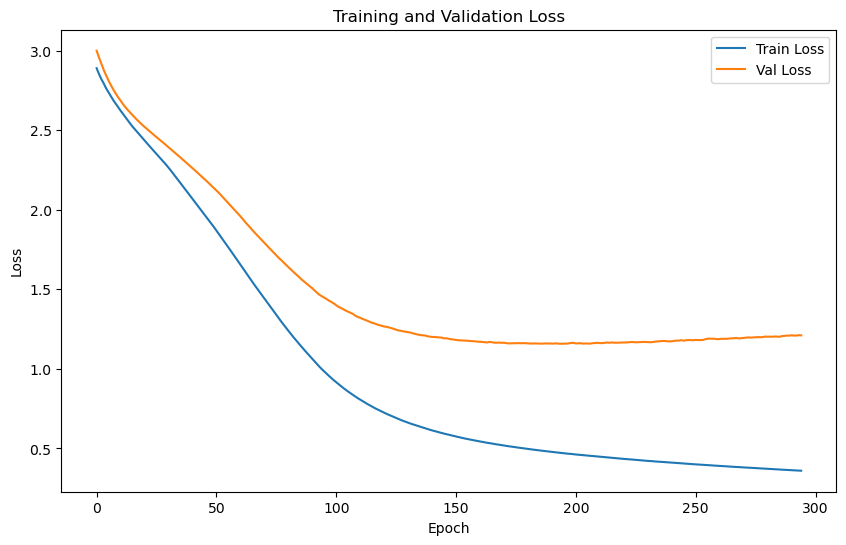

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 1.7121 | Test Accuracy: 53.65%


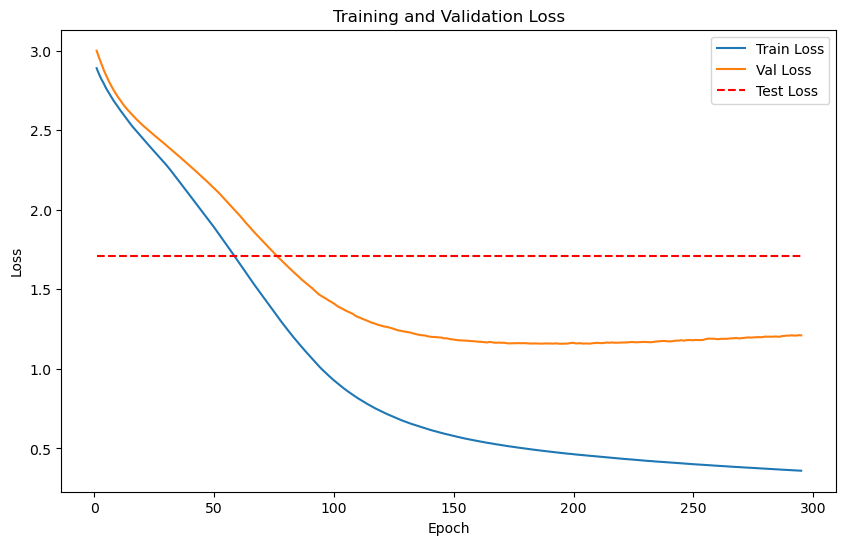

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


C:\Users\vella\AppData\Local\Temp\ipykernel_20332\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


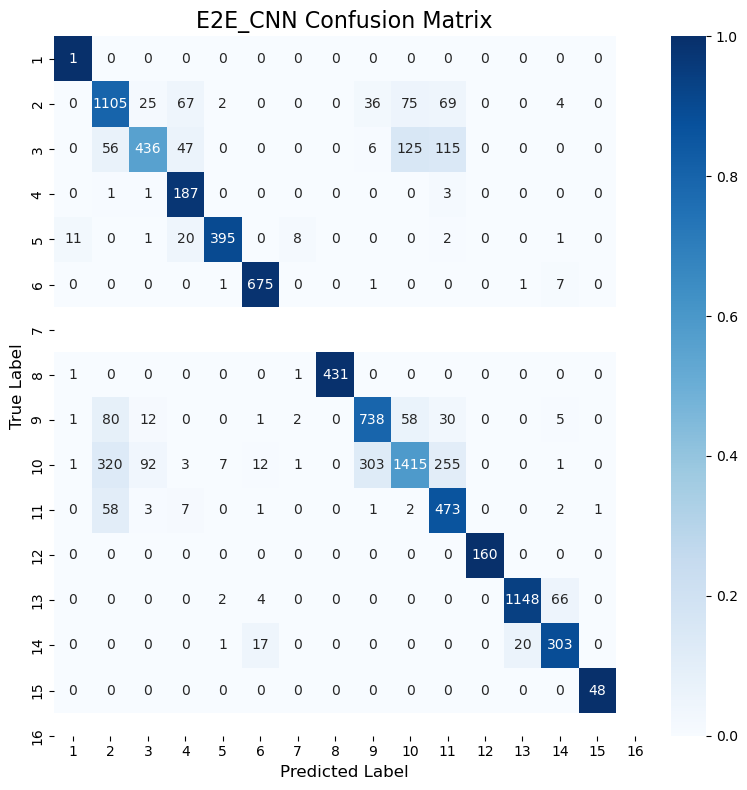

Classification Accuracy: 78.52%


C:\Users\vella\AppData\Local\Temp\ipykernel_20332\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


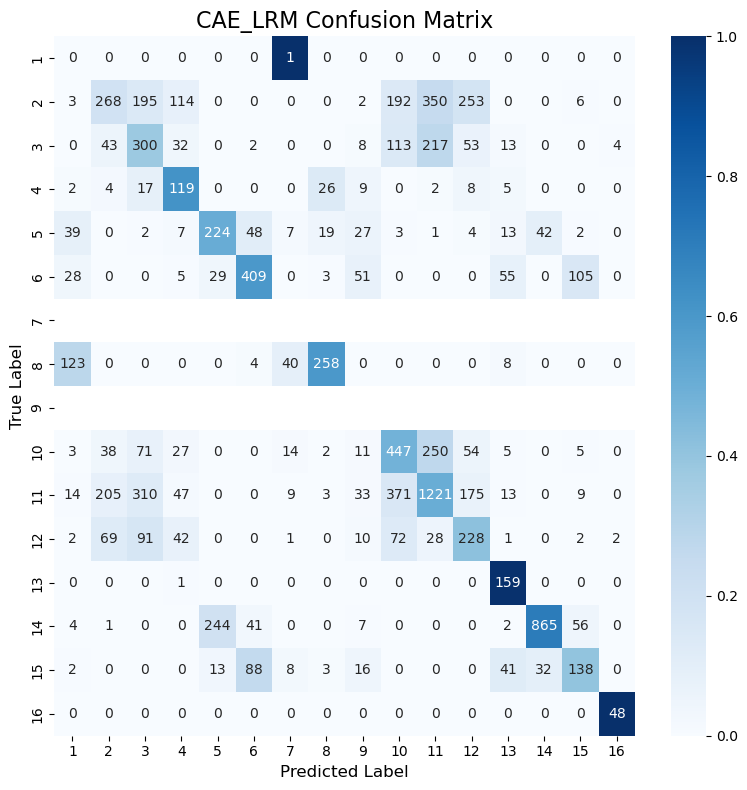

Classification Accuracy: 48.94%


C:\Users\vella\AppData\Local\Temp\ipykernel_20332\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


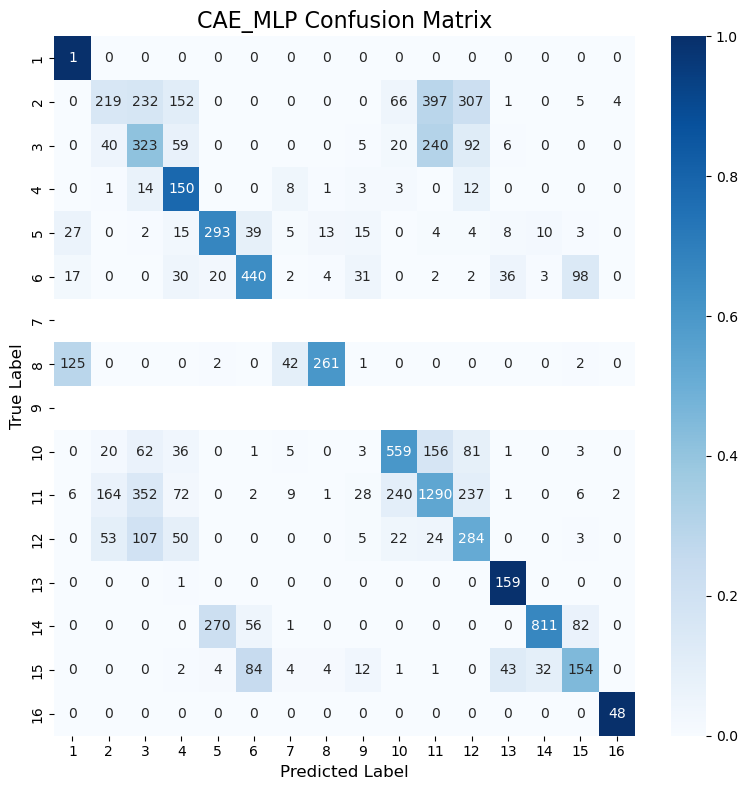

Classification Accuracy: 52.16%


C:\Users\vella\AppData\Local\Temp\ipykernel_20332\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


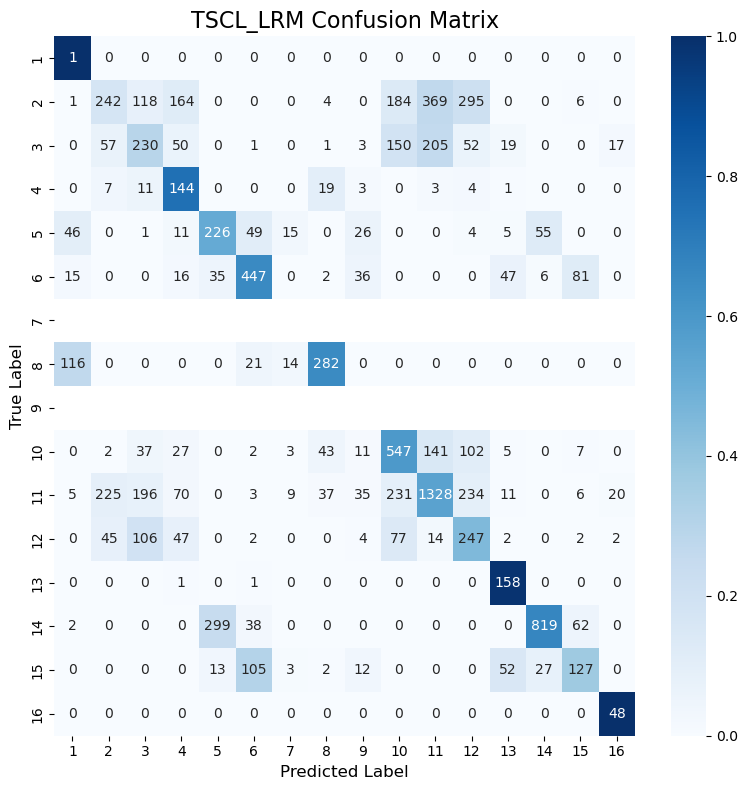

Classification Accuracy: 50.63%


C:\Users\vella\AppData\Local\Temp\ipykernel_20332\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


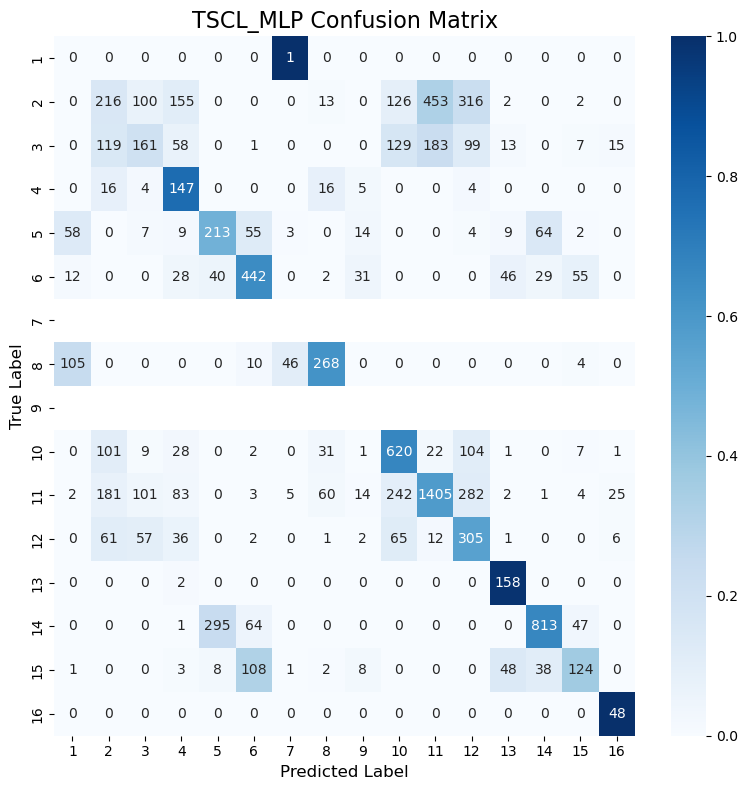

Classification Accuracy: 51.41%


C:\Users\vella\AppData\Local\Temp\ipykernel_20332\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


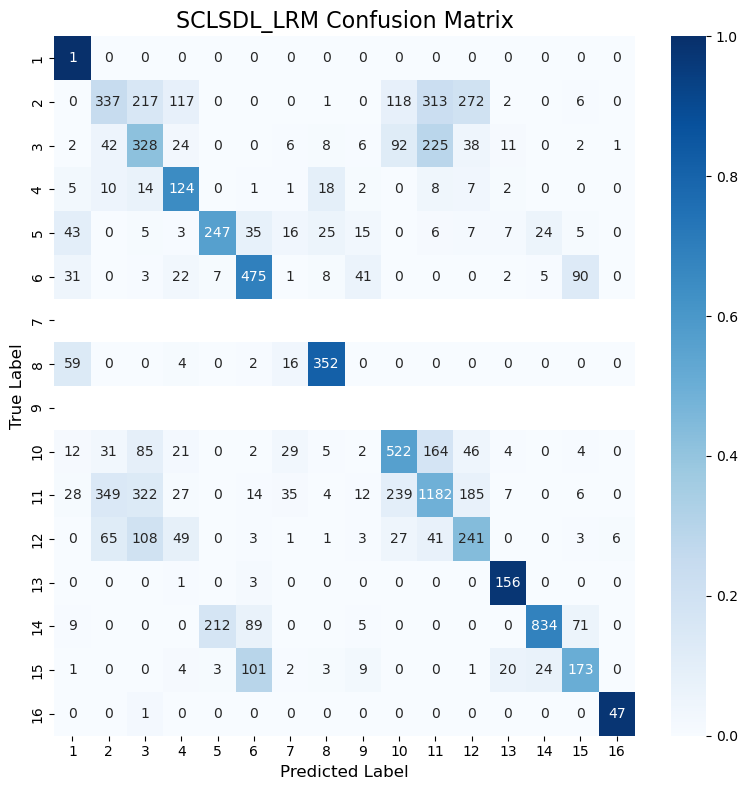

Classification Accuracy: 52.44%


C:\Users\vella\AppData\Local\Temp\ipykernel_20332\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


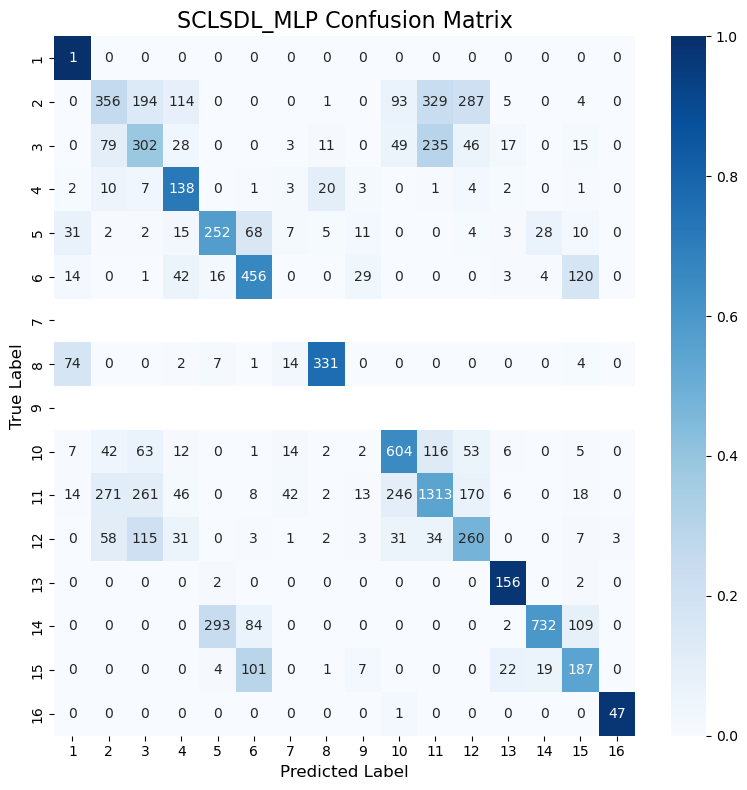

Classification Accuracy: 53.65%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          78.52
1    LRM (CAE)          48.94
2    MLP (CAE)          52.16
3     TSCL LRM          50.63
4     TSCL MLP          51.41
5  SCL_SDL LRM          52.44
6  SCL_SDL MLP          53.65

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          78.52
6  SCL_SDL MLP          53.65
5  SCL_SDL LRM          52.44
2    MLP (CAE)          52.16
4     TSCL MLP          51.41
3     TSCL LRM          50.63
1    LRM (CAE)          48.94
